# 0 导入函数库

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from chemicals import *
from scipy import stats
week = ['Mon.','Tues.','Wed.','Thur.','Fri.','Sat.','Sun.']
month = ['Jan.','Feb.','Mar.','Apr.','May.','June.','July.','Aug.','Sept.','Oct.','Nov.','Dec.']
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import matplotlib.transforms as transforms
import os
from cartopy.io.shapereader import Reader, natural_earth
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib as mpl
import csv
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from matplotlib.dates import DateFormatter
import math
from math import radians, cos, sin, asin, sqrt
import shapefile
import cmaps
import matplotlib.font_manager as fm
import sys
sys.path.append(r'D:\Desktop\codes\python codes\淄博')
from ZiboV2 import VOCzb as Zb
from Zibo import *
import re
from thefuzz import fuzz
from thefuzz import process
# from ZiboV2 import VOCzb as Zb
# import palettable
from sklearn.cluster import KMeans
from pandas import ExcelWriter
from mplfonts import use_font
def geodistance(lng1,lat1,lng2,lat2):
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    dis=2*asin(sqrt(a))*6371*1000
    return dis
    
def boxplotFilter(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_filter(x):
        if x > u_th:
            return np.nan
        elif x < l_th:
            return np.nan
        else:
            return x
    return col.map(box_filter)

def boxplotFilterPro(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 3*iqr # 上界
    l_th = col.quantile(0.25) - 3*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_filter(x):
        if x > u_th:
            return np.nan
        elif x < l_th:
            return np.nan
        else:
            return x
    return col.map(box_filter)

def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x

def cleanTsData(data,timecolumn='时间',pol=['PM2.5','PM10','SO2','NO2','NO','NOx','CO','O31'],groupbysite=True,sitecolumn='分区'):
    data = data.copy()
    # pass
    data = data.set_index(timecolumn)
    for column in pol:
        data[column] = data[column].apply(lambda x:removeNegative(x))
    if groupbysite:
        data_groups = data.groupby(sitecolumn)
        data = pd.DataFrame()
        for sitename,group in data_groups:
            # group = group.set_index(timecolumn)
            group_groups = group.groupby([group.index.month,group.index.hour])
            for datetime,group in group_groups:
                for column in pol:
                    group[column] = boxplotFilter(group[column])
                    # print(group)
                data = data.append(group)
    else:
        data_groups = data.groupby(data.index.month,data.index.hour)
        data = pd.DataFrame()
        for key,group in data_groups:
            for column in pol:
                # print(group[column])
                group[column] = boxplotFilter(group[column])
                data = data.append(group)
    data = data.reset_index()
    return data

def cleanTsDataPro(data,timecolumn='时间',pol=['NO2','NO','O31'],groupbysite=True,sitecolumn='站点名称'):
    data = data.copy()
    # pass
    data = data.set_index(timecolumn)
    # for column in pol:
    #     data[column] = data[column].apply(lambda x:removeNegative(x))
    if groupbysite:
        data_groups = data.groupby(sitecolumn)
        data = pd.DataFrame()
        for sitename,group in data_groups:
            # group = group.set_index(timecolumn)
            group_groups = group.groupby([group.index.month,group.index.hour])
            for datetime,group in group_groups:
                for column in pol:
                    group[column] = boxplotFilterPro(group[column])
                    # print(group)
                data = data.append(group)
    else:
        data_groups = data.groupby(data.index.month,data.index.hour)
        data = pd.DataFrame()
        for key,group in data_groups:
            for column in pol:
                # print(group[column])
                group[column] = boxplotFilterPro(group[column])
                data = data.append(group)
    data = data.reset_index()
    return data
    
# from windrose import WindroseAxes
# import cmaps
pd.options.display.float_format = '{:.4f}'.format

def trans_season(x):
    if x.month in [12,1,2]:
        return '冬'
    elif x.month in [3,4,5]:
        return '春'
    elif x.month in [6,7,8]:
        return '夏'
    elif x.month in [9,10,11]:
        return '秋'

ModuleNotFoundError: No module named 'cmaps'

# 1 VOCs数据前处理

## 1.1 数据合并

### 1.1.1 合并2021年1月至9月小时数据

In [ ]:
paths = glob.glob(r'/data/home/xuejin/code/VOCs_zb/originalData/2021年1月至9月小时数据/*')
# print(paths)
data0 = pd.DataFrame()
for path in paths:
    temp = pd.read_html(path,header=1,parse_dates=['时间'])[0]
    # print(temp)
    sitename = path.split('_')[2]
    print(sitename)
    temp['站点名称'] = sitename
    data0 = data0.append(temp)

data0.columns = [column.split('(')[0].strip() for column in data0.columns]
data0 = data0.set_index(['时间','站点名称'])
data0 = data0.iloc[:,3:-28]
data0 = data0.copy()
data0 = data0.reset_index()
data0 = data0.loc[~data0['时间'].isin(['平均值','最大值','最小值'])]
# data0.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/淄博市2021年1月至9月小时数据镇办VOCs数据合并.csv',index=False)

### 1.1.2 合并2021年10月至12月小时数据

In [ ]:
paths = glob.glob(r'/data/home/xuejin/code/VOCs_zb/originalData/2021年10月至12月小时数据/*')
# print(paths)
data1 = pd.DataFrame()
for path in paths:
    temp = pd.read_excel(path,parse_dates=['时间'])
    data1 = data1.append(temp)
data1.columns = [column.split('(')[0] for column in data1.columns]
del data1['区县']
data1 = data1.set_index(['时间','站点名称'])
data1 = data1.iloc[:,3:-28]
data1 = data1.reset_index()
data1.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/淄博市2021年10月至12月小时数据镇办VOCs数据合并.csv',index=False)
# data0[Zb.species]

### 1.1.3 将2021年数据合并到2019-2020年

In [ ]:
data = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2020淄博两年镇办VOCs数据.csv',parse_dates=['时间'])
data = data.set_index(['站点名称','时间'])
data = data.iloc[:,3:59]
data = data.reset_index()
# data
data = data.append(data0)
data = data.append(data1)
# data.to_csv('/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据合并.csv',index=False)
data

## 1.2 导入数据

In [18]:
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\2019-2021淄博市镇办VOCs数据合并.csv',parse_dates=['时间'])
data

,站点名称,时间,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,对乙基甲苯,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷
0,北郊镇,2019-01-01 00:00:00,18.7700,11.6600,26.5400,8.2700,9.3400,14.7900,13.4700,0.3500,...,3.2700,2.4100,5.1500,1.6600,6.7600,19.8200,1.9800,2.0400,21.1900,5.7000
1,北郊镇,2019-01-01 01:00:00,17.0800,12.0100,23.4900,7.0400,8.2800,13.3100,13.0800,0.4000,...,3.7000,3.1100,6.2200,2.6800,7.2400,29.4100,2.5800,3.1200,34.0800,9.2800
2,北郊镇,2019-01-01 02:00:00,17.9600,12.4200,26.1800,7.3600,8.1200,15.9600,14.0200,0.6300,...,5.5800,5.1000,11.1600,4.2900,12.5600,21.8500,3.4800,3.5400,36.1000,10.2700
3,北郊镇,2019-01-01 03:00:00,20.9100,12.4500,34.0000,7.8000,9.7000,19.5600,15.1200,0.8000,...,6.3300,5.6300,12.3400,4.2900,13.5200,16.5800,3.3000,1.7400,27.9500,8.5200
4,北郊镇,2019-01-01 04:00:00,21.1400,12.8300,57.8600,11.0300,10.3000,20.2100,12.0700,0.4800,...,5.1000,4.7200,9.7700,3.5900,11.2100,20.4500,2.8200,3.0600,28.8500,8.7400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465293,钟楼街办,2021-12-31 19:00:00,8.1900,4.8700,8.7200,1.3300,1.8400,3.0900,0.0000,0.0000,...,0.0000,0.0000,0.7500,0.0000,0.0000,0.0000,1.1100,0.0000,0.0000,0.0000
465294,钟楼街办,2021-12-31 20:00:00,9.1000,5.7600,8.5600,1.5800,3.1700,3.2200,0.0000,0.0000,...,0.0500,0.0000,0.5900,0.0000,0.0000,0.0000,0.0000,0.2800,0.0000,0.0000
465295,钟楼街办,2021-12-31 21:00:00,8.0400,4.5300,7.5400,1.2000,2.4600,3.2400,0.0000,0.0000,...,0.0000,0.0000,0.8600,0.0000,0.2700,0.1900,0.6600,0.0000,0.0000,0.0000
465296,钟楼街办,2021-12-31 22:00:00,9.6300,4.8000,7.9900,1.6700,2.7800,3.7100,0.0000,0.0000,...,0.0000,0.0000,0.5900,0.0000,0.0000,0.0000,0.6600,0.3300,0.0000,0.0000


## 1.3 数据清洗

In [62]:
VOCs = data.copy()
VOCs = VOCs.set_index(['时间','站点名称'])
columnslist = list(VOCs.columns)
site_info = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\淄博市镇办VOCs监测网络.csv',encoding='utf_8_sig')
site_info = site_info.loc[site_info['站点类型'] == '镇办VOCs站']
site_dict = site_info.set_index('站点名称')
site_dict = site_dict.to_dict('index')
# site_dict

#去除负值
def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x
for column in columnslist:
    VOCs[column] = VOCs[column].apply(lambda x:removeNegative(x))

    
#剔除大量零值行和大量缺值行
VOCs = VOCs.drop(VOCs.loc[((VOCs == 0).astype(int).sum(axis=1) + VOCs.isna().sum(axis=1)>40)].index)

#剔除重复行
VOCs = VOCs.drop_duplicates(inplace=False)

# # VOCs1.to_csv(r'D:/desktop/清洗后.csv',encoding='utf_8_sig')
VOCs = VOCs.reset_index()

timeindex = pd.date_range(start='2019-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')
VOCs_groups = VOCs.groupby('站点名称')
VOCs = pd.DataFrame()
for key,group in VOCs_groups:
    group = group.set_index('时间')
    #对每个站点箱线剔除
    for column in columnslist:
        group[column] = boxplotFilterPro(group[column])
    group = group.reindex(timeindex)
    print(key)
    group['站点名称'] = key
    VOCs = VOCs.append(group)

VOCs.index.name = '时间'
VOCs = VOCs.reset_index()
VOCs

东孙边界站
北郊镇
历山街办
城东街办
城区街办
培训中心
市委
常家镇
房镇镇
曦园
松龄路街办
永安边界站
田镇街办
皇城镇
稷下街办
职业学院西校
胜利边界站
辛店街办
钟楼街办
闻韶街办
高城镇
鲁山


,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,对乙基甲苯,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷
0,2019-01-01 00:00:00,东孙边界站,15.4000,6.6800,29.9600,0.1500,4.8500,0.2300,1.0600,0.2000,...,1.4000,1.4500,4.0200,1.1300,1.2300,NaN,2.1600,0.6000,NaN,5.9300
1,2019-01-01 01:00:00,东孙边界站,15.3700,6.4100,NaN,0.1700,5.9700,0.2900,4.8800,0.1000,...,1.2300,1.2900,3.9200,1.1300,1.2300,4.3200,NaN,0.6000,NaN,7.8300
2,2019-01-01 02:00:00,东孙边界站,16.3000,6.6500,30.7300,4.4700,0.5200,0.2600,5.9900,0.1500,...,1.2900,1.4000,3.8100,1.1800,1.2900,1.7200,NaN,0.3600,NaN,5.0900
3,2019-01-01 03:00:00,东孙边界站,18.5500,9.1300,28.4100,5.5600,5.7600,0.4400,5.5200,0.1800,...,1.2900,1.3400,0.4300,1.1300,1.1800,1.5200,2.1600,0.4200,NaN,4.1800
4,2019-01-01 04:00:00,东孙边界站,NaN,NaN,0.1800,0.2300,7.0300,0.1600,1.1000,0.1300,...,1.4500,1.3400,3.9700,1.2900,1.2300,1.7200,NaN,0.3600,NaN,3.9500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578683,2021-12-31 19:00:00,鲁山,4.8500,5.1400,3.4100,0.6200,1.0400,0.9300,0.0000,0.0300,...,0.0000,0.0000,0.3200,0.0000,0.0000,0.0000,0.0600,NaN,0.0000,0.0000
578684,2021-12-31 20:00:00,鲁山,3.2600,2.7900,2.1700,0.3400,0.8600,0.4700,0.0000,0.0300,...,0.0000,0.0000,0.2700,0.0000,0.0000,0.0000,0.0600,NaN,0.0000,0.0000
578685,2021-12-31 21:00:00,鲁山,3.3600,2.9900,2.3400,0.2600,0.9100,1.4300,0.0000,0.0000,...,0.0000,0.0000,0.2100,0.0000,0.0000,0.0000,0.1100,0.1700,0.0000,0.0000
578686,2021-12-31 22:00:00,鲁山,3.2100,2.6100,2.2800,0.2400,0.2300,1.3200,0.9300,0.0000,...,0.0000,0.0000,0.0500,0.0000,0.0000,0.0000,0.0600,0.1100,0.0000,0.0000


**导出清洗数据**

In [ ]:
VOCs.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据_清洗后.csv',index=False)

# 2 常规数据前处理

## 2.1 合并常规数据

In [45]:
paths1 = glob.glob(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\原始数据\*')
norm18_20 = pd.DataFrame()
for path in paths1:
    temp = pd.read_csv(path,encoding='gbk')
    sitename = path.split('\\')[-1][13:-4]
    temp['站点名称'] = sitename

    norm18_20 = norm18_20.append(temp)
paths2 = glob.glob(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\2021镇办小时\*')
norm2021 = pd.DataFrame()
for path in paths2:
    temp = pd.read_csv(path,encoding='gbk')
    sitename = path.split('\\')[-1][4:]
    sitename = sitename.split('.')[0][:-2]
    temp['站点名称'] = sitename
    norm2021 = norm2021.append(temp)
norm = norm18_20.append(norm2021)
norm

,时间,PM10,PM2.5,二氧化硫,二氧化氮,一氧化氮,氮氧化物,一氧化碳,臭氧,能见度,主导风向(十六方位),风速,气温,湿度,站点名称
0,2017-12-01 00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,宝山生态科技园
1,2017-12-01 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,宝山生态科技园
2,2017-12-01 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,宝山生态科技园
3,2017-12-01 03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,宝山生态科技园
4,2017-12-01 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,宝山生态科技园
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 20,78.0000,48.0000,20.0000,47.0000,10.0000,62.0000,1.4000,42.0000,13.9000,西南,1.0000,3.6000,37.0000,龙泉镇
8756,2021-12-31 21,80.0000,51.0000,17.0000,52.0000,9.0000,66.0000,1.4000,31.0000,11.0000,南西南,0.8000,2.9000,42.0000,龙泉镇
8757,2021-12-31 22,88.0000,63.0000,17.0000,50.0000,9.0000,64.0000,1.6000,35.0000,12.3000,西南,1.1000,3.8000,42.0000,龙泉镇
8758,2021-12-31 23,97.0000,62.0000,15.0000,38.0000,9.0000,52.0000,1.4000,47.0000,13.9000,南西南,1.8000,4.2000,44.0000,龙泉镇


In [ ]:
norm.to_csv(r'D:\Desktop\淄博\工作成果\VOCs案例库\镇办空气原始数据\镇办VOCs站常规空气_201712_202112.csv',index=False)

## 2.2 清洗常规数据

---
* 城东街办的NO缺失严重，尤其是在2020年4-9月，因此去掉NO的限制
---   

In [7]:
norm = pd.read_csv(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\镇办空气原始数据\镇办VOCs站常规空气_201712_202112.csv',parse_dates=['时间'],encoding='utf_8_sig')

In [11]:
data1 = norm.copy()
data1['时间'] = pd.to_datetime(data1['时间'])
data1 = data1.loc[data1['站点名称'].isin(['城东街办','田镇街办','房镇镇'])]
data1 = data1.set_index(['时间','站点名称'])
data1 = data1.rename(columns={'一氧化氮':'NO','二氧化氮':'NO2','臭氧':'O31'})

del data1['主导风向(十六方位)']

def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x

for column in data1.columns:
    print(column)
    if column=='气温':
        continue
    data1[column] = data1[column].apply(lambda x:removeNegative(x))

data1 = data1.reset_index()
data1 = data1.set_index(['时间'])

data_new = pd.DataFrame()
for groupname,group in data1.groupby(['站点名称',pd.Grouper(freq = 'D')]):
    group_count = group.count()
    # 缺失值超过6个就剔除
    if (group_count['NO2']<18)|(group_count['O31']<18):
        continue
    data_new = data_new.append(group)
data1 = data_new.reset_index()
data1

PM10
PM2.5
二氧化硫
NO2
NO
氮氧化物
一氧化碳
O31
能见度
风速
气温
湿度


C:\Users\xuejin\AppData\Local\Temp\ipykernel_14772\2079127075.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(group)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_14772\2079127075.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(group)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_14772\2079127075.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(group)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_14772\2079127075.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(group)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_147

,时间,站点名称,PM10,PM2.5,二氧化硫,NO2,NO,氮氧化物,一氧化碳,O31,能见度,风速,气温,湿度
0,2017-12-01 00:00:00,城东街办,118.0,NaN,15.0,79.0,70.0,186.0,5.1,1.0,NaN,0.5,NaN,83.0
1,2017-12-01 01:00:00,城东街办,128.0,NaN,15.0,76.0,59.0,167.0,5.1,1.0,NaN,0.6,NaN,82.0
2,2017-12-01 02:00:00,城东街办,119.0,NaN,41.0,71.0,8.0,83.0,4.9,4.0,NaN,0.6,NaN,80.0
3,2017-12-01 03:00:00,城东街办,107.0,NaN,25.0,71.0,15.0,94.0,4.8,4.0,NaN,0.5,NaN,80.0
4,2017-12-01 04:00:00,城东街办,97.0,NaN,24.0,73.0,4.0,78.0,4.6,6.0,NaN,0.5,NaN,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104056,2021-12-31 19:00:00,田镇街办,108.0,62.0,33.0,79.0,89.0,216.0,1.5,9.0,NaN,NaN,NaN,NaN
104057,2021-12-31 20:00:00,田镇街办,124.0,69.0,43.0,81.0,74.0,195.0,1.6,9.0,NaN,NaN,NaN,NaN
104058,2021-12-31 21:00:00,田镇街办,129.0,76.0,59.0,82.0,75.0,198.0,1.6,9.0,NaN,NaN,NaN,NaN
104059,2021-12-31 22:00:00,田镇街办,144.0,87.0,78.0,81.0,44.0,148.0,1.6,9.0,NaN,NaN,NaN,NaN


In [12]:
data1.to_excel(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\三镇办空气质量数据.xlsx')

In [54]:
data2 = cleanTsDataPro(data1,pol = ['PM10','PM2.5','二氧化硫','NO2','NO','氮氧化物','一氧化碳','O31'])
data2

MemoryError: Unable to allocate 173. MiB for an array with shape (12, 1891311) and data type float64

In [ ]:
data2.to_csv(r'D:/desktop/镇办数据_剔除异常值.csv',index=False)

In [ ]:
data2 = pd.read_csv(r'D:/desktop/镇办数据_剔除异常值.csv',parse_dates=['时间'])

In [ ]:
# data2 = cleanTsDataPro(data1)
data_line = data2.copy()
data_fnl1 = pd.DataFrame()
for groupname,group in data_line.groupby('站点名称'):
    # print(group.columns)
    df_imputed = group.iloc[:,1:]
    # print(df_imputed)
    df_imputed = df_imputed.interpolate(method='cubic')
    df_imputed['站点名称'] = groupname
    df_imputed['时间'] = group['时间'].values
    data_fnl1 = data_fnl1.append(df_imputed)
data3 = data_fnl1.copy()

data_groups = data3.groupby('站点名称')
data3 = pd.DataFrame()
for key,group in data_groups:
    print(key)
    
    group = group.set_index('时间')
    group = group.sort_index()
    group_day_groups = group.groupby(pd.Grouper(freq='D'))
    group_day = pd.DataFrame()
    # 重新计算O38
    for day,group_day_group in group_day_groups:
        group_day_group['O38'] = group_day_group['O31'].rolling(min_periods=6,window='8h').mean()
        group_day_group.O38[group_day_group.index.hour<7]=np.nan
        data3 = data3.append(group_day_group)
data3.index.name = '时间'
data3 = data3.reset_index()
# data3 = data3[['时间','站点名称','PM2.5','PM10','SO2','NO2','NO','NOx','CO','O31','O38']]
data3

NameError: name 'data2' is not defined

In [ ]:
data3.to_csv(r'D:/desktop/2018-2021镇办空气质量数据_清洗后.csv',encoding='utf_8_sig',index=False)

# 4 VOCs统计分析

## 4.1 导入数据

In [60]:
aqData = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\2018-2021镇办空气质量数据_清洗后.csv',parse_dates=['时间'])
VOCs0 = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
aqData

,时间,站点名称,PM10,PM2.5,二氧化硫,NO2,NO,氮氧化物,一氧化碳,O31,能见度,风速,气温,湿度,O38
0,2017-12-01 00:00:00,东孙边界站,144.0000,81.0000,44.0000,64.0000,202.0000,373.0000,2.2000,6.0000,20.0913,0.5000,-0.7338,74.0000,NaN
1,2017-12-01 01:00:00,东孙边界站,197.0000,90.0000,52.0000,57.0000,130.0000,257.0000,2.2000,5.0000,4.7398,0.8000,0.6326,76.0000,NaN
2,2017-12-01 02:00:00,东孙边界站,188.0000,103.0000,34.0000,46.0000,104.0000,206.0000,2.3000,6.0000,4.8291,0.9000,0.0017,82.0000,NaN
3,2017-12-01 03:00:00,东孙边界站,173.0000,100.0000,32.0000,43.0000,88.0000,179.0000,2.0000,6.0000,6.9909,1.1000,-0.2128,80.0000,NaN
4,2017-12-01 04:00:00,东孙边界站,161.0000,96.0000,30.0000,46.0000,71.0000,156.0000,1.9000,6.0000,11.0350,0.7000,1.3238,79.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642217,2021-12-31 19:00:00,龙泉镇,60.0000,41.0000,19.0000,52.0000,9.0000,66.0000,1.3000,39.0000,15.3000,1.5000,4.6000,33.0000,62.2500
2642218,2021-12-31 20:00:00,龙泉镇,78.0000,48.0000,20.0000,47.0000,10.0000,62.0000,1.4000,42.0000,13.9000,1.0000,3.6000,37.0000,59.2500
2642219,2021-12-31 21:00:00,龙泉镇,80.0000,51.0000,17.0000,52.0000,9.0000,66.0000,1.4000,31.0000,11.0000,0.8000,2.9000,42.0000,53.7500
2642220,2021-12-31 22:00:00,龙泉镇,88.0000,63.0000,17.0000,50.0000,9.0000,64.0000,1.6000,35.0000,12.3000,1.1000,3.8000,42.0000,48.8750


In [6]:
data = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data = data['区县'].apply(lambda x:x)
data = data.loc[data['站点名称'].isin(site_sp.keys())]
data = data.set_index(['时间','站点名称'])
# data = cal_vconc(data)
data = data.reset_index()
data = data.merge(aqData,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
data = match_site(data,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data['站点名称'] = data['站点名称'].apply(lambda x:site_sp[x])
data

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,一氧化碳,O31,能见度,风速,气温,湿度,O38,区县,经度,纬度
0,2019-01-01 00:00:00,周村区,NaN,11.6600,NaN,NaN,NaN,NaN,NaN,0.3500,...,1.9000,7.0000,6.2000,0.2000,1.4653,71.0000,NaN,周村区,117.9083,36.8252
1,2019-01-01 01:00:00,周村区,NaN,12.0100,NaN,NaN,NaN,NaN,NaN,0.4000,...,2.1000,7.0000,5.3000,0.2000,-0.9365,75.0000,NaN,周村区,117.9083,36.8252
2,2019-01-01 02:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6300,...,2.0000,7.0000,4.9000,0.1000,-0.1414,76.0000,NaN,周村区,117.9083,36.8252
3,2019-01-01 03:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8000,...,2.3000,7.0000,4.5000,0.1000,-1.8593,78.0000,NaN,周村区,117.9083,36.8252
4,2019-01-01 04:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4800,...,2.4000,8.0000,5.0000,0.2000,-0.7800,75.0000,NaN,周村区,117.9083,36.8252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162301,2021-12-31 19:00:00,背景站,4.8500,NaN,3.4100,0.6200,1.0400,0.9300,0.0000,0.0300,...,2.1000,50.0000,16.8000,1.4000,-5.4310,46.0000,77.8750,博山区,118.0553,36.3040
162302,2021-12-31 20:00:00,背景站,3.2600,2.7900,2.1700,0.3400,0.8600,0.4700,0.0000,0.0300,...,1.9000,67.0000,21.5000,1.6000,4.0465,45.0000,75.1250,博山区,118.0553,36.3040
162303,2021-12-31 21:00:00,背景站,3.3600,2.9900,2.3400,0.2600,0.9100,1.4300,0.0000,0.0000,...,1.6000,64.0000,18.6000,1.7000,1.4834,51.0000,71.8750,博山区,118.0553,36.3040
162304,2021-12-31 22:00:00,背景站,3.2100,2.6100,2.2800,0.2400,0.2300,1.3200,0.9300,0.0000,...,1.5000,63.0000,18.9000,1.8000,2.5902,54.0000,68.3750,博山区,118.0553,36.3040


In [7]:
data = data.loc[data['时间'].dt.year==2021]
data

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,一氧化碳,O31,能见度,风速,气温,湿度,O38,区县,经度,纬度
16776,2021-01-01 01:00:00,周村区,6.8200,5.0600,5.3300,2.8900,0.4900,2.4100,3.6300,0.0000,...,1.5000,11.0000,11.6000,2.2000,0.3020,58.0000,NaN,周村区,117.9083,36.8252
16777,2021-01-01 02:00:00,周村区,7.2800,5.2300,5.7300,1.5400,0.5500,1.6900,4.3100,0.0000,...,1.2000,15.0000,12.8000,2.3000,1.5511,58.0000,NaN,周村区,117.9083,36.8252
16778,2021-01-01 03:00:00,周村区,NaN,4.0600,9.4300,1.6600,2.8300,3.8400,3.1700,0.0000,...,1.0000,23.0000,15.5000,2.3000,1.6213,56.0000,NaN,周村区,117.9083,36.8252
16779,2021-01-01 04:00:00,周村区,6.6300,3.3700,4.7400,0.1300,1.9300,2.0500,2.1200,0.0000,...,0.9000,26.0000,16.0000,2.2000,2.1210,55.0000,NaN,周村区,117.9083,36.8252
16780,2021-01-01 05:00:00,周村区,6.2300,3.2300,3.9800,1.5300,1.7900,1.5600,2.9400,0.0000,...,0.7000,24.0000,16.1000,1.8000,2.4314,55.0000,NaN,周村区,117.9083,36.8252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162301,2021-12-31 19:00:00,背景站,4.8500,NaN,3.4100,0.6200,1.0400,0.9300,0.0000,0.0300,...,2.1000,50.0000,16.8000,1.4000,-5.4310,46.0000,77.8750,博山区,118.0553,36.3040
162302,2021-12-31 20:00:00,背景站,3.2600,2.7900,2.1700,0.3400,0.8600,0.4700,0.0000,0.0300,...,1.9000,67.0000,21.5000,1.6000,4.0465,45.0000,75.1250,博山区,118.0553,36.3040
162303,2021-12-31 21:00:00,背景站,3.3600,2.9900,2.3400,0.2600,0.9100,1.4300,0.0000,0.0000,...,1.6000,64.0000,18.6000,1.7000,1.4834,51.0000,71.8750,博山区,118.0553,36.3040
162304,2021-12-31 22:00:00,背景站,3.2100,2.6100,2.2800,0.2400,0.2300,1.3200,0.9300,0.0000,...,1.5000,63.0000,18.9000,1.8000,2.5902,54.0000,68.3750,博山区,118.0553,36.3040


## 4.2 VOCs浓度分析

### 4.2.0 计算单个物种全市平均

In [50]:
VOCs_bycity = data.copy()
VOCs_bycity = VOCs_bycity.set_index(['时间','站点名称']).iloc[:,:56].dropna(axis=0,how='all').reset_index()
print(len(data),len(VOCs_bycity))
VOCs_bycity = VOCs_bycity.set_index('时间')
VOCs_bycity = VOCs_bycity.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

VOCs_bycity0 = cal_group(VOCs_bycity)
VOCs_bycity0 = VOCs_bycity0.reset_index()


# 计算全市平均
VOCs_city = data.copy()
VOCs_city = VOCs_city.loc[VOCs_city['站点名称']!='背景站']
VOCs_city = VOCs_city.set_index('时间')
VOCs_city = VOCs_city.groupby(pd.Grouper(freq='D')).mean()
# VOCs_city = cal_group(VOCs_city)
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.reset_index()
VOCs_city = VOCs_city.iloc[:,:57]
VOCs_city = VOCs_city.mean(axis=0).sort_values(ascending=False)
# VOCs_city

sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(12,6))
ax.bar(VOCs_city.index,VOCs_city,color='#fc9d9a')
ax.set_xticklabels(VOCs_city.index,rotation=90)
ax = bar_labels(ax,offset=0.4,fontsize=6,fmt='%.1f',where='up',color='black')
ax.set_xlim(-1,56)
ax.set_ylabel(r'浓度(μg/$\mathregular{m^3}$)')
# ax.set_xlabel(r'物种')
plt.savefig(r'D:/desktop/PAMS物种浓度.png',dpi=300,bbox_inches='tight')

55314 47868


<ipython-input-50-faf45306fda9>:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  VOCs_city = VOCs_city.mean(axis=0).sort_values(ascending=False)
<ipython-input-50-faf45306fda9>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(VOCs_city.index,rotation=90)


### 4.2.1 区县浓度平均

#### 4.2.1.1 堆叠图 

In [13]:
VOCs_bycity = data.copy()
VOCs_bycity = VOCs_bycity.set_index(['时间','站点名称']).iloc[:,:56].dropna(axis=0,how='all').reset_index()
print(len(data),len(VOCs_bycity))
VOCs_bycity = VOCs_bycity.set_index('时间')
VOCs_bycity = VOCs_bycity.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

VOCs_bycity0 = cal_group(VOCs_bycity)
VOCs_bycity0 = VOCs_bycity0.reset_index()
# VOCs_bycity0 = VOCs_bycity0.set_index('站点名称')
# VOCs_bycity0 = VOCs_bycity.groupby('站点名称').mean()

# 计算全市平均
VOCs_city = data.copy()
VOCs_city = VOCs_city.loc[VOCs_city['站点名称']!='背景站']
VOCs_city = VOCs_city.set_index('时间')
VOCs_city = VOCs_city.groupby(pd.Grouper(freq='D')).mean()
VOCs_city = cal_group(VOCs_city)
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.reset_index()



# 加上全市平均
# VOCs_bycity0.loc['全市'] = VOCs_city
VOCs_bycity0 = VOCs_bycity0.append(VOCs_city)
VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').mean()
# VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').agg(['std','mean'])

# VOCs_bycitySTD.to_excel(r'D:/desktop/test.xlsx')
VOCs_bycitySTD.sort_values('VOCs').style.format("{:.1f}")

55314 47868


,烷烃,烯烃,芳香烃,异戊二烯,VOCs
站点名称,,,,,
背景站,9.2,1.2,3.0,0.0,13.5
沂源县,18.2,3.3,7.7,0.1,29.2
周村区,21.7,5.9,9.2,0.3,37.1
博山区,22.8,4.5,10.8,0.6,38.6
张店区,23.6,4.8,20.4,0.1,48.9
全市,32.5,5.7,13.3,0.5,52.1
桓台县,36.6,6.6,13.5,1.3,58.0
淄川区,48.1,9.5,17.9,1.0,76.4
高青县,54.5,7.1,15.5,0.6,77.6


In [12]:
VOCs_bycitySTD.style.format("{:.2f}")

,烷烃,烯烃,芳香烃,异戊二烯,VOCs
站点名称,,,,,
临淄区,52.88,9.31,16.83,1.39,80.40
全市,32.54,5.73,13.27,0.54,52.08
博山区,22.80,4.46,10.82,0.57,38.59
周村区,21.68,5.85,9.24,0.32,37.09
张店区,23.64,4.75,20.36,0.12,48.88
桓台县,36.59,6.60,13.55,1.34,57.99
沂源县,18.15,3.28,7.67,0.09,29.20
淄川区,48.10,9.46,17.87,1.01,76.43
背景站,9.23,1.23,3.02,0.04,13.53


#### 4.2.1.2 柱状图

In [ ]:
VOCs_bycity = data.copy()
VOCs_bycity = VOCs_bycity.set_index('时间')
VOCs_bycity = VOCs_bycity.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

VOCs_bycity0 = cal_group(VOCs_bycity)
VOCs_bycity0 = VOCs_bycity0.reset_index()
# VOCs_bycity0 = VOCs_bycity0.set_index('站点名称')
# VOCs_bycity0 = VOCs_bycity.groupby('站点名称').mean()

# 计算全市平均
VOCs_city = data.copy()
VOCs_city = VOCs_city.loc[VOCs_city['站点名称']!='背景站']
VOCs_city = VOCs_city.set_index('时间')
VOCs_city = VOCs_city.groupby(pd.Grouper(freq='D')).mean()
VOCs_city = cal_group(VOCs_city)
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.reset_index()



# 加上全市平均
# VOCs_bycity0.loc['全市'] = VOCs_city
VOCs_bycity0 = VOCs_bycity0.append(VOCs_city)
VOCs_bycity0['烯烃'] = VOCs_bycity0['烯烃'] + VOCs_bycity0['异戊二烯']
# VOCs_bycity0 = VOCs_bycity0.melt(id_vars=['站点名称','时间'],value_vars=['烷烃','烯烃','芳香烃','乙炔'],var_name='组分',value_name='浓度')
VOCs_bycity0

In [ ]:
# VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').agg(['std','mean'])
VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').mean()
VOCs_bycitySTD
# VOCs_bycitySTD.to_excel(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博全市及各区县VOCs浓度及组成.xlsx')

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(2,2,figsize=(18,8))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
num = 0
# import palettable
# colors = ['#ff418d','#41ff41','#0240ff','#ffab02']
colors=['#ff0000','#00cc67','#003eff','#ff41d9']
# colors=[(255, 0, 0),(0, 204, 103),(0, 62, 255),(255, 170, 0)],


for group in ['烷烃','烯烃','芳香烃','异戊二烯']:
        x = num//2
        y = num%2
        VOCs_group = VOCs_bycity0.groupby('站点名称').mean().sort_values(group,ascending=False)
        VOCs_group = VOCs_group.reset_index()  
        VOCs_group = VOCs_group.loc[VOCs_group['站点名称']!='全市']
        sitelist = list(VOCs_group['站点名称'])
        sitelist.append('全市')
        # print(colors[num])
        # print(VOCs_group)
        sns.barplot(x=VOCs_bycity0['站点名称'],y=VOCs_bycity0[group],
                order=sitelist,
                ci = 'sd',
                ax=ax[x,y],
                palette=[colors[num]],
                errwidth=1.5,
                capsize=0.3)
        # ax[x,y].bar_label(ax[x,y].containers[0],fmt='%.1f',fontsize=10,
                # label_type='edge',
                # padding=20,
                # )
        # ax[x,y].legend(loc='upper center',frameon=False,ncol=5,fontsize=15,bbox_to_anchor=(0.5,1.3))
        ax[x,y].set_xticklabels(sitelist,fontdict={'size':14})
        ax[x,y].set_ylabel('%s(μg/$\mathregular{m^3}$)'%group,fontsize=14)
        ax[x,y].set_xlabel(None)
        num = num + 1
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\区县浓度平均.png',dpi=400,bbox_inches='tight')

### 4.2.2 区县OFP平均

#### 4.2.2.1 堆叠图 

In [14]:
data1 = data.set_index(['站点名称','时间'])
data1 = cal_ofp(data1.iloc[:,:56])
data1 = data1.reset_index()
VOCs_bycity = data1.copy()
VOCs_bycity = VOCs_bycity.set_index('时间')
VOCs_bycity = VOCs_bycity.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

VOCs_bycity0 = cal_group(VOCs_bycity)
VOCs_bycity0 = VOCs_bycity0.reset_index()
# VOCs_bycity0 = VOCs_bycity0.set_index('站点名称')
# VOCs_bycity0 = VOCs_bycity.groupby('站点名称').mean()

# 计算全市平均
VOCs_city = data1.copy()
VOCs_city = VOCs_city.loc[VOCs_city['站点名称']!='背景站']
VOCs_city = VOCs_city.set_index('时间')
VOCs_city = VOCs_city.groupby(pd.Grouper(freq='D')).mean()
VOCs_city = cal_group(VOCs_city)
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.reset_index()



# 加上全市平均
# VOCs_bycity0.loc['全市'] = VOCs_city
VOCs_bycity0 = VOCs_bycity0.append(VOCs_city)
VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').mean()
# VOCs_bycitySTD = VOCs_bycity0.groupby('站点名称').agg(['std','mean'])

# VOCs_bycitySTD.to_excel(r'D:\Desktop\test2.xlsx')
VOCs_bycitySTD.sort_values('VOCs').style.format("{:.1f}")

,烷烃,烯烃,芳香烃,异戊二烯,VOCs
站点名称,,,,,
背景站,5.0,6.8,6.5,0.3,18.6
沂源县,9.7,21.5,32.3,0.7,64.3
博山区,14.0,27.6,30.8,4.5,76.6
周村区,10.7,33.6,48.8,2.5,95.6
全市,19.2,35.2,56.3,4.2,115.0
高青县,31.0,43.3,53.7,4.9,132.8
张店区,13.6,26.4,92.9,1.0,133.9
桓台县,24.0,41.0,62.1,10.6,137.1
临淄区,36.7,60.4,59.8,10.9,167.7


#### 4.2.1.2 柱状图

In [51]:
data1 = data.set_index(['站点名称','时间'])
data1 = cal_ofp(data1.iloc[:,:56])
data1 = data1.reset_index()
VOCs_bycity = data1.copy()
VOCs_bycity = VOCs_bycity.set_index('时间')
VOCs_bycity = VOCs_bycity.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

VOCs_bycity0 = cal_group(VOCs_bycity)
VOCs_bycity0 = VOCs_bycity0.reset_index()
# VOCs_bycity0 = VOCs_bycity0.set_index('站点名称')
# VOCs_bycity0 = VOCs_bycity.groupby('站点名称').mean()

# 计算全市平均
VOCs_city = data1.copy()
VOCs_city = VOCs_city.loc[VOCs_city['站点名称']!='背景站']
VOCs_city = VOCs_city.set_index('时间')
VOCs_city = VOCs_city.groupby(pd.Grouper(freq='D')).mean()
VOCs_city = cal_group(VOCs_city)
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.reset_index()



# 加上全市平均
# VOCs_bycity0.loc['全市'] = VOCs_city
VOCs_bycity0 = VOCs_bycity0.append(VOCs_city)
VOCs_bycity0['烯烃'] = VOCs_bycity0['烯烃'] + VOCs_bycity0['异戊二烯']
# VOCs_bycity0 = VOCs_bycity0.melt(id_vars=['站点名称','时间'],value_vars=['烷烃','烯烃','芳香烃','乙炔'],var_name='组分',value_name='浓度')
VOCs_bycity0

,站点名称,时间,烷烃,烯烃,芳香烃,异戊二烯,VOCs
0,临淄区,2021-01-01,42.5765,91.0024,63.4188,12.4985,196.9977
1,临淄区,2021-01-02,49.1847,100.8041,85.7251,19.1558,235.7138
2,临淄区,2021-01-03,NaN,NaN,NaN,NaN,NaN
3,临淄区,2021-01-04,48.9776,92.3326,93.9177,16.0430,235.2279
4,临淄区,2021-01-05,46.9264,78.6304,98.7553,9.3891,224.3121
...,...,...,...,...,...,...,...
360,全市,2021-12-27,7.0998,23.7251,42.5150,3.0201,73.3400
361,全市,2021-12-28,13.1473,41.2895,50.7044,3.7641,105.1411
362,全市,2021-12-29,15.7756,45.0157,60.0794,6.6627,120.8707
363,全市,2021-12-30,16.6807,40.4812,62.2165,5.7911,119.3784


In [54]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(2,2,figsize=(18,8))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
num = 0
# import palettable
# colors = ['#ff418d','#41ff41','#0240ff','#ffab02']
colors=['#ff0000','#00cc67','#003eff','#fc9d9a']
# colors=[(255, 0, 0),(0, 204, 103),(0, 62, 255),(255, 170, 0)],


for group in ['烷烃','烯烃','芳香烃','VOCs']:
        x = num//2
        y = num%2
        VOCs_group = VOCs_bycity0.groupby('站点名称').mean().sort_values(group,ascending=False)
        VOCs_group = VOCs_group.reset_index()  
        VOCs_group = VOCs_group.loc[VOCs_group['站点名称']!='全市']
        sitelist = list(VOCs_group['站点名称'])
        sitelist.append('全市')
        # print(colors[num])
        # print(VOCs_group)
        sns.barplot(x=VOCs_bycity0['站点名称'],y=VOCs_bycity0[group],
                order=sitelist,
                ci = 'sd',
                ax=ax[x,y],
                palette=[colors[num]],
                errwidth=1.5,
                capsize=0.3)
        # ax[x,y].bar_label(ax[x,y].containers[0],fmt='%.1f',fontsize=10,
                # label_type='edge',
                # padding=20,
                # )
        # ax[x,y].legend(loc='upper center',frameon=False,ncol=5,fontsize=15,bbox_to_anchor=(0.5,1.3))
        ax[x,y].set_xticklabels(sitelist,fontdict={'size':14})
        ax[x,y].set_ylabel('%s(μg/$\mathregular{m^3}$)'%group,fontsize=14)
        ax[x,y].set_xlabel(None)
        num = num + 1
# plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\区县活性平均.png',dpi=400,bbox_inches='tight')
plt.savefig(r'D:/desktop\区县活性平均.png',dpi=400,bbox_inches='tight')


### 4.2.2 区县浓度年变化

In [ ]:

VOCs_byyear = data.copy()
VOCs_byyear = VOCs_byyear.set_index('时间')
VOCs_byyear = VOCs_byyear.groupby(['站点名称',pd.Grouper(freq='D')]).mean()
VOCs_byyear = VOCs_byyear.reset_index()

# 计算全市年平均
VOCs_yearcity = data.copy()
VOCs_yearcity = VOCs_yearcity.set_index('时间')
VOCs_yearcity = VOCs_yearcity.groupby(pd.Grouper(freq='D')).mean().reset_index()
VOCs_yearcity['站点名称'] = '全市'
VOCs_byyear = VOCs_byyear.append(VOCs_yearcity)

VOCs_byyear = VOCs_byyear.set_index(['站点名称','时间'])
VOCs_byyear = cal_group(VOCs_byyear)
VOCs_byyear = VOCs_byyear.reset_index()
# VOCs_byyear


# '''数据导出'''
VOCs_byyear1 = VOCs_byyear.set_index(['时间'])
VOCs_byyear1 = VOCs_byyear1.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()[['VOCs']]
VOCs_byyear1 = VOCs_byyear1.unstack(level='站点名称')['VOCs']
# VOCs_byyear1.to_excel(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博市及各区县年变化.xlsx')

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
# sns.barplot(x=VOCs_byyear['时间'].dt.year,y=VOCs_byyear['VOCs'],hue=VOCs_byyear['区县'],)
VOCs_byyear1 = VOCs_byyear.groupby('站点名称').mean().sort_values('VOCs',ascending=False)
VOCs_byyear1 = VOCs_byyear1.reset_index()  
VOCs_byyear1 = VOCs_byyear1.loc[VOCs_byyear1['站点名称']!='全市']
sitelist = list(VOCs_byyear1['站点名称'])
sitelist.append('全市')
sns.barplot(x=VOCs_byyear['站点名称'],y=VOCs_byyear['VOCs'],hue=VOCs_byyear['时间'].dt.year,
        order=sitelist,
        ci = 'sd',
        ax=ax,
        palette=['grey','red','blue'],
        errwidth=1,
        capsize=0.07)
ax.legend(loc='upper center',frameon=False,ncol=3,bbox_to_anchor=(0.5,1.15))
ax.set_xticklabels(sitelist,fontsize = 15)
ax.set_ylabel('VOCs浓度(μg/$\mathregular{m^3}$)')
ax.set_xlabel(None)
# plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\各区县VOCs年变化.png', dpi=400,bbox_inches='tight')
# plt.show()

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
# sns.barplot(x=VOCs_byyear['时间'].dt.year,y=VOCs_byyear['VOCs'],hue=VOCs_byyear['区县'],)
VOCs_byyear1 = VOCs_byyear.groupby('站点名称').mean().sort_values('烯烃',ascending=False)
VOCs_byyear1 = VOCs_byyear1.reset_index()  
VOCs_byyear1 = VOCs_byyear1.loc[VOCs_byyear1['站点名称']!='全市']
# sitelist = list(VOCs_byyear1['站点名称'])
# sitelist.append('全市')
sns.barplot(x=VOCs_byyear['站点名称'],y=VOCs_byyear['烯烃'],hue=VOCs_byyear['时间'].dt.year,
        order=sitelist,
        ci = 'sd',
        ax=ax,
        palette=['grey','red','blue'],
        errwidth=1,
        capsize=0.07)
ax.legend(loc='upper center',frameon=False,ncol=3,bbox_to_anchor=(0.5,1.15))
# ax.set_xticklabels(sitelist,fontdict={'font':'Simsun','size':15})
ax.set_xticklabels(sitelist)

ax.set_ylabel('烯烃(μg/$\mathregular{m^3}$)')
ax.set_xlabel(None)
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\各区县烯烃年变化.png', dpi=400,bbox_inches='tight')

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
# sns.barplot(x=VOCs_byyear['时间'].dt.year,y=VOCs_byyear['VOCs'],hue=VOCs_byyear['区县'],)
VOCs_byyear1 = VOCs_byyear.groupby('站点名称').mean().sort_values('芳香烃',ascending=False)
VOCs_byyear1 = VOCs_byyear1.reset_index()  
VOCs_byyear1 = VOCs_byyear1.loc[VOCs_byyear1['站点名称']!='全市']
# sitelist = list(VOCs_byyear1['站点名称'])
# sitelist.append('全市')
sns.barplot(x=VOCs_byyear['站点名称'],y=VOCs_byyear['芳香烃'],hue=VOCs_byyear['时间'].dt.year,
        order=sitelist,
        ci = 'sd',
        ax=ax,
        palette=['grey','red','blue'],
        errwidth=1,
        capsize=0.07)
ax.legend(loc='upper center',frameon=False,ncol=3,bbox_to_anchor=(0.5,1.15))
# ax.set_xticklabels(sitelist,fontdict={'font':'Simsun','size':15})
ax.set_xticklabels(sitelist)

ax.set_ylabel('芳香烃(μg/$\mathregular{m^3}$)')
ax.set_xlabel(None)
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\各区县芳香烃年变化.png', dpi=400,bbox_inches='tight')

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
# sns.barplot(x=VOCs_byyear['时间'].dt.year,y=VOCs_byyear['VOCs'],hue=VOCs_byyear['区县'],)
VOCs_byyear1 = VOCs_byyear.groupby('站点名称').mean().sort_values('烷烃',ascending=False)
VOCs_byyear1 = VOCs_byyear1.reset_index()  
VOCs_byyear1 = VOCs_byyear1.loc[VOCs_byyear1['站点名称']!='全市']
# sitelist = list(VOCs_byyear1['站点名称'])
# sitelist.append('全市')
sns.barplot(x=VOCs_byyear['站点名称'],y=VOCs_byyear['烷烃'],hue=VOCs_byyear['时间'].dt.year,
        order=sitelist,
        ci = 'sd',
        ax=ax,
        palette=['grey','red','blue'],
        errwidth=1,
        capsize=0.07)
ax.legend(loc='upper center',frameon=False,ncol=3,bbox_to_anchor=(0.5,1.15))
# ax.set_xticklabels(sitelist,fontdict={'font':'Simsun','size':15})
ax.set_xticklabels(sitelist)

ax.set_ylabel('烷烃(μg/$\mathregular{m^3}$)')
ax.set_xlabel(None)
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\各区县烷烃年变化.png', dpi=400,bbox_inches='tight')

### 4.2.3 区县OFP年变化

In [ ]:
data1 = data.set_index(['站点名称','时间'])

data1 = cal_ofp(data1.iloc[:,:56])
data1 = data1.reset_index()
VOCs_byyear = data1.copy()
VOCs_byyear = VOCs_byyear.set_index('时间')
VOCs_byyear = VOCs_byyear.groupby(['站点名称',pd.Grouper(freq='D')]).mean()
VOCs_byyear = VOCs_byyear.reset_index()

# 计算全市年平均
VOCs_yearcity = data1.copy()
VOCs_yearcity = VOCs_yearcity.set_index('时间')
VOCs_yearcity = VOCs_yearcity.groupby(pd.Grouper(freq='D')).mean().reset_index()
VOCs_yearcity['站点名称'] = '全市'
VOCs_byyear = VOCs_byyear.append(VOCs_yearcity)

VOCs_byyear = VOCs_byyear.set_index(['站点名称','时间'])
VOCs_byyear = cal_group(VOCs_byyear)
VOCs_byyear = VOCs_byyear.reset_index()
VOCs_byyear


# '''数据导出'''
VOCs_byyear1 = VOCs_byyear.set_index(['时间'])
VOCs_byyear1 = VOCs_byyear1.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()[['VOCs']]
VOCs_byyear1 = VOCs_byyear1.unstack(level='站点名称')['VOCs']
# VOCs_byyear1.to_excel(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博市及各区县TVOCs活性年变化.xlsx')

In [ ]:
sns.set(font='Microsoft Yahei',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
font_E = fm.FontProperties(family='Times New Roman')
font_C = fm.FontProperties(family='Simsun')
font_legend = fm.FontProperties(family='Simsun',size=14)
# sns.barplot(x=VOCs_byyear['时间'].dt.year,y=VOCs_byyear['VOCs'],hue=VOCs_byyear['区县'],)
VOCs_byyear1 = VOCs_byyear.groupby('站点名称').mean().sort_values('VOCs',ascending=False)
VOCs_byyear1 = VOCs_byyear1.reset_index()  
VOCs_byyear1 = VOCs_byyear1.loc[VOCs_byyear1['站点名称']!='全市']
# sitelist = list(VOCs_byyear1['站点名称'])
# sitelist.append('全市')
sns.barplot(x=VOCs_byyear['站点名称'],y=VOCs_byyear['VOCs'],hue=VOCs_byyear['时间'].dt.year,
        order=sitelist,
        ci = 'sd',
        ax=ax,
        palette=['grey','red','blue'],
        errwidth=1,
        capsize=0.07)
ax.legend(loc='upper center',frameon=False,ncol=3,bbox_to_anchor=(0.5,1.15))
ax.set_xticklabels(sitelist,fontsize=15)
ax.set_ylabel('VOCs臭氧生成潜势(μg/$\mathregular{m^3}$)')
ax.set_xlabel(None)
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\各区县VOCs臭氧生成潜势年变化.png', dpi=400,bbox_inches='tight')

### 4.2.3 周末效应

In [ ]:
VOCs_weekday = data.copy()
VOCs_weekday = VOCs_weekday.set_index('时间')
VOCs_weekday = VOCs_weekday.groupby(['站点名称',pd.Grouper(freq='H')]).mean()
VOCs_weekday = VOCs_weekday.reset_index()

# 计算全市年平均
VOCs_weekdaycity = data.copy()
VOCs_weekdaycity = VOCs_weekdaycity.set_index('时间')
VOCs_weekdaycity = VOCs_weekdaycity.groupby(pd.Grouper(freq='H')).mean().reset_index()
VOCs_weekdaycity['站点名称'] = '全市'
VOCs_weekday = VOCs_weekday.append(VOCs_weekdaycity)

VOCs_weekday = VOCs_weekday.set_index(['站点名称','时间'])
VOCs_weekday = cal_group(VOCs_weekday)
VOCs_weekday = VOCs_weekday.reset_index()

# VOCs_weekday = VOCs_weekday.set_index(['时间'])
# VOCs_weekday = VOCs_weekday.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()
VOCs_weekday['dayofweek'] = VOCs_weekday['时间'].dt.dayofweek
def cal_weekday(x):
    if x>=5:
        return '周末'
    elif x<=4:
        return '工作日'
VOCs_weekday['weekday'] = VOCs_weekday['dayofweek'].apply(lambda x:cal_weekday(x))
del VOCs_weekday['dayofweek']
# VOCs_weekday = VOCs_weekday.groupby(['站点名称','weekday',VOCs_weekday['时间'].dt.hour]).mean()
VOCs_weekday['hour'] = VOCs_weekday['时间'].dt.hour
VOCs_weekday

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
for sitename in VOCs_weekday['站点名称'].unique():
    VOCs_weekday1 = VOCs_weekday.loc[VOCs_weekday['站点名称']==sitename]
    VOCs_weekday1 = VOCs_weekday1.reset_index()
    # VOCs_weekday1
    fig,ax = plt.subplots(figsize=(9,4))
    sns.lineplot(x='hour',
                y='VOCs', 
                data = VOCs_weekday1,
                hue='weekday',
                ci='sd',
                ax=ax,
                style='weekday',
                dashes=False,
                markers=['v','o'], 
                # ci='sd',
                err_style='bars',
                palette=['#c0504d','#4f81bd'],
                err_kws={'capsize':3.0,'lw':1.5}
                )
    ax.set_xlim(-0.5,23.5)
    # ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0,24,1))
    ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax.set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax.legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(0.8,1.15),prop={'family':'simsun','size':12})
    ax.set_title(sitename,fontdict={'font':'Simsun','size':20},loc='left')
    plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\VOCs周末效应_%s.png'%sitename, dpi=400,bbox_inches='tight')

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
fig,ax = plt.subplots(5,2,figsize=(18,20))
num = 0
for sitename in VOCs_weekday['站点名称'].unique():
    x = num//2
    y = num%2
    VOCs_weekday1 = VOCs_weekday.loc[VOCs_weekday['站点名称']==sitename]
    VOCs_weekday1 = VOCs_weekday1.reset_index()
    # VOCs_weekday1
    
    sns.lineplot(x='hour',
                y='VOCs', 
                data = VOCs_weekday1,
                hue='weekday',
                ci='sd',
                ax=ax[x,y],
                style='weekday',
                dashes=False,
                markers=['v','o'], 
                # ci='sd',
                err_style='bars',
                palette=['#c0504d','#4f81bd'],
                err_kws={'capsize':3.0,'lw':1.5}
                )
    ax[x,y].set_xlim(-0.5,23.5)
    # ax[x,y].set_ylim(0,1)
    ax[x,y].set_xticks(np.arange(0,24,1))
    ax[x,y].set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax[x,y].set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax[x,y].legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(0.5,1.15),prop={'family':'simsun','size':12})
    num = num + 1 
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\VOCs周末效应.png', dpi=400,bbox_inches='tight')

### 4.2.4 区域日变化

In [ ]:
VOCs_byyear = data.copy()
# VOCs_byyear = VOCs_byyear.set_index('时间')
VOCs_byyear = VOCs_byyear.groupby(['站点名称',VOCs_byyear['时间'].dt.hour]).mean()
VOCs_byyear = VOCs_byyear.reset_index()

# 计算全市年平均
VOCs_yearcity = data.copy()
# VOCs_yearcity = VOCs_yearcity.set_index('时间')
VOCs_yearcity = VOCs_yearcity.groupby(VOCs_yearcity['时间'].dt.hour).mean().reset_index()
VOCs_yearcity['站点名称'] = '全市'
VOCs_byyear = VOCs_byyear.append(VOCs_yearcity)

VOCs_byyear = VOCs_byyear.set_index(['站点名称','时间'])
VOCs_byyear = cal_group(VOCs_byyear)
VOCs_byyear = VOCs_byyear.reset_index()

# VOCs_byyear = VOCs_byyear.set_index(['时间'])
# VOCs_byyear = VOCs_byyear.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()
# VOCs_byyear = VOCs_byyear.melt(id_vars=['站点名称','时间'],value_vars=['烷烃','烯烃','芳香烃','异戊二烯','乙炔','VOCs'],var_name='组分',value_name='浓度')
VOCs_byyear

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
for sitename in VOCs_byyear['站点名称'].unique():

    VOCs_byyear1 = VOCs_byyear.loc[VOCs_byyear['站点名称']==sitename]
    VOCs_byyear1 = VOCs_byyear1.set_index(['站点名称','时间'])
    VOCs_byyear1 = VOCs_byyear1.drop(['VOCs'],axis=1)
    VOCs_byyear2 = VOCs_byyear1.divide(VOCs_byyear1.sum(axis=1),axis=0)
    VOCs_byyear2 = VOCs_byyear2.divide(0.01,axis=0)

    # VOCs_byyear1 = VOCs_byyear1*100

    VOCs_byyear1 = VOCs_byyear1.reset_index()
    VOCs_byyear2 = VOCs_byyear2.reset_index()

    # VOCs_byyear1
    fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
    plt.subplots_adjust(hspace=0.1)
    ax[1].yaxis.set_major_formatter(mticker.PercentFormatter())
    # ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax[1].stackplot(VOCs_byyear2['时间'].values,
                VOCs_byyear2.drop(['时间','站点名称'],axis=1).T,
                labels=VOCs_byyear2.drop(['时间','站点名称'],axis=1).columns,
                # colors=['#ff418d','#41ff41','#0240ff','#ffff02','#ffab02'],
                # colors=['#ff0000','#00cc67','#003eff','#ff40d9','#ffaa00'],
                colors=['#ff0000','#00cc67','#003eff','#ff40d9','#ffaa00'],


                edgecolor='None',
                )
    ax[0].stackplot(VOCs_byyear1['时间'].values,
            VOCs_byyear1.drop(['时间','站点名称'],axis=1).T,
            labels=VOCs_byyear1.drop(['时间','站点名称'],axis=1).columns,
            # colors=['#ff0000','#00cc67','#003eff','#ff40d9','#ffaa00'],
        #     colors=['#ff418d','#41ff41','#0240ff','#ffff02','#ffab02'],
            colors=['#ff0000','#00cc67','#003eff','#ff40d9','#ffaa00'],


            edgecolor='None',
            )
    
    ax[0].set_xlim(0,23)
    # ax[0].set_ylim(0,100)
    ax[0].set_xticks(np.arange(0,24,1))
    ax[0].set_ylabel('ConC(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax[0].legend(loc='upper center',frameon=False,ncol=5,bbox_to_anchor=(0.6,1.12),prop={'family':'simsun','size':12})
    ax[0].set_title(sitename,fontdict={'font':'Simsun','size':20},loc='left')

    ax[1].set_ylim(0,100)
    ax[1].set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax[1].set_ylabel('Percentage(%)',fontdict={'font':'Times New Roman','size':16})

    plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\VOCs日变化_%s.png'%sitename, dpi=400,bbox_inches='tight')

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
VOCs_byyear1 = VOCs_byyear.loc[VOCs_byyear['站点名称']=='全市']
# VOCs_byyear1 = VOCs_byyear1.set_index(['站点名称','时间'])
# VOCs_byyear1 = VOCs_byyear1.drop(['VOCs'],axis=1)
# VOCs_byyear1 = VOCs_byyear1.divide(VOCs_byyear1.sum(axis=1),axis=0)
# VOCs_byyear1 = VOCs_byyear1.reset_index()
# VOCs_byyear1
fig,ax = plt.subplots(figsize=(9,4))
ax.stackplot(VOCs_byyear1['时间'].values,
            VOCs_byyear1.drop(['时间','站点名称','VOCs'],axis=1).T,
            labels=VOCs_byyear1.drop(['时间','站点名称','VOCs'],axis=1).columns,
            colors=['#ff0000','#00cc67','#003eff','#ff40d9','#ffaa00'],
            edgecolor='None',
            )
ax.set_xlim(0,23)
# ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,24,1))
ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
ax.set_ylabel('Conc(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
ax.legend(loc='upper center',frameon=False,ncol=5,bbox_to_anchor=(0.5,1.15),prop={'family':'simsun','size':12})
plt.show()

### 4.2.5 示踪剂日变化
* 参考文章:
1. 环科院每日会商ppt


In [ ]:
VOCs_byyear = data.copy()
# VOCs_byyear = VOCs_byyear.set_index('时间')
VOCs_byyear = VOCs_byyear.groupby(['站点名称',VOCs_byyear['时间'].dt.hour]).mean()
VOCs_byyear = VOCs_byyear.reset_index()

# 计算全市年平均
VOCs_yearcity = data.copy()
# VOCs_yearcity = VOCs_yearcity.set_index('时间')
VOCs_yearcity = VOCs_yearcity.groupby(VOCs_yearcity['时间'].dt.hour).mean().reset_index()
VOCs_yearcity['站点名称'] = '全市'
VOCs_byyear = VOCs_byyear.append(VOCs_yearcity)

VOCs_byyear = VOCs_byyear.set_index(['站点名称','时间'])
# VOCs_byyear = cal_group(VOCs_byyear)
VOCs_byyear = VOCs_byyear.reset_index()
VOCs_byyear['甲苯/苯'] = VOCs_byyear['甲苯']/VOCs_byyear['苯']
VOCs_byyear['苯乙烯×10'] = VOCs_byyear['苯乙烯']*10
VOCs_byyear['丙烷/10'] = VOCs_byyear['丙烷']/10


# VOCs_byyear = VOCs_byyear[['站点名称','时间','苯/甲苯','间,对二甲苯','异戊二烯','丙烯','异戊烷','苯乙烯']]
# VOCs_byyear = VOCs_byyear.set_index(['时间'])
# VOCs_byyear = VOCs_byyear.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()
VOCs_byyear = VOCs_byyear.melt(id_vars=['站点名称','时间'],value_vars=['甲苯/苯','间,对二甲苯','异戊二烯','丙烷/10','丙烯','异戊烷','苯乙烯'],var_name='示踪剂',value_name='浓度')
VOCs_byyear

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
VOCs_byyear = VOCs_byyear.loc[VOCs_byyear['站点名称'].isin(['全市','背景站'])]
for sitename in VOCs_byyear['站点名称'].unique():

    VOCs_byyear1 = VOCs_byyear.loc[VOCs_byyear['站点名称']==sitename]
    # VOCs_byyear1 = VOCs_byyear1.set_index(['站点名称','时间'])

    # VOCs_byyear1 = VOCs_byyear1*100

    VOCs_byyear1 = VOCs_byyear1.reset_index()
    num = len(VOCs_byyear1['示踪剂'].unique())
    # VOCs_byyear1
    fig,ax = plt.subplots(figsize=(9,4))
    # plt.subplots_adjust(hspace=0.1)
    sns.lineplot(data=VOCs_byyear1,x='时间',y='浓度',hue='示踪剂' ,ax=ax,
                style='示踪剂',
                dashes=False,
                markers=True,
                # palette=sns.color_palette("RdYlBu",num)
                palette='tab10'

                )
    # colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns)))
    ax.set_xlim(-0.5,23.5)
    ax.set_xticks(np.arange(0,24,1))
    ax.set_ylabel('ConC(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax.legend(loc='upper center',frameon=False,ncol=4,bbox_to_anchor=(0.6,1.2),prop={'family':'simsun','size':12})
    ax.set_title(sitename,fontdict={'font':'Simsun','size':20},loc='left',)

    plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\VOCs示踪剂日变化_%s.png'%sitename, dpi=400,bbox_inches='tight')
    # plt.show()

In [ ]:
VOCs_byyear = data.copy()
# VOCs_byyear = VOCs_byyear.set_index('时间')
VOCs_byyear = VOCs_byyear.groupby(['站点名称',VOCs_byyear['时间'].dt.hour]).mean()
VOCs_byyear = VOCs_byyear.reset_index()

# 计算全市年平均
VOCs_yearcity = data.copy()
# VOCs_yearcity = VOCs_yearcity.set_index('时间')
VOCs_yearcity = VOCs_yearcity.groupby(VOCs_yearcity['时间'].dt.hour).mean().reset_index()
VOCs_yearcity['站点名称'] = '全市'
VOCs_byyear = VOCs_byyear.append(VOCs_yearcity)

VOCs_byyear = VOCs_byyear.set_index(['站点名称','时间'])
# VOCs_byyear = cal_group(VOCs_byyear)
VOCs_byyear = VOCs_byyear.reset_index()
VOCs_byyear['甲苯/苯'] = VOCs_byyear['甲苯']/VOCs_byyear['苯']
VOCs_byyear['苯乙烯×10'] = VOCs_byyear['苯乙烯']*10


# VOCs_byyear = VOCs_byyear[['站点名称','时间','苯/甲苯','间,对二甲苯','异戊二烯','丙烯','异戊烷','苯乙烯']]
# VOCs_byyear = VOCs_byyear.set_index(['时间'])
# VOCs_byyear = VOCs_byyear.groupby(['站点名称',pd.Grouper(freq='Y')]).mean()
VOCs_byyear = VOCs_byyear.melt(id_vars=['站点名称','时间'],value_vars=['甲苯/苯','间,对二甲苯','异戊二烯','丙烯','丙烷','异戊烷','苯乙烯'],var_name='示踪剂',value_name='浓度')
VOCs_byyear

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
for species in VOCs_byyear['示踪剂'].unique():

    VOCs_byyear1 = VOCs_byyear.loc[VOCs_byyear['示踪剂']==species]
    # VOCs_byyear1 = VOCs_byyear1.set_index(['站点名称','时间'])

    # VOCs_byyear1 = VOCs_byyear1*100

    VOCs_byyear1 = VOCs_byyear1.reset_index()
    num = len(VOCs_byyear1['站点名称'].unique())
    # VOCs_byyear1
    fig,ax = plt.subplots(figsize=(9,4))
    # plt.subplots_adjust(hspace=0.1)
    sns.lineplot(data=VOCs_byyear1,x='时间',y='浓度',hue='站点名称' ,ax=ax,
                style='站点名称',
                dashes=False,
                markers=True,
                lw=2,
                # palette=sns.color_palette("RdYlBu",num)
                palette='tab10'

                )
    # colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns)))
    ax.set_xlim(-0.5,23.5)
    ax.set_xticks(np.arange(0,24,1))
    ax.set_ylabel('ConC(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax.legend(loc='upper center',frameon=False,ncol=int(num/2),bbox_to_anchor=(0.6,1.16),prop={'family':'simsun','size':10})
    ax.set_title(species,fontdict={'font':'Simsun','size':20},loc='left',)
    if species=='甲苯/苯':
        species = '甲苯比苯'
    plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\VOCs示踪剂日变化_%s.png'%species, dpi=400,bbox_inches='tight')
    # plt.show()

### 4.2.5 区域季节VOCs浓度变化

In [ ]:
VOCs_mean = data.copy()
VOCs_mean = VOCs_mean.groupby(['站点名称','时间']).mean()
VOCs_mean = VOCs_mean.reset_index()
VOCs_mean = VOCs_mean.set_index(['站点名称','时间'])
VOCs_mean = cal_group(VOCs_mean)
VOCs_mean = VOCs_mean.reset_index()
VOCs_mean = VOCs_mean.groupby('站点名称').mean()
VOCs_mean = VOCs_mean.sort_values('VOCs',ascending=False)
# VOCs_mean = VOCs_mean.reset_index()
# VOCs_mean['季节'] = VOCs_mean['时间'].apply(lambda x:trans_season(x))
# VOCs_mean = VOCs_mean.set_index(['时间'])
# VOCs_mean = VOCs_mean.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# 计算全市年平均
VOCs_city = data.copy()
VOCs_city = VOCs_city.groupby('时间').mean().reset_index()
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.set_index(['站点名称','时间'])
VOCs_city = cal_group(VOCs_city)
VOCs_city = VOCs_city.groupby('站点名称').mean()
# VOCs_city = VOCs_city.reset_index()
# VOCs_city = VOCs_city.reset_index()
# VOCs_city['季节'] = VOCs_city['时间'].apply(lambda x:trans_season(x))
# VOCs_city = VOCs_city.set_index(['时间'])
# VOCs_city = VOCs_city.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# VOCs_city = VOCs_mean.set_index(['站点名称','时间'])
# VOCs_mean = cal_group(VOCs_mean)
# VOCs_mean = VOCs_mean.reset_index()
# VOCs_mean['季节'] = VOCs_mean['时间'].apply(lambda x:trans_season(x))
# VOCs_mean = VOCs_mean.set_index(['时间'])
# VOCs_mean = VOCs_mean.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()
VOCs_mean = VOCs_mean.append(VOCs_city)
# VOCs_mean = VOCs_mean.groupby('站点名称').mean()
# VOCs_mean = VOCs_mean.reset_index()

VOCs_mean

In [ ]:
# data1 = data.set_index(['站点名称','时间'])
# data1 = cal_ofp(data1.iloc[:,:56])
# data1 = data1.reset_index()

VOCs_byseason = data.copy()
VOCs_byseason = VOCs_byseason.groupby(['站点名称','时间']).mean()
VOCs_byseason = VOCs_byseason.reset_index()
VOCs_byseason = VOCs_byseason.set_index(['站点名称','时间'])
VOCs_byseason = cal_group(VOCs_byseason)
VOCs_byseason = VOCs_byseason.reset_index()
VOCs_byseason['季节'] = VOCs_byseason['时间'].apply(lambda x:trans_season(x))
VOCs_byseason = VOCs_byseason.set_index(['时间'])
VOCs_byseason = VOCs_byseason.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# 计算全市年平均
VOCs_seasoncity = data.copy()
VOCs_seasoncity = VOCs_seasoncity.groupby('时间').mean().reset_index()
VOCs_seasoncity['站点名称'] = '全市'
VOCs_seasoncity = VOCs_seasoncity.set_index(['站点名称','时间'])
VOCs_seasoncity = cal_group(VOCs_seasoncity)
VOCs_seasoncity = VOCs_seasoncity.reset_index()
VOCs_seasoncity['季节'] = VOCs_seasoncity['时间'].apply(lambda x:trans_season(x))
VOCs_seasoncity = VOCs_seasoncity.set_index(['时间'])
VOCs_seasoncity = VOCs_seasoncity.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# VOCs_seasoncity = VOCs_byseason.set_index(['站点名称','时间'])
# VOCs_byseason = cal_group(VOCs_byseason)
# VOCs_byseason = VOCs_byseason.reset_index()
# VOCs_byseason['季节'] = VOCs_byseason['时间'].apply(lambda x:trans_season(x))
# VOCs_byseason = VOCs_byseason.set_index(['时间'])
# VOCs_byseason = VOCs_byseason.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()
VOCs_byseason = VOCs_byseason.append(VOCs_seasoncity)
# VOCs_byseason = VOCs_byseason.reset_index()
# VOCs_byseason = VOCs_byseason.set_index('站点名称')
VOCs_byseason = VOCs_byseason.reindex(VOCs_mean.index,level=0)
# VOCs_byseason

VOCs_byseason1 = VOCs_byseason.reset_index()
VOCs_byseason1 = VOCs_byseason1.groupby(['站点名称','季节']).mean()
VOCs_byseason1 = VOCs_byseason1.unstack(level='站点名称')['VOCs']
VOCs_byseason1.to_excel(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博市各区县VOCs季节变化.xlsx')

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
VOCs_byseason1 = VOCs_byseason.reset_index()
VOCs_mean1 = VOCs_mean.reset_index()
for group in ['VOCs','烷烃','烯烃','芳香烃']:
# VOCs_byseason1 = VOCs_byseason1.melt(id_vars=['站点名称','季节','时间'],value_vars=['烷烃','烯烃','芳香烃','异戊二烯','乙炔'],var_name='组分',value_name='浓度')
    fig,ax = plt.subplots(figsize=(12,4))
    sns.boxplot(x=VOCs_byseason1['站点名称'],
                y=VOCs_byseason1[group],
                hue=VOCs_byseason1['季节'],
                hue_order=['春','夏','秋','冬'],
                # palette=['#5bd1d7','#348498','#004d61','#ff502f'],
                # palette=['#ea7070','#fdc4b6','#e59572','#2694ab'],
                # palette=['#96ceb4','#ffeead','#d9534f','#ffad60'],
                # palette=['#F38181','#FCE38A','#EAFFD0','#95E1D3'],
                palette=['#8ecfc9','#ffbe7a','#fa7f6f','#82b0d2'],




                fliersize=3,
                linewidth=1.5,
                showmeans=True,
                meanprops={"marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"5"},
                ax=ax)
    if group=='VOCs':
        ax.set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman'})
    else:
        ax.set_ylabel('%s(μg/$\mathregular{m^3}$)'%group,fontdict={'font':'Microsoft Yahei'})


    ax.set_xlabel(None)
    # ax.set
    ax.scatter(x=VOCs_mean1['站点名称'],y=VOCs_mean1[group],
                    # hue=VOCs_mean['站点名称'],
                    marker='^',
                    color='blue',
                    label='VOCs'
                    )
    ax.set_xlim(-0.5,9.5)
    ax.set_xticklabels(VOCs_byseason1['站点名称'].unique(),fontdict={'font':'Simsun'})

    ax.legend(loc='upper center',frameon=False,ncol=5,bbox_to_anchor=(0.5,1.2),prop=font_C)
    plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\%s区县季节平均.png'%group,dpi=400,bbox_inches='tight')

### 4.2.6 区域季节VOCs活性变化

In [ ]:
VOCs_mean = data.copy()
VOCs_mean = VOCs_mean.groupby(['站点名称','时间']).mean()
VOCs_mean = VOCs_mean.reset_index()
VOCs_mean = VOCs_mean.set_index(['站点名称','时间'])
VOCs_mean = cal_group(VOCs_mean)
VOCs_mean = VOCs_mean.reset_index()
VOCs_mean = VOCs_mean.groupby('站点名称').mean()
VOCs_mean = VOCs_mean.sort_values('VOCs',ascending=False)
# VOCs_mean = VOCs_mean.reset_index()
# VOCs_mean['季节'] = VOCs_mean['时间'].apply(lambda x:trans_season(x))
# VOCs_mean = VOCs_mean.set_index(['时间'])
# VOCs_mean = VOCs_mean.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# 计算全市年平均
VOCs_city = data.copy()
VOCs_city = VOCs_city.groupby('时间').mean().reset_index()
VOCs_city['站点名称'] = '全市'
VOCs_city = VOCs_city.set_index(['站点名称','时间'])
VOCs_city = cal_group(VOCs_city)
VOCs_city = VOCs_city.groupby('站点名称').mean()
# VOCs_city = VOCs_city.reset_index()
# VOCs_city = VOCs_city.reset_index()
# VOCs_city['季节'] = VOCs_city['时间'].apply(lambda x:trans_season(x))
# VOCs_city = VOCs_city.set_index(['时间'])
# VOCs_city = VOCs_city.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# VOCs_city = VOCs_mean.set_index(['站点名称','时间'])
# VOCs_mean = cal_group(VOCs_mean)
# VOCs_mean = VOCs_mean.reset_index()
# VOCs_mean['季节'] = VOCs_mean['时间'].apply(lambda x:trans_season(x))
# VOCs_mean = VOCs_mean.set_index(['时间'])
# VOCs_mean = VOCs_mean.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()
VOCs_mean = VOCs_mean.append(VOCs_city)
# VOCs_mean = VOCs_mean.groupby('站点名称').mean()
# VOCs_mean = VOCs_mean.reset_index()

VOCs_mean

In [ ]:
data1 = data.set_index(['站点名称','时间'])
data1 = cal_ofp(data1.iloc[:,:56])
data1 = data1.reset_index()

VOCs_byseason = data1.copy()
VOCs_byseason = VOCs_byseason.groupby(['站点名称','时间']).mean()
VOCs_byseason = VOCs_byseason.reset_index()
VOCs_byseason = VOCs_byseason.set_index(['站点名称','时间'])
VOCs_byseason = cal_group(VOCs_byseason)
VOCs_byseason = VOCs_byseason.reset_index()
VOCs_byseason['季节'] = VOCs_byseason['时间'].apply(lambda x:trans_season(x))
VOCs_byseason = VOCs_byseason.set_index(['时间'])
VOCs_byseason = VOCs_byseason.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# 计算全市年平均
VOCs_seasoncity = data1.copy()
VOCs_seasoncity = VOCs_seasoncity.groupby('时间').mean().reset_index()
VOCs_seasoncity['站点名称'] = '全市'
VOCs_seasoncity = VOCs_seasoncity.set_index(['站点名称','时间'])
VOCs_seasoncity = cal_group(VOCs_seasoncity)
VOCs_seasoncity = VOCs_seasoncity.reset_index()
VOCs_seasoncity['季节'] = VOCs_seasoncity['时间'].apply(lambda x:trans_season(x))
VOCs_seasoncity = VOCs_seasoncity.set_index(['时间'])
VOCs_seasoncity = VOCs_seasoncity.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()

# VOCs_seasoncity = VOCs_byseason.set_index(['站点名称','时间'])
# VOCs_byseason = cal_group(VOCs_byseason)
# VOCs_byseason = VOCs_byseason.reset_index()
# VOCs_byseason['季节'] = VOCs_byseason['时间'].apply(lambda x:trans_season(x))
# VOCs_byseason = VOCs_byseason.set_index(['时间'])
# VOCs_byseason = VOCs_byseason.groupby(['站点名称','季节',pd.Grouper(freq='D')]).mean()
VOCs_byseason = VOCs_byseason.append(VOCs_seasoncity)
# VOCs_byseason = VOCs_byseason.reset_index()
# VOCs_byseason = VOCs_byseason.set_index('站点名称')
VOCs_byseason = VOCs_byseason.reindex(VOCs_mean.index,level=0)
VOCs_byseason

In [ ]:
sns.set(font='Times New Roman',context='talk',style='ticks')
font_C = fm.FontProperties(family='Simsun')
VOCs_byseason1 = VOCs_byseason.reset_index()
VOCs_mean1 = VOCs_mean.reset_index()

# VOCs_byseason1 = VOCs_byseason1.melt(id_vars=['站点名称','季节','时间'],value_vars=['烷烃','烯烃','芳香烃','异戊二烯','乙炔'],var_name='组分',value_name='浓度')
fig,ax = plt.subplots(figsize=(12,4))
sns.boxplot(x=VOCs_byseason1['站点名称'],
            y=VOCs_byseason1['烷烃'],
            hue=VOCs_byseason1['季节'],
            hue_order=['春','夏','秋','冬'],
            # palette=['#5bd1d7','#348498','#004d61','#ff502f'],
            # palette=['#ea7070','#fdc4b6','#e59572','#2694ab'],
            # palette=['#96ceb4','#ffeead','#d9534f','#ffad60'],
            # palette=['#F38181','#FCE38A','#EAFFD0','#95E1D3'],
            palette=['#8ecfc9','#ffbe7a','#fa7f6f','#82b0d2'],




            fliersize=3,
            linewidth=1.5,
            showmeans=True,
            meanprops={"marker":"o",
            "markerfacecolor":"white", 
            "markeredgecolor":"black",
            "markersize":"5"},
            ax=ax)
ax.set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman'})
ax.set_xlabel(None)
# ax.set
ax.scatter(x=VOCs_mean1['站点名称'],y=VOCs_mean1['烷烃'],
                # hue=VOCs_mean['站点名称'],
                marker='^',
                color='blue',
                label='VOCs'
                )
ax.set_xlim(-0.5,9.5)
ax.set_xticklabels(VOCs_byseason1['站点名称'].unique(),fontdict={'font':'Simsun'})

ax.legend(loc='upper center',frameon=False,ncol=5,bbox_to_anchor=(0.5,1.2),prop=font_C)
plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图\组分区县季节活性平均.png',dpi=400,bbox_inches='tight')

### 4.2.7 超标天分析

**标记超标天**

In [ ]:
data_exceed = pd.DataFrame()
data_temp = data.copy()
# data_temp
for key,group in data_temp.groupby([data_temp['时间'].dt.date,'站点名称']):
    # print(key[0])
    if np.max(group['O38'])>160:
        # print(group)
        group['类型'] = '超标天'
    else:
        group['类型'] = '达标天'
    group['分区'] = key[1]
    # print(key[1])
    data_exceed = data_exceed.append(group)
data_exceed

In [ ]:
data_exceed_city = pd.DataFrame()
data_temp = data.groupby('时间').mean().reset_index()
# data_temp
for key,group in data_temp.groupby([data_temp['时间'].dt.date]):
    # print(key[0])
    if np.max(group['O38'])>160:
        # print(group)
        group['类型'] = '超标天'
    else:
        group['类型'] = '达标天'
    # group['分区'] = key
    # print(key[1])
    data_exceed_city = data_exceed_city.append(group)
data_exceed_city['站点名称'] = '全市'
data_exceed_city

In [ ]:
del data_exceed['区县']
data_exceed0 = data_exceed.append(data_exceed_city)
data_exceed0

In [ ]:
data_exceed[['时间','O31','超标天','站点名称']].loc[(data_exceed['站点名称']=='张店区')].head(50)

**导出超标天数据**

In [ ]:
data_exceed0.to_csv(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021超标天VOCs.csv',index=False,encoding='utf_8_sig')

**计算日变化**

In [ ]:
data_exceed0 = pd.read_csv(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\2019-2021超标天VOCs.csv',parse_dates=['时间'])
data_exceed1 = data_exceed0.loc[(data_exceed0['时间'].dt.month>4)&(data_exceed0['时间'].dt.month<10)]
# data_exceed1 = data_exceed.copy()
data_exceed1 = data_exceed1.reset_index()
data_exceed1 = data_exceed1.set_index(['站点名称','时间','类型'])
# data_exceed1 = data_exceed1.iloc[:,:56]
# data_exceed1 = cal_ofp(data_exceed1)
data_exceed1 = cal_group(data_exceed1)
data_exceed1 = pd.concat([data_exceed1.iloc[:,57:],data_exceed1],axis=1)
data_exceed1 = data_exceed1.reset_index()
# data_exceed1 = data_exceed1.loc[data_exceed1['站点名称']=='临淄区']
data_exceed1['hour'] = data_exceed1['时间'].dt.hour
data_exceed1

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font='Times New Roman',context='talk',style='ticks')
for sitename in data_exceed1['站点名称'].unique():
    data_exceed2 = data_exceed1.loc[data_exceed1['站点名称']==sitename]
    
    fig,ax = plt.subplots(figsize=(9,4))
    sns.lineplot(x='hour',
                y='VOCs', 
                data = data_exceed2,
                hue='类型',
                ci='sd',
                ax=ax,
                style='类型',
                dashes=False,
                markers=['v','o'], 
                # ci='sd',
                err_style='bars',
                palette=['#c0504d','#4f81bd'],
                err_kws={'capsize':3.0,'lw':1.5}
                )
    ax.set_xlim(-0.5,23.5)
    # ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0,24,1))
    ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
    ax.set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
    ax.legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(0.83,1.15),prop={'family':'simsun','size':12})
    ax.set_title(sitename,loc='left',fontdict={'font':'Simsun'})
    plt.savefig(r'D:\Desktop\淄博\工作成果\2019-2021淄博市VOCs分析报告\图2\超标天VOCs日变化_%s.png'%sitename,dpi=400,bbox_inches='tight')
    # plt.show()

In [ ]:
# data_exceed0 = data_exceed.groupby(['类型','分区',data_exceed['时间'].dt.hour]).mean()
data_exceed2 = data_exceed1.loc[(data_exceed['时间'].dt.month>4)&(data_exceed['时间'].dt.month<10)]
data_exceed2 = data_exceed2.reset_index()
data_exceed2 = data_exceed2.set_index(['站点名称','时间','类型'])
data_exceed2 = cal_group(data_exceed2)
data_exceed2 = data_exceed2.reset_index()
data_exceed2 = data_exceed2.loc[data_exceed2['站点名称']=='临淄区']
data_exceed2['hour'] = data_exceed2['时间'].dt.hour
data_exceed2['烯烃'] = data_exceed2['烯烃'] + data_exceed2['异戊二烯']
# data_exceed2 = data_exceed2.set_index(['站点名称','时间','类型','hour'])
data_exceed2 = data_exceed2.melt(id_vars=['站点名称','时间','类型','hour'],value_vars=['烷烃','烯烃','芳香烃','乙炔'],var_name='组分',value_name='浓度')
data_exceed2

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font='Microsoft Yahei',)
# data_exceed0 = data_exceed0.set_index(['时间','分区','超标天'])
# data_exceed0 = cal_group(data_exceed0)
# data_exceed0 = data_exceed0.reset_index()
# print(data_exceed0)
fig,ax = plt.subplots(figsize=(9,4))
sns.boxplot(x='组分',
            y='浓度', 
            data = data_exceed0,
            hue='类型',
            # ci='sd',
            ax=ax,
            # style='超标天',
            # dashes=False,
            # markers=['v','o'], 
            # ci='sd',
            # err_style='bars',
            # palette=['#c0504d','#4f81bd'],
            # err_kws={'capsize':3.0,'lw':1.5}
            )
# ax.set_xlim(0,23)
# # ax.set_ylim(0,1)
# ax.set_xticks(np.arange(0,24,1))
# ax.set_xlabel('小时',fontdict={'font':'Simsun','size':16})
# ax.set_ylabel('VOCs(μg/$\mathregular{m^3}$)',fontdict={'font':'Times New Roman','size':16})
# ax.legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(0.5,1.15),prop={'family':'simsun','size':12})
# plt.show()
# ax.set_ylim(0,300)

plt.show()

## 4.3 各区县活性物种

### 4.3.1 合并绘图

四排两列

In [ ]:
VOCs_hx = data.loc[(data['时间'].dt.year==2021)&(data['站点名称']!='背景站')]
VOCs_hx = VOCs_hx.groupby([VOCs_hx['时间'].dt.date,'站点名称']).mean()
VOCs_hx = VOCs_hx.iloc[:,:56]
VOCs_hx = cal_ofp(VOCs_hx,type='cn')
VOCs_hx = VOCs_hx.reset_index()
VOCs_hx = VOCs_hx.groupby('站点名称').mean()
VOCs_hx = VOCs_hx.reindex(['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县'])
# VOCs_hx
font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=16)
font_lb = fm.FontProperties(family='Simsun',size=24)

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(4,2,figsize=(22,38))
plt.subplots_adjust(hspace=0.15,wspace=0.3)
num = 0
for irow,row in VOCs_hx.iterrows():
    x = num//2
    y = num%2
    row = row.sort_values(ascending=True).iloc[-20:]
    # row = row.iloc[::-1]
    bars = ax[x,y].barh(row.index,row,color='#fc9d9a')
    ax[x,y].bar_label(bars,fmt='%.1f',size=14)
    ax[x,y].set_yticks(np.arange(0,len(row)))
    ax[x,y].set_ylim(-0.5,19.6)
    ax[x,y].set_yticklabels(row.index,fontproperties=font_cb,rotation=0)
    ax[x,y].set_ylabel('物种',fontdict={'font':'Simsun'})
    ax[x,y].set_xlabel('OFP(μg/$\mathregular{m^3}$)')

    trans = transforms.blended_transform_factory(ax[x,y].transAxes, ax[x,y].transAxes)
    ax[x,y].text(0.82,0.02,"(%s)"%irow,fontproperties=font_lb,transform=trans)
    num = num + 1 
    # print(row)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\区县OFP前十.png',dpi=500,bbox_inches='tight')

两排四列

In [ ]:
VOCs_hx = data.loc[(data['时间'].dt.year==2021)&(data['站点名称']!='背景站')]
VOCs_hx = VOCs_hx.groupby([VOCs_hx['时间'].dt.date,'站点名称']).mean()
VOCs_hx = VOCs_hx.iloc[:,:56]
VOCs_hx = cal_ofp(VOCs_hx,type='cn')
VOCs_hx = VOCs_hx.reset_index()
VOCs_hx = VOCs_hx.groupby('站点名称').mean()
VOCs_hx = VOCs_hx.reindex(['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县'])
# VOCs_hx
font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=20)
font_lb = fm.FontProperties(family='Simsun',size=24)

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(2,4,figsize=(40,20))
plt.subplots_adjust(hspace=0.15,wspace=0.4)
num = 0
for irow,row in VOCs_hx.iterrows():
    x = num//4
    y = num%4
    row = row.sort_values(ascending=True).iloc[-20:]
    # row = row.iloc[::-1]
    bars = ax[x,y].barh(row.index,row,color='#fc9d9a')
    ax[x,y].bar_label(bars,fmt='%.1f',size=11)
    ax[x,y].set_yticks(np.arange(0,len(row)))
    ax[x,y].set_ylim(-0.5,19.6)
    ax[x,y].set_yticklabels(row.index,fontproperties=font_cb,rotation=0)
    # ax[x,y].set_ylabel('物种',fontdict={'font':'Simsun'})
    ax[x,y].set_xlabel('OFP(μg/$\mathregular{m^3}$)',fontsize=22)

    trans = transforms.blended_transform_factory(ax[x,y].transAxes, ax[x,y].transAxes)
    ax[x,y].text(0.78,0.02,"(%s)"%irow,fontproperties=font_lb,transform=trans)
    num = num + 1 
    # print(row)
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\区县OFP前十1.png',dpi=500,bbox_inches='tight')

### 4.3.2 全市平均水平

In [ ]:
VOCs_hx = data.loc[(data['时间'].dt.year==2021)&(data['站点名称']!='背景站')]
VOCs_hx = VOCs_hx.groupby(['时间']).mean()
VOCs_hx = VOCs_hx.iloc[:,:56]
VOCs_hx = VOCs_hx.groupby([VOCs_hx.index.date]).mean()
VOCs_hx = cal_ofp(VOCs_hx,type='cn')

VOCs_hx = VOCs_hx.reset_index()
# VOCs_hx
VOCs_hx = VOCs_hx.mean(axis=0).sort_values(ascending=False).iloc[:20]
# VOCs_hx
# len(VOCs_hx)
font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=16)
font_lb = fm.FontProperties(family='Simsun',size=24)

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(9,4))
plt.subplots_adjust(hspace=0.15,wspace=0.3)
bars = ax.bar(VOCs_hx.index,VOCs_hx,color='#fc9d9a')
ax.bar_label(bars,fmt='%.1f',size=12)
ax.set_xticks(np.arange(0,len(VOCs_hx)))
ax.set_xlim(-0.5,19.5)
ax.set_xticklabels(VOCs_hx.index,fontproperties=font_cb,rotation=90)
ax.set_xlabel('物种',fontdict={'font':'Simsun'})
ax.set_ylabel('OFP(μg/$\mathregular{m^3}$)')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\淄博市OFP前十.png',dpi=500,bbox_inches='tight')


### 4.3.2 活性物种计数

In [ ]:
VOCs_hx = data.loc[(data['时间'].dt.year==2021)&(data['站点名称']!='背景站')]
VOCs_hx = VOCs_hx.groupby([VOCs_hx['时间'].dt.date,'站点名称']).mean()
VOCs_hx = VOCs_hx.iloc[:,:56]
VOCs_hx = cal_ofp(VOCs_hx,type='cn')
VOCs_hx = VOCs_hx.reset_index()
VOCs_hx = VOCs_hx.groupby('站点名称').mean()
VOCs_hx = VOCs_hx.reindex(['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县'])

font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=16)
font_lb = fm.FontProperties(family='Simsun',size=24)

sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(4,2,figsize=(22,38))
plt.subplots_adjust(hspace=0.15,wspace=0.3)
num = 0

VOCs_all = pd.DataFrame()
for irow,row in VOCs_hx.iterrows():
    row = row.sort_values(ascending=False).iloc[:20].to_frame('OFP')
    row['区县'] = irow
    row = row.reset_index()
    VOCs_all = VOCs_all.append(row)
VOCs_all = VOCs_all.reset_index()
VOCs_all = VOCs_all.rename(columns={'level_0':'排名','index':'物种名称'})
VOCs_all1 = VOCs_all['物种名称'].value_counts()
VOCs_all1 = VOCs_all1.to_dict()
VOCs_new = VOCs_all.groupby('物种名称').mean().to_dict('index')
VOCs_all['频次'] = VOCs_all['物种名称'].apply(lambda x:VOCs_all1[x])
VOCs_all['平均排名'] = VOCs_all['物种名称'].apply(lambda x:VOCs_new[x]['排名'])
VOCs_all['平均OFP'] = VOCs_all['物种名称'].apply(lambda x:VOCs_new[x]['OFP'])
VOCs_all['排名差距'] = VOCs_all['平均排名'] - VOCs_all['排名']
VOCs_all['OFP差距'] = VOCs_all['平均OFP'] - VOCs_all['OFP']
VOCs_all.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博市各站点主要活性物种分析结果.xlsx')

In [ ]:
VOCs_all1

In [ ]:
VOCs_all.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\2019-2021淄博市各站点主要活性物种分析结果.xlsx')

## 4.3 计算站点平均

In [ ]:
# VOCs1 = VOCs.groupby(['站点']).mean()
VOCs1 = VOCs.copy()
VOCs1['季节'] = VOCs1['时间'].apply(lambda x:trans_season(x))
VOCs1 = VOCs1.groupby(['站点名称','季节']).mean()
VOCs1 = VOCs1[['异戊二烯']]
VOCs1 = VOCs1.unstack()['异戊二烯']
VOCs1

In [ ]:
VOCs1 = VOCs.copy()
VOCs1['季节'] = VOCs1['时间'].apply(lambda x:trans_season(x))
VOCs1 = VOCs1.groupby(['站点名称']).mean()
VOCs1 = VOCs1[['异戊二烯']]
# VOCs1 = VOCs1.unstack()['异戊二烯']
VOCs1.to_csv(r'/data/home/xuejin/code/VOCs_zb/2019-2021异戊二烯平均浓度.csv')

## 4.4 VOCs/NOx分析

### 4.4.1 导入数据

In [ ]:
aqData = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\2018-2021镇办空气质量数据_清洗后.csv',parse_dates=['时间'])
VOCs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
aqData

In [ ]:
def cal_ppbc(df):
    df1 = df.copy()
    df1.columns = [column.split('(')[0] for column in list(df1.columns)]
    ofp = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
    ofp = ofp.set_index('species_name')
    ofp['formula'] =  ofp['CAS'].apply(lambda x:search_chemical(x).formula)
    ofp['nC'] =  ofp['formula'].apply(lambda x:x[1])
    ofp['nC'] = ofp['nC'].astype(int)
    ofp = ofp.to_dict('index')
    VOC_spec = list(df1.columns)

    for spec in VOC_spec:
        if (spec=='氮氧化物')|(spec=='PM2.5')|(spec=='气温')|(spec=='PM10')|(spec=='风速')|(spec=='风向')|(spec=='降水量')|(spec=='能见度')|(spec=='湿度')|(spec=='温度'):
            continue
        df1[spec] = df1[spec]/ofp[spec]['MWt']*22.4*ofp[spec]['nC']
    return df1

In [ ]:
data = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data = data['区县'].apply(lambda x:x)
data = data.loc[data['站点名称'].isin(site_sp.keys())]
data = data.set_index(['时间','站点名称'])

data = cal_ppbc(data)
aqData['NO'] = aqData['NO']/30*22.4
aqData['NO2'] = aqData['NO2']/46*22.4

'''替换数据'''
# aqData = aqData.loc[aqData['站点名称']!='城东街办']
# aqData['站点名称'] = aqData['站点名称'].mask(aqData['站点名称'] == '白塔镇', '城东街办')

data = data.reset_index()
data = data.merge(aqData,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
data = match_site(data,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data['站点名称'] = data['站点名称'].apply(lambda x:site_sp[x])
data

### 4.4.3 合并绘图

In [ ]:
data1 = data.set_index(['时间','站点名称'])
data_aq = data1.iloc[:,56:]
data_aq = data_aq.reset_index()
data_VOCs = cal_group(data1.iloc[:,:56])
data_VOCs = data_VOCs.reset_index()
data2 = data_VOCs.merge(data_aq,left_on=['时间','站点名称'],right_on=['时间','站点名称'])
# data2 = data2.set_index(['时间'])
data2 = data2.loc[
        (data2['时间'].dt.month>=5)
        &(data2['时间'].dt.month<=10)
        &(data2['时间'].dt.year==2021)
        # &(data2['时间'].dt.month<=10)
        ]
data2['NOx'] = data2['NO'] + data['NO2']
data2['VOCs/NOx'] = data2['VOCs']/data2['NOx']
# data2

colors = sns.color_palette("Set2", 3)
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(4,2,figsize=(10,18))
plt.subplots_adjust(hspace=0.28,wspace=0.3)
import matplotlib.transforms as transforms
num = 0
for county in ['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县']:
    # print(ix)
    ix = num//2
    iy = num%2
    print(num,ix,iy)

    data3 = data2.loc[data2['站点名称']==county]
    data3 = data3.groupby(data3['时间'].dt.date).mean()

    x = np.arange(1000)
    voc_lim = 4*x
    nox_lim = 15*x
    co_lim = 8*x

    ax[ix,iy].scatter(data3['NOx'],data3['VOCs'],marker='.',color='black',s=4)
    ax[ix,iy].plot(x,voc_lim,ls='--',lw='2',color = colors[0])
    ax[ix,iy].plot(x,co_lim,ls='--',lw='2',color = colors[1])
    ax[ix,iy].plot(x,nox_lim,ls='--',lw='2',color = colors[2])

    ax[ix,iy].set_ylim(0,480)
    ax[ix,iy].set_xlim(0,60)
    ax[ix,iy].set_xlabel('NOx(ppbv)')
    ax[ix,iy].set_ylabel('VOCs(ppbC)')
    # ax[ix,iy].set_title(county,fontdict={'font':'Simsun','weight':'bold'},loc='center',pad=6)
    
    font_cb = fm.FontProperties(family='Simsun',size=15)
    font_lb = fm.FontProperties(family='Simsun',size=20)
    trans = transforms.blended_transform_factory(ax[ix,iy].transAxes, ax[ix,iy].transAxes)
    ax[ix,iy].text(0.75,0.92,"(%s)"%county,fontproperties=font_cb,transform=trans)
    ax[ix,iy].text(0.05,0.85,'NOx控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].text(0.55,0.08,'VOCs控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].text(0.6,0.7,'过渡区',fontproperties=font_lb,transform=trans)
    num = num +1
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\各区县VOCs比NOx.png',dpi=400,bbox_inches="tight")

In [ ]:
data1 = data.set_index(['时间','站点名称'])
data_aq = data1.iloc[:,56:]
data_aq = data_aq.reset_index()
data_VOCs = cal_group(data1.iloc[:,:56])
data_VOCs = data_VOCs.reset_index()
data2 = data_VOCs.merge(data_aq,left_on=['时间','站点名称'],right_on=['时间','站点名称'])
# data2 = data2.set_index(['时间'])
data2 = data2.loc[
        (data2['时间'].dt.month>=5)
        &(data2['时间'].dt.month<=10)
        &(data2['时间'].dt.year==2021)
        # &(data2['时间'].dt.month<=10)
        ]
data2['NOx'] = data2['NO'] + data['NO2']
data2['VOCs/NOx'] = data2['VOCs']/data2['NOx']
# data2

colors = sns.color_palette("Set2", 3)
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(2,4,figsize=(20,9))
plt.subplots_adjust(hspace=0.28,wspace=0.3)
import matplotlib.transforms as transforms
num = 0
for county in ['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县']:
    # print(ix)
    ix = num//4
    iy = num%4
    # print(num,ix,iy)

    data3 = data2.loc[data2['站点名称']==county]
    data3 = data3.groupby(data3['时间'].dt.date).mean()

    x = np.arange(1000)
    voc_lim = 4*x
    nox_lim = 15*x
    co_lim = 8*x

    ax[ix,iy].scatter(data3['NOx'],data3['VOCs'],marker='.',color='black',s=4)
    ax[ix,iy].plot(x,voc_lim,ls='--',lw='2',color = colors[0])
    ax[ix,iy].plot(x,co_lim,ls='--',lw='2',color = colors[1])
    ax[ix,iy].plot(x,nox_lim,ls='--',lw='2',color = colors[2])

    ax[ix,iy].set_ylim(0,480)
    ax[ix,iy].set_xlim(0,60)
    ax[ix,iy].set_xlabel('NOx(ppbv)')
    ax[ix,iy].set_ylabel('VOCs(ppbC)')
    # ax[ix,iy].set_title(county,fontdict={'font':'Simsun','weight':'bold'},loc='center',pad=6)
    
    font_cb = fm.FontProperties(family='Simsun',size=15)
    font_lb = fm.FontProperties(family='Simsun',size=20)
    trans = transforms.blended_transform_factory(ax[ix,iy].transAxes, ax[ix,iy].transAxes)
    ax[ix,iy].text(0.75,0.92,"(%s)"%county,fontproperties=font_cb,transform=trans)
    ax[ix,iy].text(0.05,0.85,'NOx控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].text(0.55,0.08,'VOCs控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].text(0.55,0.7,'混合控制区',fontproperties=font_lb,transform=trans)
    num = num +1
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\各区县VOCs比NOx1.png',dpi=400,bbox_inches="tight")

### 4.4.4 单独绘图

In [ ]:
data1 = data.set_index(['时间','站点名称'])
data_aq = data1.iloc[:,56:]
data_aq = data_aq.reset_index()
data_VOCs = cal_group(data1.iloc[:,:56])
data_VOCs = data_VOCs.reset_index()
data2 = data_VOCs.merge(data_aq,left_on=['时间','站点名称'],right_on=['时间','站点名称'])
# data2 = data2.set_index(['时间'])
data2 = data2.loc[
        (data2['时间'].dt.month>=5)
        &(data2['时间'].dt.month<=10)
        # &(data2['时间'].dt.year==2021)
        # &(data2['时间'].dt.month<=10)
        ]
data2['NOx'] = data2['NO'] + data['NO2']
data2['VOCs/NOx'] = data2['VOCs']/data2['NOx']
# data2

colors = sns.color_palette("Set2", 3)
sns.set(font='Times New Roman',context='talk',style='ticks')
fig,ax = plt.subplots(figsize=(5,5))
import matplotlib.transforms as transforms

county = '博山区'
data3 = data2.loc[data2['站点名称']==county]
data3 = data3.groupby(data3['时间'].dt.date).mean()

x = np.arange(1000)
voc_lim = 4*x
nox_lim = 15*x
co_lim = 8*x

ax.scatter(data3['NOx'],data3['VOCs'],marker='.',color='black',s=4)
ax.plot(x,voc_lim,ls='--',lw='2',color = colors[0])
ax.plot(x,co_lim,ls='--',lw='2',color = colors[1])
ax.plot(x,nox_lim,ls='--',lw='2',color = colors[2])

ax.set_ylim(0,480)
ax.set_xlim(0,60)
ax.set_xlabel('NOx(ppbv)')
ax.set_ylabel('VOCs(ppbC)')
# ax.set_title(county,fontdict={'font':'Simsun','weight':'bold'},loc='center',pad=6)

font_cb = fm.FontProperties(family='Simsun',size=15)
font_lb = fm.FontProperties(family='Simsun',size=20)
trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
ax.text(0.75,0.92,"(%s)"%county,fontproperties=font_cb,transform=trans)
ax.text(0.05,0.85,'NOx控制区',fontproperties=font_lb,transform=trans)
ax.text(0.55,0.08,'VOCs控制区',fontproperties=font_lb,transform=trans)
ax.text(0.6,0.7,'过渡区',fontproperties=font_lb,transform=trans)
# num = num +1
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\各区县VOCs比NOx.png',dpi=400,bbox_inches="tight")

In [ ]:
data3.index

# 5 组分清单及来源解析部分

## 5.1 组分清单分析

### 5.1.1 淄博市成分清单分析

#### 5.1.1.1 数据前处理

In [3]:
data = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\大论文\淄博市VOCs组分清单.csv',header=[0,1],index_col=[0,1,2,3,4])
data.columns.names = ['物种','组分']
# data = data.stack(level=0)
# data = data.groupby([data.index.names]).mean()
data.index.names = ['省','市','区县','一级源','二级源']
data = data.groupby(data.index.names).sum()
data = data.melt(ignore_index=False,value_vars=data.columns.to_list())
data = data.reset_index()
data

,省,市,区县,一级源,二级源,物种,组分,value
0,山东省,淄博市,临淄区,储存运输源,储油库,M-xylene,Aromatics,0.0000
1,山东省,淄博市,临淄区,储存运输源,加油站,M-xylene,Aromatics,0.0000
2,山东省,淄博市,临淄区,储存运输源,油气储运,M-xylene,Aromatics,0.0000
3,山东省,淄博市,临淄区,化石燃料固定燃烧源,工业锅炉,M-xylene,Aromatics,0.0000
4,山东省,淄博市,临淄区,化石燃料固定燃烧源,民用燃烧,M-xylene,Aromatics,0.0000
...,...,...,...,...,...,...,...,...
283331,山东省,淄博市,高青县,移动源,工程机械,"1,1-dichloroethane",Halocarbon,0.0000
283332,山东省,淄博市,高青县,移动源,摩托车,"1,1-dichloroethane",Halocarbon,0.0000
283333,山东省,淄博市,高青县,移动源,载客汽车,"1,1-dichloroethane",Halocarbon,0.0000
283334,山东省,淄博市,高青县,移动源,载货汽车,"1,1-dichloroethane",Halocarbon,0.0000


#### 5.1.1.2 物种名称匹配

In [ ]:
def tranSpecName(tgtList):
    # data_trans = data.copy()
    # tgtList = data_trans['species'].unique()
    tgtList = {re.sub('[^\u4e00-\u9fa5^.^a-z^A-Z^0-9]','',spec):spec for spec in tgtList}
    # tgtList
    species_info = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv')
    species_info = species_info.set_index('species_name')
    eng2chn = species_info.to_dict('index')
    eng2chn = {value['species_Eng_name']:key for key,value in eng2chn.items()}

    PAMSname = species_info['species_Eng_name'].unique()
    PAMSname = {re.sub('[^\u4e00-\u9fa5^.^a-z^A-Z^0-9]','',spec):spec for spec in PAMSname}
#     PAMSname

    # trans = {spec:process.extractBests(spec,tgtList.keys(),scorer=fuzz.token_sort_ratio,limit=1)[0][0] \
    #         for spec in PAMSname.keys()}

    trans = {PAMSname[spec]:tgtList[process.extractBests(spec,tgtList.keys(),scorer=fuzz.token_sort_ratio,limit=1)[0][0]] \
            for spec in PAMSname.keys()}
    trans = pd.DataFrame(trans.values(),index=trans.keys())
    # trans = {tgtList[value]:eng2chn[PAMSname[key]] for key,value in trans.items()}

    return trans

In [4]:
data_trans = data.copy()
species_name = data_trans['物种'].unique()
# trans = tranSpecName(species_name)
trans = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs组分清单分析\组分清单PAMS物种.csv')
trans = trans.set_index('物种')
trans = trans.to_dict('index')
# trans


data_trans['PAMS'] = data_trans['物种'].apply(lambda x:trans[x]['PAMS'] if x in trans.keys() else('not PAMS'))
# data_trans1 = data_trans.groupby(['物种','PAMS']).mean().reset_index()
# data_trans1['中文名'] = data_trans1['物种'].apply(lambda x:translate(x,'en','zh','e6bc61094123576c9daf961192ffc61c'))

data_trans                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

,省,市,区县,一级源,二级源,物种,组分,value,PAMS
0,山东省,淄博市,临淄区,储存运输源,储油库,M-xylene,Aromatics,0.0000,not PAMS
1,山东省,淄博市,临淄区,储存运输源,加油站,M-xylene,Aromatics,0.0000,not PAMS
2,山东省,淄博市,临淄区,储存运输源,油气储运,M-xylene,Aromatics,0.0000,not PAMS
3,山东省,淄博市,临淄区,化石燃料固定燃烧源,工业锅炉,M-xylene,Aromatics,0.0000,not PAMS
4,山东省,淄博市,临淄区,化石燃料固定燃烧源,民用燃烧,M-xylene,Aromatics,0.0000,not PAMS
...,...,...,...,...,...,...,...,...,...
283331,山东省,淄博市,高青县,移动源,工程机械,"1,1-dichloroethane",Halocarbon,0.0000,not PAMS
283332,山东省,淄博市,高青县,移动源,摩托车,"1,1-dichloroethane",Halocarbon,0.0000,not PAMS
283333,山东省,淄博市,高青县,移动源,载客汽车,"1,1-dichloroethane",Halocarbon,0.0000,not PAMS
283334,山东省,淄博市,高青县,移动源,载货汽车,"1,1-dichloroethane",Halocarbon,0.0000,not PAMS


In [ ]:
data_trans1.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs组分清单分析\VOCs组分清单物种名称翻译.xlsx',index=False)

In [61]:
data_ana = data_trans.copy()
# data_ana = data_ana.loc[~data_ana['二级源'].isin(['炼钢','烧结','球团'])]
data1 = data_ana.groupby(['组分','一级源']).sum()
data1 = data1.unstack(level='组分')['value']
data1['Aromatics'] = data1['Aromatics'] + data1['Aromatics.1'] + data1['Aromatics.2'] + data1['Aromatics.3']
data1['Halocarbon'] = data1['Halocarbon'] + data1['Halocarbon.1'] + data1['Halocarbon.2']
data1['OVOCs'] = data1['OVOCs'] + data1['OVOCs.1']
data1['Others'] = data1['Others'] + data1['Others.1']
data1 = data1.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
data1 = data1.rename(columns={'Aromatics':'芳香烃',
                                'Halocarbon':'卤代烃',
                                'Others':'其他',
                                'Aldehydes':'醛',
                                'Acetones':'酮',
                                'Alkanes':'烷烃',
                                'Alkenes':'烯烃',
                                'Alkynes':'炔烃'})
data1 = data1.apply(lambda x:x/sum(x),axis=0)
data_new = pd.DataFrame()
for column in data1.columns:
    group = data1[[column]].reset_index()
    group = group.sort_values(column,ascending=False).reset_index()
    group = group.iloc[:,1:]
    # print(group.head(5))
    group.style.format({
        column: '{:,.2%}'.format,
        })
    data_new = pd.concat([data_new,group],axis=1)
    # print(data_new.head(5))
data_new.index.name = '排名'
data_new.index = [index + 1 for index in data_new.index]
data_new.to_excel(r'D:/desktop/源清单_淄博市_一级源.xlsx')

In [60]:
for county in data_trans['区县'].unique():
    data_ana = data_trans.loc[data_trans['区县']==county]
    data_ana = data_ana.loc[~data_ana['二级源'].isin(['炼钢','烧结','球团'])]
    data1 = data_ana.groupby(['组分','二级源']).sum()
    data1 = data1.unstack(level='组分')['value']
    data1['Aromatics'] = data1['Aromatics'] + data1['Aromatics.1'] + data1['Aromatics.2'] + data1['Aromatics.3']
    data1['Halocarbon'] = data1['Halocarbon'] + data1['Halocarbon.1'] + data1['Halocarbon.2']
    data1['OVOCs'] = data1['OVOCs'] + data1['OVOCs.1']
    data1['Others'] = data1['Others'] + data1['Others.1']
    data1 = data1.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
    data1 = data1.rename(columns={'Aromatics':'芳香烃',
                                    'Halocarbon':'卤代烃',
                                    'Others':'其他',
                                    'Aldehydes':'醛',
                                    'Acetones':'酮',
                                    'Alkanes':'烷烃',
                                    'Alkenes':'烯烃',
                                    'Alkynes':'炔烃'})
    data1 = data1.apply(lambda x:x/sum(x),axis=0)
    data_new = pd.DataFrame()
    for column in data1.columns:
        group = data1[[column]].reset_index()
        group = group.sort_values(column,ascending=False).reset_index()
        group.style.format({
        column: '{:,.2%}'.format,
        })
        group = group.iloc[:,1:]
        # print(group.head(5))
        data_new = pd.concat([data_new,group],axis=1)
        # print(data_new.head(5))
    data_new.index = [index + 1 for index in data_new.index]
    data_new.index.name = '排名'
    data_new.to_excel(r'D:/desktop/源清单_%s.xlsx'%county)

#### 5.1.1.3 数据分析

总览

In [ ]:
sns.set(font='Microsoft Yahei',style='ticks')
data_ana = data_trans.copy()
data_ana = data_ana.rename(columns={'species':'物种','groupname':'组分','一级过程':'一级源','二级过程':'二级源','区':'区县'})
with ExcelWriter(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\VOCs组分清单总览.xlsx') as writer:
    '''组分-一级源'''
    data1 = data_ana.groupby(['组分','一级源']).sum()
    data1 = data1.unstack(level='组分')['value']
    data1['Aromatics'] = data1['Aromatics'] + data1['Aromatics.1'] + data1['Aromatics.2'] + data1['Aromatics.3']
    data1['Halocarbon'] = data1['Halocarbon'] + data1['Halocarbon.1'] + data1['Halocarbon.2']
    data1['OVOCs'] = data1['OVOCs'] + data1['OVOCs.1']
    data1['Others'] = data1['Others'] + data1['Others.1']
    data1 = data1.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
    data1 = data1.rename(columns={'Aromatics':'芳香烃',
                                    'Halocarbon':'卤代烃',
                                    'Others':'其他',
                                    'Aldehydes':'醛',
                                    'Acetones':'酮',
                                    'Alkanes':'烷烃',
                                    'Alkenes':'烯烃',
                                    'Alkynes':'炔烃'})
    data1['TVOC'] = data1.sum(axis=1)
    # data1 = data1[['TVOC'] + list(data1.columns)[:-1]]
    data1 = data1.sort_values('TVOC',ascending=False)

    # 画图
    fig,ax = plt.subplots(figsize=(9,4),)
    data1.iloc[:,:-1].plot(ax=ax,kind='bar',stacked=True,
                colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                lw=0
                )
    ax.set_ylabel('排放量(吨)')
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
    ax.legend(frameon=False,title='组分')
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\组分-一级源.png',dpi=400,bbox_inches='tight')



    '''组分-二级源'''
    data2 = data_ana.groupby(['组分','二级源']).sum()
    data2 = data2.unstack(level='组分')['value']
    data2['Aromatics'] = data2['Aromatics'] + data2['Aromatics.1'] + data2['Aromatics.2'] + data2['Aromatics.3']
    data2['Halocarbon'] = data2['Halocarbon'] + data2['Halocarbon.1'] + data2['Halocarbon.2']
    data2['OVOCs'] = data2['OVOCs'] + data2['OVOCs.1']
    data2['Others'] = data2['Others'] + data2['Others.1']
    data2 = data2.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
    data2 = data2.rename(columns={'Aromatics':'芳香烃',
                                'Halocarbon':'卤代烃',
                                'Others':'其他',
                                'Aldehydes':'醛',
                                'Acetones':'酮',
                                'Alkanes':'烷烃',
                                'Alkenes':'烯烃',
                                'Alkynes':'炔烃'})
    data2['TVOC'] = data2.sum(axis=1)
    # data2 = data2[['TVOC'] + list(data2.columns)[:-1]]
    data2 = data2.sort_values('TVOC',ascending=False).iloc[:20,:]
    # 画图
    fig,ax = plt.subplots(figsize=(4,6),)
    data2.iloc[::-1,:-1].plot(ax=ax,kind='barh',stacked=True,
                colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                lw=0
                )
    ax.set_xlabel('排放量(吨)')
    ax.set_ylabel('二级源')
    ax.legend(frameon=False,title='组分')
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\组分-二级源.png',dpi=400,bbox_inches='tight')


    '''组分-区县'''
    data3 = data_ana.groupby(['组分','区县']).sum()
    data3 = data3.unstack(level='组分')['value']
    data3['Aromatics'] = data3['Aromatics'] + data3['Aromatics.1'] + data3['Aromatics.2'] + data3['Aromatics.3']
    data3['Halocarbon'] = data3['Halocarbon'] + data3['Halocarbon.1'] + data3['Halocarbon.2']
    data3['OVOCs'] = data3['OVOCs'] + data3['OVOCs.1']
    data3['Others'] = data3['Others'] + data3['Others.1']
    data3 = data3.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
    data3 = data3.rename(columns={'Aromatics':'芳香烃',
                            'Halocarbon':'卤代烃',
                            'Others':'其他',
                            'Aldehydes':'醛',
                            'Acetones':'酮',
                            'Alkanes':'烷烃',
                            'Alkenes':'烯烃',
                            'Alkynes':'炔烃'})
    data3['TVOC'] = data3.sum(axis=1)
    data3 = data3.sort_values('TVOC',ascending=False).iloc[:20,:]
    # 画图
    fig,ax = plt.subplots(figsize=(9,4),)
    data3.iloc[:,:-1].plot(ax=ax,kind='bar',stacked=True,
                colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                lw=0
                )
    ax.set_ylabel('排放量(吨)')
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.legend(frameon=False,title='组分')
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\组分-区县.png',dpi=400,bbox_inches='tight')

    '''物种'''
    data4 = data_ana.groupby(['物种','PAMS']).sum()
    data4 = data4.sort_values('value',ascending=False).iloc[:20,:]
    # 画图
    fig,ax = plt.subplots(figsize=(4,6),)
    data_draw = data4.reset_index()
    barh = sns.barplot(y=data_draw['物种'],x=data_draw['value'],orient='h',ax=ax,palette=['#fc9d9a'])
    ax.bar_label(barh.containers[0],fmt='%.0f',fontsize=9)
    ax.set_xlabel('排放量(吨)')
    ax.set_ylabel('物种名称')
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\物种.png',dpi=400,bbox_inches='tight')

    

    '''PAMS'''
    data5 = data_ana.loc[data_ana['PAMS']!='not PAMS']
    data5 = data5.groupby(['物种','PAMS']).sum()
    data5 = data5.sort_values('value',ascending=False).iloc[:20,:]
    sns.set(font='Microsoft Yahei',style='ticks')
    fig,ax = plt.subplots(figsize=(4,6),)
    data_draw = data5.reset_index()
    barh = sns.barplot(y=data_draw['PAMS'],x=data_draw['value'],orient='h',ax=ax,palette=['#fc9d9a'])
    ax.bar_label(barh.containers[0],fmt='%.0f',fontsize=9)
    ax.set_xlabel('排放量(吨)')
    ax.set_ylabel('PAMS')
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\PAMS.png',dpi=400,bbox_inches='tight')

    # data5
    data1.to_excel(writer,'组分-一级源')
    data2.to_excel(writer,'组分-二级源')
    data3.to_excel(writer,'组分-区县')
    data4.to_excel(writer,'物种')
    data5.to_excel(writer,'PAMS')



细分

In [ ]:
data_care = data_trans.copy()
sns.set(font='Microsoft Yahei',style='ticks')
# data_care = data_care.rename(columns={'species':'物种','groupname':'组分','一级过程':'一级源','二级过程':'二级源','区':'区县'})
for countyname in data_care['区县'].unique():
    print(countyname)
    print(data_care)
    data_ana = data_care.loc[data_care['区县']==countyname]
    with ExcelWriter(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_VOCs组分清单总览.xlsx'%countyname) as writer:
        
        '''组分-一级源'''
        data1 = data_ana.groupby(['组分','一级源']).sum()
        data1 = data1.unstack(level='组分')['value']
        data1['Aromatics'] = data1['Aromatics'] + data1['Aromatics.1'] + data1['Aromatics.2'] + data1['Aromatics.3']
        data1['Halocarbon'] = data1['Halocarbon'] + data1['Halocarbon.1'] + data1['Halocarbon.2']
        data1['OVOCs'] = data1['OVOCs'] + data1['OVOCs.1']
        data1['Others'] = data1['Others'] + data1['Others.1']
        data1 = data1.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
        data1 = data1.rename(columns={'Aromatics':'芳香烃',
                                        'Halocarbon':'卤代烃',
                                        'Others':'其他',
                                        'Aldehydes':'醛',
                                        'Acetones':'酮',
                                        'Alkanes':'烷烃',
                                        'Alkenes':'烯烃',
                                        'Alkynes':'炔烃'})
        data1['TVOC'] = data1.sum(axis=1)
        # data1 = data1[['TVOC'] + list(data1.columns)[:-1]]
        data1 = data1.sort_values('TVOC',ascending=False)

        # 画图
        fig,ax = plt.subplots(figsize=(9,4),)
        data1.iloc[:,:-1].plot(ax=ax,kind='bar',stacked=True,
                    colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                    lw=0
                    )
        ax.set_ylabel('排放量(吨)')
        ax.set_xlabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
        ax.legend(frameon=False,title='组分')
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_组分-一级源.png'%countyname,dpi=400,bbox_inches='tight')



        '''组分-二级源'''
        data2 = data_ana.groupby(['组分','二级源']).sum()
        data2 = data2.unstack(level='组分')['value']
        data2['Aromatics'] = data2['Aromatics'] + data2['Aromatics.1'] + data2['Aromatics.2'] + data2['Aromatics.3']
        data2['Halocarbon'] = data2['Halocarbon'] + data2['Halocarbon.1'] + data2['Halocarbon.2']
        data2['OVOCs'] = data2['OVOCs'] + data2['OVOCs.1']
        data2['Others'] = data2['Others'] + data2['Others.1']
        data2 = data2.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
        data2 = data2.rename(columns={'Aromatics':'芳香烃',
                                    'Halocarbon':'卤代烃',
                                    'Others':'其他',
                                    'Aldehydes':'醛',
                                    'Acetones':'酮',
                                    'Alkanes':'烷烃',
                                    'Alkenes':'烯烃',
                                    'Alkynes':'炔烃'})
        data2['TVOC'] = data2.sum(axis=1)
        # data2 = data2[['TVOC'] + list(data2.columns)[:-1]]
        data2 = data2.sort_values('TVOC',ascending=False).iloc[:20,:]
        # 画图
        fig,ax = plt.subplots(figsize=(4,6),)
        data2.iloc[::-1,:-1].plot(ax=ax,kind='barh',stacked=True,
                    colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                    lw=0
                    )
        ax.set_ylabel(None)
        ax.set_xlabel('排放量(吨)')
        ax.legend(frameon=False,title='组分')
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_组分-二级源.png'%countyname,dpi=400,bbox_inches='tight')


        '''组分-区县'''
        data3 = data_ana.groupby(['组分','区县']).sum()
        data3 = data3.unstack(level='组分')['value']
        data3['Aromatics'] = data3['Aromatics'] + data3['Aromatics.1'] + data3['Aromatics.2'] + data3['Aromatics.3']
        data3['Halocarbon'] = data3['Halocarbon'] + data3['Halocarbon.1'] + data3['Halocarbon.2']
        data3['OVOCs'] = data3['OVOCs'] + data3['OVOCs.1']
        data3['Others'] = data3['Others'] + data3['Others.1']
        data3 = data3.drop(['Aromatics.1','Aromatics.2','Aromatics.3','Halocarbon.1','Halocarbon.2','OVOCs.1','Others.1'],axis=1)
        data3 = data3.rename(columns={'Aromatics':'芳香烃',
                                'Halocarbon':'卤代烃',
                                'Others':'其他',
                                'Aldehydes':'醛',
                                'Acetones':'酮',
                                'Alkanes':'烷烃',
                                'Alkenes':'烯烃',
                                'Alkynes':'炔烃'})
        data3['TVOC'] = data3.sum(axis=1)
        data3 = data3.sort_values('TVOC',ascending=False).iloc[:20,:]
        # 画图
        fig,ax = plt.subplots(figsize=(9,4),)
        data3.iloc[:,:-1].plot(ax=ax,kind='bar',stacked=True,
                    colormap=ListedColormap(sns.color_palette("RdYlBu", len(data1.columns))),
                    lw=0
                    )
        ax.set_ylabel('排放量(吨)')
        ax.set_xlabel(None)
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
        ax.legend(frameon=False,title='组分')
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_组分-区县.png'%countyname,dpi=400,bbox_inches='tight')

        '''物种'''
        data4 = data_ana.groupby(['物种','PAMS']).sum()
        data4 = data4.sort_values('value',ascending=False).iloc[:20,:]
        # 画图
        fig,ax = plt.subplots(figsize=(4,6),)
        data_draw = data4.reset_index()
        barh = sns.barplot(y=data_draw['物种'],x=data_draw['value'],orient='h',ax=ax,palette=['#fc9d9a'])
        ax.bar_label(barh.containers[0],fmt='%.0f',fontsize=9)
        ax.set_xlabel('排放量(吨)')
        ax.set_ylabel('物种名称')
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_物种.png'%countyname,dpi=400,bbox_inches='tight')

        

        '''PAMS'''
        data5 = data_ana.loc[data_ana['PAMS']!='not PAMS']
        data5 = data5.groupby(['物种','PAMS']).sum()
        data5 = data5.sort_values('value',ascending=False).iloc[:20,:]
        fig,ax = plt.subplots(figsize=(4,6),)
        data_draw = data5.reset_index()
        barh = sns.barplot(y=data_draw['PAMS'],x=data_draw['value'],orient='h',ax=ax,palette=['#fc9d9a'])
        ax.bar_label(barh.containers[0],fmt='%.0f',fontsize=9)
        ax.set_xlabel('排放量(吨)')
        ax.set_ylabel('PAMS')
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\%s_PAMS.png'%countyname,dpi=400,bbox_inches='tight')

        # data5
        data1.to_excel(writer,'组分-一级源')
        data2.to_excel(writer,'组分-二级源')
        data3.to_excel(writer,'组分-区县')
        data4.to_excel(writer,'物种')
        data5.to_excel(writer,'PAMS')

源谱分析

In [ ]:
data_source = data_trans[data_trans['PAMS']!='not PAMS']
data_source1 =  data_source.groupby(['市','二级源','PAMS']).sum().reset_index()
data_source2 = data_source.groupby(['区县','二级源','PAMS']).sum().reset_index()


data_source1 = data_source1.rename(columns={'市':'区县'})
data_source0 = data_source1.append(data_source2)
# data_source0
data_source0 = data_source0.groupby(['区县','二级源','PAMS']).sum()
data_source0 = data_source0.reset_index()

with ExcelWriter(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\VOCs源谱_基于组分清单.xlsx') as writer:
    for county in data_source0['区县'].unique():
        data_source00 = data_source0.loc[data_source0['区县']==county]
        data_source00 = data_source00.drop(['区县'],axis=1)
        data_result = data_source00.pivot_table(values=['value'],index=['二级源'],columns=['PAMS'])['value']

        data_county = data_source00.groupby(['二级源']).sum()
        # print(data_county)
        # print(data_result)

        data_result = data_result.reindex(data_county.index)
        data_result = data_result.divide(data_county.value,axis=0)
        data_result['总计'] = data_result.sum(axis=1)
        # print(data_result)

        data_result.to_excel(writer,'%s'%county)

In [ ]:
data_source = data_trans[data_trans['PAMS']!='not PAMS']
data_source1 =  data_source.groupby(['市','二级源','PAMS']).sum().reset_index()
data_source2 = data_source.groupby(['区县','二级源','PAMS']).sum().reset_index()


data_source1 = data_source1.rename(columns={'市':'区县'})
data_source0 = data_source1.append(data_source2)
# data_source0
data_source0 = data_source0.groupby(['区县','二级源','PAMS']).sum()
data_source0 = data_source0.reset_index()

with ExcelWriter(r'D:\Desktop\淄博\工作成果\VOCs组分清单分析\VOCs来源_基于组分清单.xlsx') as writer:
    for county in data_source0['区县'].unique():
        data_source00 = data_source0.loc[data_source0['区县']==county]
        data_source00 = data_source00.drop(['区县'],axis=1)
        data_result = data_source00.pivot_table(values=['value'],index=['PAMS'],columns=['二级源'])['value']
        # print(data_)
        data_county = data_source00.groupby(['PAMS']).sum()
        data_result = data_result.reindex(data_county.index)
        data_result = data_result.divide(data_county.value,axis=0)
        data_result['总计'] = data_result.sum(axis=1)
        # print(data_result.T)
        data_result = data_result.T
        data_result.to_excel(writer,'%s'%county)

### 5.1.2 PAMS物种源查询-基于淄博清单

In [19]:
county = '淄博市'
species = ['邻二甲苯']

data_source = data_trans[data_trans['PAMS']!='not PAMS']
data_source1 =  data_source.groupby(['市','二级源','PAMS']).sum().reset_index()
data_source2 = data_source.groupby(['区县','二级源','PAMS']).sum().reset_index()

data_source1 = data_source1.rename(columns={'市':'区县'})
data_source0 = data_source1.append(data_source2)
data_source0 = data_source0.groupby(['区县','二级源','PAMS']).sum()
data_source0 = data_source0.reset_index()

data_source00 = data_source0.loc[data_source0['区县']==county]
data_source00 = data_source00.drop(['区县'],axis=1)
data_result = data_source00.pivot_table(values=['value'],index=['PAMS'],columns=['二级源'])['value']

data_county = data_source00.groupby(['PAMS']).sum()
data_result = data_result.reindex(data_county.index)
data_result = data_result.divide(data_county.value,axis=0)
data_result['总计'] = data_result.sum(axis=1)
data_result = data_result.T
result = pd.DataFrame()
for specy in species:
    data_temp = data_result.sort_values(specy,ascending=False).iloc[:20,:][[specy]].reset_index()
    result = pd.concat([result,data_temp],axis=1)
# print(result)
result

PAMS,二级源,邻二甲苯
0,总计,1.0000
1,其他喷涂,0.3552
2,表面涂层,0.2414
3,载客汽车,0.0716
4,载货汽车,0.0463
5,金属表面涂层,0.0452
6,工业锅炉,0.0373
7,电厂,0.0370
8,熟料,0.0265
9,石油炼制加工,0.0168


In [5]:
data_source1

,区县,二级源,PAMS,value
0,淄博市,储油库,"1,2,3-三甲基苯",0.0440
1,淄博市,储油库,"1,3,5-三甲基苯",0.0450
2,淄博市,储油库,1-丁烯,0.1669
3,淄博市,储油库,1-己烯,0.0306
4,淄博市,储油库,1-戊烯,0.1681
...,...,...,...,...
3016,淄博市,食品,"间,对二甲苯",0.0000
3017,淄博市,食品,间乙基甲苯,0.0000
3018,淄博市,食品,间二乙基苯,0.0000
3019,淄博市,食品,顺-2-丁烯,0.0000


## 5.2 PMAS物种来源查询-基于郑君瑜表格

In [2]:
import pandas as pd
dp = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\大论文\VOC源谱-全.xlsx',sheet_name='Data Pro.')
csp = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\大论文\VOC源谱-全.xlsx',sheet_name='Composite Source Profiles',header=[1])
osp = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\大论文\VOC源谱-全.xlsx',sheet_name='Original Source Profiles',header=[1])
zb = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv')
cz = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\超站物种转化信息库.csv')


In [3]:
dp1 = dp.set_index('ORIGINAl SOURDE PROFIlE_CODE')
# dp1['排放源名称'] = dp1['ORIGINAL PROFILE NAME'].apply(lambda x:transYouDao(x))
dp1['排放源名称'] = dp1['ORIGINAL PROFILE NAME'].apply(lambda x:translate(x,'en','zh','e6bc61094123576c9daf961192ffc61c'))

dp1 = dp1.to_dict('index')
dp1

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(dp1).T.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs源谱-基于文献.xlsx')

In [3]:
dp1 = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs源谱-基于文献.xlsx')
dp1 = dp1.set_index('ORIGINAL PROFILE NAME')[['排放源名称']].to_dict('index')
dp1

{'SC-001-001-01': {'排放源名称': '煤'},
 'SC-002-001-01': {'排放源名称': '煤'},
 'SC-002-001-02': {'排放源名称': '煤'},
 'SC-002-002-01': {'排放源名称': '生物质锅炉'},
 'SC-003-001-01': {'排放源名称': '煤'},
 'SC-003-001-02': {'排放源名称': '煤'},
 'SC-003-001-03': {'排放源名称': '无烟煤（炕）'},
 'SC-003-001-04': {'排放源名称': '传统煤炉-无烟煤'},
 'SC-003-001-05': {'排放源名称': '传统煤炉-型煤'},
 'SC-003-001-06': {'排放源名称': '半气化炉-无烟煤'},
 'SC-003-001-07': {'排放源名称': '半气化炉-型煤'},
 'SC-003-001-08': {'排放源名称': '煤球。烟道金属炉'},
 'SC-003-001-09': {'排放源名称': '型煤-无槽金属炉'},
 'SC-003-001-10': {'排放源名称': '型煤。改进的无槽金属炉'},
 'SC-003-001-11': {'排放源名称': '型煤。无槽金属炉'},
 'SC-003-001-12': {'排放源名称': '洗煤粉-烟道金属炉'},
 'SC-003-001-13': {'排放源名称': '煤粉-烟道金属炉'},
 'SC-003-001-14': {'排放源名称': '带烟道的煤粉砖炉'},
 'SC-003-002-01': {'排放源名称': '煤油'},
 'SC-003-003-01': {'排放源名称': '天然气'},
 'SC-003-004-01': {'排放源名称': '液化石油气'},
 'SC-003-004-02': {'排放源名称': '液化石油气'},
 'OM-001-001-01': {'排放源名称': '轻型汽油车'},
 'OM-001-001-02': {'排放源名称': '汽油出租车'},
 'OM-001-001-03': {'排放源名称': '汽油出租车'},
 'OM-001-001-04': {'排放源名称': '汽油出租车'},
 

In [5]:
species = [
'间,对二甲苯',
'1,3,5-三甲基苯',
'间二乙基苯',
'1,2,3-三甲基苯',
'反-2-戊烯',
'对乙基甲苯',

]
# osp1['SPECIE CN-NAME'] = osp1['CAS'].apply(lambda x:zb[x]['species_name'])

result = pd.DataFrame()
for specy in species:
    osp1 = osp.copy()
    osp1 = osp1.merge(zb[['CAS','species_name']],left_on='CAS',right_on='CAS',how='inner')
    # osp1 = osp1.merge(cz[['CAS','species_name']],left_on='CAS',right_on='CAS',how='inner')

    osp1 = osp1.loc[osp1['species_name']==specy].iloc[:,3:].set_index('species_name')
    dp2 = {key:"%s:%s"%(key,value['排放源名称']) for key,value in dp1.items()}
    # print(osp1)
    osp1 = osp1.T
    osp1 = osp1.sort_values(specy,ascending = False).iloc[:40,:]
    dp2 = {key:value['排放源名称'] for key,value in dp1.items()}
    osp1 = osp1.rename(index=dp2).reset_index()
    # del osp1['species_name']
    result = pd.concat([result,osp1],axis=1)
result

species_name,index,"间,对二甲苯",index,"1,3,5-三甲基苯",index,间二乙基苯,index,"1,2,3-三甲基苯",index,反-2-戊烯,index,对乙基甲苯
0,漆包线涂层,54.0069,车辆制造。中间和顶部涂层,12.0507,石油加工,4.5562,车辆遮阳板,11.7500,汽油95#-加油站,3.2078,汽车零部件制造,9.0000
1,家用电器涂料,47.4925,车辆遮阳板,6.2800,轻型汽油车。中国5,2.0919,车辆涂装,8.2562,汽油92号-加油站,2.6182,车辆制造。中间和顶部涂层,8.6031
2,建筑内墙涂料。家用,43.2000,建筑内墙涂料-进口,6.1000,摩托车-FI-E15,1.9478,车辆制造商,5.7443,汽油98#-加油站,2.5635,车辆遮阳板,6.2300
3,建筑涂料使用,41.3100,柴油储罐,5.0129,摩托车-FI-G95,1.8191,轻型汽油车。中国5,5.3092,摩托车,2.3400,柴油储罐,4.3371
4,金属罐头制造,38.1404,车辆油漆涂层,4.8500,乙烯生产,1.5100,柴油储罐,4.7678,摩托车-FI-E15,2.0445,车辆涂装,3.2396
5,车辆喷涂,37.9000,车辆制造。干燥,4.6100,柴油储罐,1.4645,车辆制造。干燥,4.7000,摩托车-FI-G95,1.9142,车辆制造。干燥,3.1700
6,车辆制造商,36.7500,车辆涂装,4.5165,车辆制造商,1.3494,车辆制造。车辆,3.6056,摩托车。carb-e15,1.5891,车辆制造。车辆,3.1023
7,车辆漆,36.6400,汽车零部件制造,4.4000,摩托车,1.3218,电气制造,3.3800,汽油92号-加油站,1.4794,车辆制造。水性漆,3.0000
8,船舶制造,32.4025,车辆制造。车辆,4.2007,炼钢-冷成形（车间）,1.2995,湘菜,3.2000,柴油-加油站,1.4179,炼钢-冷成形（车间）,2.9888
9,船舶制造,32.4000,建筑内墙涂料。家用,4.2000,炼钢-热成形（车间）,1.2907,橡胶制品制造,2.8463,摩托车。carb-g95,1.4093,涂料生产。无组织,2.9500


In [29]:
result['苯'].unique()

array([0.90329074348202, 16.39, 5.88794589328537, 5.49620260903353, 6.38,
       11.06, 13.6990867275515, 4.36456996148909, 5.97014925373134,
       4.56292829684105, 12.1440032089852, 22.8614813565041,
       21.7537475774236, 46.0526315789474, 15.2241446705207,
       8.84008980727599, 16.2038337344682, 14.8840429214261,
       10.8066736625237, 41.3031985196934, 19.6424775907182,
       8.08092485549133, 2.69, 3.06, 3.32, 3.17, 5.3, 3.02606932526422,
       2.89051821840881, 5.72884365669927, 3.07, 3.69836295929263,
       2.95887729570811, 4.79865678772744, 6.32938536661101,
       3.87100318066362, 3.2687751255616, 4.02373140031416, 5.07, 8.83,
       5.25404814006855, 4.78, 1.90158696701487, 2.37677740159974,
       6.12109054368853, 6.15218818587692, 0.657506236185755,
       1.03579619451111, 0.905885831989025, 5.09625126713014,
       1.42818211283035, 0.598318762622697, 1.38888888888889, 5.31, 4.37,
       2.15, 4.91, 1.88702190037066, 2.96771306392016, 1.94329773349951,
    

## 5.3 新组分清单分析（到企业）

In [118]:
data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs组分清单分析\淄博市VOCs组分清单到企业.xlsx')
data

,区县,企业名称,M-xylene,Ethyl acetate,Acetone,Isopropyl alcohol,Unknown,N-hexane,Methyl ethyl ketone (2-butanone),Toluene,...,Triethylenetetramine,Urethane prepolymer,Vinyltrimethoxysilane,Diethylamine,Isocyanate,Dichlorodifluoromethane,"1,1-dichloro-1-fluoroethane","Trans-1,2-dichloroethene","1,1-dichloroethane",其他
0,周村区,4000型环保沥青拌合站（中国建筑第五工程局有限公司山东分公司）,0.0000,0.0000,0.0000,0.0000,0.0000,0.1823,0.0000,0.2761,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,博山区,白塔镇污水处理厂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
2,高新区,邦基（山东）农业科技有限公司,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0009,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,周村区,北京金隅通达耐火技术有限公司淄博分公司,0.0000,0.0000,0.0000,0.0000,0.0000,0.0113,0.0000,0.0203,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,博山区,北京京丰制药（山东）有限公司,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3046,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,淄川区,淄川寨里利时达工艺品加工厂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
4566,淄川区,淄川寨里念友家具厂,0.0000,0.0002,0.0019,0.0003,0.0000,0.0014,0.0014,0.0025,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4567,淄川区,淄川寨里芹昊木器加工厂,0.0000,0.0000,0.0003,0.0000,0.0000,0.0002,0.0002,0.0003,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4568,淄川区,淄川寨里勤艺实木家具厂,0.0000,0.0082,0.0010,0.0000,0.0000,0.0003,0.0005,0.0039,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [8]:
species = data.columns[3:]
species_trans = {x:translate(x) for x in species}
species_trans

{'M-xylene': '间二甲苯',
 'Ethyl acetate': '乙酸乙酯',
 'Acetone': '丙酮',
 'Isopropyl alcohol': '异丙醇',
 'Unknown': '未知',
 'N-hexane': '正己烷',
 'Methyl ethyl ketone (2-butanone)': '甲基乙基酮（2-丁酮）',
 'Toluene': '甲苯',
 'Ethylbenzene': '乙苯',
 'Dichloromethane (methylene chloride)': '二氯甲烷（二氯甲烷）',
 'O-xylene': '邻二甲苯',
 'Vinyl chloride': '氯乙烯',
 'HEPTENE': '庚烯',
 '1-hexene': '1-己烯',
 '2,4-dimethylpentane': '2，4-二甲基戊烷',
 '1-decene': '1-癸烯',
 '2,2-dimethylbutane': '2，2-二甲基丁烷',
 'N-butane': '正丁烷',
 'Benzene': '苯',
 'Propane': '丙烷',
 'Cyclohexane': '环己烷',
 'Ethyltoluenes (methylethylbenzenes)': '乙基甲苯（甲基乙基苯）',
 'Ethane': '乙烷',
 'Carbon tetrachloride': '四氯化碳',
 'Chloroform': '氯仿',
 'Isopentane': '异戊烷',
 'N-heptane': '正庚烷',
 'M & p-xylene': '间对二甲苯',
 'Isobutane': '异丁烷',
 '1-butene': '1-丁烯',
 'Cis-2-pentene': '顺-2-戊烯',
 'N-pentane': '正戊烷',
 'Trans-2-butene': '反式-2-丁烯',
 '1,3,5-trimethylbenzene': '1,3,5-三甲苯',
 '2,3-dimethylpentane': '2，3-二甲基戊烷',
 '1,3-butadiene': '1,3-丁二烯',
 'Acetylene': '乙炔',
 '1,2,4-trimethylben

In [127]:
from chemicals import *
data1 = data.set_index(['区县','企业名称'])
spec2cas = {}
for column in data1.columns:
    try:
        spec2cas[column] = search_chemical(column).CASs
    except ValueError:
        spec2cas[column]  = '-'
pams_info = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',nrows=56)
# pams_info['common_name'] = pams_info['CAS'].apply(lambda x:search_chemical(x).common_name)
pams_info = (pams_info.set_index('CAS')).iloc[:56,:].to_dict('index')
data1 = data1.loc[:,[spec_cas in pams_info.keys() for spec_cas in spec2cas.values()]]
data1 = data1.apply(lambda x:x/np.sum(x),axis=0)
spec_trans = {column:pams_info[search_chemical(column).CASs]['species_name'] for column in data1.columns}
data1.rename(columns=spec_trans)['甲苯'].sort_values(ascending=False).head(20).to_frame('百分比')

百分比
区县  企业名称                   
淄川区 山东金城医药化工有限公司     0.0967
临淄区 山东舜天力新材料科技股份有限公司 0.0522
淄川区 山东兴辉化工有限公司       0.0451
高新区 山东开泰石化股份有限公司     0.0436
    淄博新农基作物科学有限公司    0.0379
临淄区 山东新华制药股份有限公司二分厂  0.0331
    淄博新塑化工有限公司       0.0330
博山区 博山轻工化学厂          0.0249
沂源县 沂源臻业工贸有限公司       0.0244
淄川区 淄博永新化工有限公司       0.0231
高青县 山东金洋药业有限公司       0.0227
沂源县 山东鑫泉医药有限公司       0.0206
博山区 山东德孚新材料有限公司      0.0204
淄川区 鲁丰织染有限公司         0.0200
桓台县 淄博大桓九宝恩皮革集团有限公司  0.0170
高新区 山东金城柯瑞化学有限公司     0.0160
周村区 山东赫达股份有限公司       0.0149
临淄区 蓝帆医疗股份有限公司       0.0143
淄川区 淄博鲁中水泥有限公司       0.0139
高青县 山东邦威医药有限责任公司     0.0137

## 5.4 PMF数据预处理

### 5.4.1 提取VOCs数据

污染案例时段VOCs数据

In [9]:
# 读取臭氧案例时间段
# VOCs = pd.read_csv(r'D:\Desktop\淄博\工作成果\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
dateperiod = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\臭氧污染案例日期0223.csv',encoding='utf_8_sig',parse_dates=['开始时间','结束时间'])
dateperiod['命名'] = dateperiod['命名'].astype('string') 
dateperiod = dateperiod.set_index('命名')
dateperiod = dateperiod.to_dict('index')


# 获取案例时段数据
VOCs_in = VOCs.copy()
VOCs_in = VOCs_in.set_index('时间')
VOCs_cconc = pd.DataFrame()
for key,item in dateperiod.items():
    # VOCs数据
    temp = VOCs_in.loc[str(item['开始时间']):str(item['结束时间'])]
    temp['episode'] = str(key)
    temp_ori = temp.copy()
    VOCs_ori = VOCs_ori.append(temp_ori)
    # temp = temp.groupby(['站点名称',pd.Grouper(freq='D')]).mean()

    # 浓度数据
    temp_conc = temp.copy()
    # 浓度组分
    temp_cconc = cal_group(temp_conc)
    del temp_cconc['异戊二烯']
    # del temp_cconc['乙炔']

    temp_conc = pd.concat([temp_cconc, temp_conc],axis=1)
    VOCs_cconc = VOCs_cconc.append(temp_conc)
    
VOCs_cconc

<ipython-input-9-3d739f8b0004>:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  temp = VOCs_in.loc[str(item['开始时间']):str(item['结束时间'])]


,烷烃,烯烃,芳香烃,VOCs,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,...,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷,episode
时间,,,,,,,,,,,,,,,,,,,,,
2019-05-02 00:00:00,41.4000,3.7500,33.0600,78.2100,东孙边界站,3.9600,3.0300,8.8100,NaN,3.4900,...,0.3700,1.8700,0.4300,0.0000,2.5600,0.5400,0.5200,3.2600,2.2300,2019-1
2019-05-02 01:00:00,38.7800,5.1000,36.8000,80.6800,东孙边界站,4.9800,2.8500,6.3400,1.8500,2.0900,...,0.4600,1.7900,0.2500,0.3400,1.5400,0.5000,0.2300,3.1300,2.1100,2019-1
2019-05-02 02:00:00,28.9200,0.2400,25.8600,55.0200,东孙边界站,5.7500,NaN,5.8600,NaN,0.0000,...,0.2400,1.4500,0.1700,0.1900,1.1000,0.4000,0.2500,1.1500,0.7100,2019-1
2019-05-02 03:00:00,35.7500,6.7200,20.5800,63.1600,东孙边界站,4.9300,3.0600,6.3800,1.5400,4.8800,...,0.2500,1.4300,0.1700,0.2000,1.0400,0.3700,0.2900,0.8900,0.6200,2019-1
2019-05-02 04:00:00,28.4900,3.9100,24.1700,56.5700,东孙边界站,4.7700,2.7000,5.7800,1.2100,0.0000,...,0.3600,1.5500,0.2300,0.2600,1.1100,0.4000,0.1400,0.9600,0.6500,2019-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-12 20:00:00,10.6100,0.9200,3.3200,14.8500,鲁山,2.7000,0.6300,2.9100,0.2400,0.6700,...,0.0000,0.1600,0.0000,0.0000,0.0000,0.0000,0.1100,0.0000,0.0000,2021-9
2021-09-12 21:00:00,11.9100,1.5300,2.8800,16.3200,鲁山,2.4200,0.9000,3.1300,0.3900,0.4900,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.1700,0.0000,0.0000,0.0000,2021-9
2021-09-12 22:00:00,8.9500,0.9300,1.9900,11.8700,鲁山,2.7100,0.6500,2.0900,0.2300,0.2600,...,0.0000,0.2100,0.0000,0.0000,0.0000,0.0600,0.0000,0.0000,0.0000,2021-9


污染日数据

In [7]:
VOCs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
pollutedDay = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\淄博市2021年4-9月国控站日数据.xlsx',parse_dates=['时间'])
pollutedDay = pollutedDay.loc[pollutedDay['臭氧']>160]
pollutedDay['日期'] = pollutedDay['时间'].dt.strftime('%Y-%m-%d')
VOCs1 = VOCs.copy()
VOCs1['日期'] = VOCs1['时间'].dt.strftime('%Y-%m-%d')
VOCs1 = VOCs1.loc[VOCs1['日期'].isin(pollutedDay['日期'].unique())]
VOCs1

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷,日期
19896,2021-04-09 00:00:00,东孙边界站,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-09
19897,2021-04-09 01:00:00,东孙边界站,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-09
19898,2021-04-09 02:00:00,东孙边界站,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-09
19899,2021-04-09 03:00:00,东孙边界站,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-09
19900,2021-04-09 04:00:00,东孙边界站,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576283,2021-09-22 19:00:00,鲁山,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-22
576284,2021-09-22 20:00:00,鲁山,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-22
576285,2021-09-22 21:00:00,鲁山,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-22
576286,2021-09-22 22:00:00,鲁山,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-22


提取字段完全的数据条

In [2]:
VOCs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
VOCs = VOCs.loc[(VOCs['时间'].dt.year==2021)]
VOCs = VOCs.set_index(['时间','站点名称'])
VOCs = VOCs[VOCs.count(axis=1)>50].reset_index()
pollutedDay = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\淄博市2021年4-9月国控站日数据.xlsx',parse_dates=['时间'])
pollutedDay = pollutedDay.loc[pollutedDay['臭氧']>160]
pollutedDay['日期'] = pollutedDay['时间'].dt.strftime('%Y-%m-%d')
VOCs1 = VOCs.copy()
VOCs1['日期'] = VOCs1['时间'].dt.strftime('%Y-%m-%d')
VOCs1 = VOCs1.loc[VOCs1['日期'].isin(pollutedDay['日期'].unique())]
VOCs1

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷,日期
886,2021-04-09 11:00:00,北郊镇,5.85,1.75,4.13,1.94,2.39,1.04,0.00,0.00,...,0.00,0.83,NaN,0.66,0.00,0.00,0.06,1.22,0.22,2021-04-09
887,2021-04-09 12:00:00,北郊镇,5.97,0.12,3.21,0.00,0.05,2.91,0.00,0.00,...,0.00,0.14,0.00,0.05,0.06,0.00,0.00,0.07,0.54,2021-04-09
888,2021-04-09 13:00:00,北郊镇,5.06,0.05,3.03,0.00,1.89,3.17,0.00,0.00,...,0.00,0.03,0.89,0.00,0.00,0.00,0.00,1.98,1.38,2021-04-09
889,2021-04-09 16:00:00,北郊镇,5.28,2.28,3.96,0.00,2.33,0.60,0.00,0.00,...,0.00,1.73,NaN,0.00,0.06,0.00,0.00,1.39,1.36,2021-04-09
890,2021-04-09 17:00:00,北郊镇,5.45,2.66,2.99,0.00,0.04,1.79,0.00,0.00,...,0.05,0.27,NaN,0.00,0.00,0.00,0.00,0.00,0.07,2021-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84406,2021-09-16 08:00:00,鲁山,3.01,1.47,2.15,0.38,0.83,1.40,2.46,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021-09-16
84407,2021-09-16 09:00:00,鲁山,3.48,2.00,2.22,0.38,0.75,1.35,2.27,0.10,...,0.00,0.05,0.00,0.00,0.00,0.11,0.11,0.00,0.00,2021-09-16
84408,2021-09-16 11:00:00,鲁山,3.29,1.24,2.28,0.17,0.70,1.45,1.71,0.10,...,0.00,0.16,0.00,0.00,0.00,0.00,0.06,0.00,0.00,2021-09-16
84409,2021-09-16 14:00:00,鲁山,3.69,0.83,2.83,0.24,0.88,1.58,1.92,0.08,...,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.00,2021-09-16


In [5]:
data_pmf = VOCs1.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
data_pmf = data_pmf.loc[data_pmf['站点名称'].isin(site_sp.keys())]
data_pmf['站点名称'] = data_pmf['站点名称'].apply(lambda x:site_sp[x])

data_pmf = data_pmf.set_index(['时间','站点名称'])

del data_pmf['乙炔']
data_pmf = data_pmf.reset_index()
del data_pmf['日期']
data_pmf['VOCs'] = data_pmf.sum(axis=1)
data_pmf = data_pmf.loc[data_pmf['VOCs']>0]
data_pmf = data_pmf[['时间','站点名称']+Zb.alkane + Zb.alkene + Zb.arene + ['异戊二烯']]
data_pmf['VOCs'] = data_pmf.sum(axis=1)
data_pmf

<ipython-input-5-a9c74cbefb07>:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_pmf['VOCs'] = data_pmf.sum(axis=1)
<ipython-input-5-a9c74cbefb07>:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_pmf['VOCs'] = data_pmf.sum(axis=1)


,时间,站点名称,乙烷,丙烷,异丁烷,正丁烷,环戊烷,异戊烷,正戊烷,"2,2-二甲基丁烷",...,间乙基甲苯,对乙基甲苯,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,间二乙基苯,对二乙基苯,异戊二烯,VOCs
0,2021-04-09 11:00:00,周村区,5.8500,4.1300,2.3900,1.0400,1.6000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.8300,NaN,0.6600,0.0000,0.0600,0.0000,32.3700
1,2021-04-09 12:00:00,周村区,5.9700,3.2100,0.0500,2.9100,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.1400,0.0000,0.0500,0.0000,0.0000,0.0000,20.8500
2,2021-04-09 13:00:00,周村区,5.0600,3.0300,1.8900,3.1700,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0300,0.8900,0.0000,0.0000,0.0000,0.0000,25.2100
3,2021-04-09 16:00:00,周村区,5.2800,3.9600,2.3300,0.6000,0.5400,2.9500,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.7300,NaN,0.0000,0.0000,0.0000,0.0000,31.9800
4,2021-04-09 17:00:00,周村区,5.4500,2.9900,0.0400,1.7900,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0500,0.2700,NaN,0.0000,0.0000,0.0000,0.0000,21.2300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7732,2021-09-16 08:00:00,背景站,3.0100,2.1500,0.8300,1.4000,0.0000,0.9000,0.4800,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,18.5600
7733,2021-09-16 09:00:00,背景站,3.4800,2.2200,0.7500,1.3500,0.0000,0.9000,0.5500,0.0000,...,0.0000,0.0000,0.0000,0.0500,0.0000,0.0000,0.1100,0.1100,NaN,20.3700
7734,2021-09-16 11:00:00,背景站,3.2900,2.2800,0.7000,1.4500,0.0000,1.0000,0.5800,0.0000,...,0.0000,0.0000,0.0000,0.1600,0.0000,0.0000,0.0000,0.0600,NaN,17.5900
7735,2021-09-16 14:00:00,背景站,3.6900,2.8300,0.8800,1.5800,0.0000,1.2200,0.6800,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1100,NaN,19.4200


In [46]:
VOCs.loc[VOCs['站点名称']=='房镇镇'].describe()['异戊二烯']

count   4298.0000
mean       0.0703
std        0.3209
min        0.0000
25%        0.0000
50%        0.0000
75%        0.0000
max        2.0700
Name: 异戊二烯, dtype: float64

### 5.4.2 数据预处理

In [53]:
from scipy import stats
import os
import pandas as pd

def fill_outlier(x):
    '''
    当缺值时，填补中位数，当0值时，填补1/2的检测限
    !!!没有给定检出限的话，就会用最小测量值作为检出限，所以x<mdl的情况就是零值
    '''
    
    if pd.isna(x):
        return md
    elif x < mdl:
        return 0.5*mdl
    else:
        return x

def cal_uncon(x):
    '''
    依据浓度值计算不确定度，缺值为4倍的检出限，0值为5/6的检出限
    !!!没有给定检出限的话，就会用最小测量值作为检出限，所以x<mdl的情况就是零值
    '''
    if pd.isna(x):
        return 4*md
    elif x < mdl:
        return mdl*(5/6)
    else:
        y = ((0.2*x)**2+(0.5*mdl)**2)**0.5
        return y

pathDir = 'D:/desktop/PMF/'

from pandas import ExcelWriter
for key,group in data_pmf.groupby('站点名称'):
    # if key !='临淄区':
    #     continue
    group = group.set_index(['站点名称','时间',])

    group_uncon = group.copy()

    '''仅用于剔除缺值和0值多的物种'''
    group_drop0 = group.replace(0,np.nan).reset_index().set_index(['站点名称','时间','异戊二烯'])
    row_num = len(group)

    group_drop0 = group_drop0.dropna(axis=1,thresh=int(0.4*row_num)) # 如果一个站点的某一列的数据缺失比例超过50%，则删除该站点的该天的数据
    group_drop0 = group_drop0.reset_index().set_index(['站点名称','时间',])
    group = group[group_drop0.columns]
    group_uncon = group_uncon[group_drop0.columns]
    print(group.shape)
    for column in group.columns:
        column_data = group_drop0[column].dropna().values
        if len(column_data) == 0:
            mdl = np.nan      # 0.5*最小值为检出限
            mean = np.nan
            md = np.nan   # 去掉缺值的中位数
            min = np.nan
            geoMean = np.nan      # 几何平均数

        elif len(column_data) > 0:
            mdl = np.nanmin(column_data)*0.5      # 0.5*最小值为检出限
            # mdl = np.percentile(column_data,1)      # 观测值的%2为检出限
            # mdl = 0.03

            mean = np.nanmean(column_data)
            md = np.nanmedian(column_data)   # 去掉缺值的中位数
            min = np.nanmin(column_data)
            geoMean = stats.gmean(column_data)     # 几何平均数
        
        group[column] =group[column].map(lambda x:fill_outlier(x))
        group_uncon[column] = group_uncon[column].map(lambda x:cal_uncon(x))
        # print(mdl)
    # 去除无用列        

    # print(group.columns)
    group = group.dropna(axis=1,how='all')
    group_uncon = group_uncon.dropna(axis=1,how='all')
    path = r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs源解析'
    # with ExcelWriter(path+'\%s.xlsx'%key) as writer:
    #     group.to_excel(writer,sheet_name='con')
    #     group_uncon.to_excel(writer,sheet_name='uncon')
    if not os.path.exists(path):
        os.makedirs(path)
    group.to_csv(path+'\%s_con.txt'%key,sep='\t',encoding='utf_8_sig')
    group_uncon.to_csv(path+'\%s_uncon.txt'%key,sep='\t',encoding='utf_8_sig')

(1043, 37)
(472, 24)
(770, 25)
(740, 31)
(947, 47)
(1043, 27)
(1165, 39)
(688, 24)
(869, 27)


In [25]:
a = ['芳烃','烯烃','异戊二烯']
a.remove('异戊二烯')
a

['芳烃', '烯烃']

In [10]:
list(group.columns).remove('异戊二烯')

ValueError: list.remove(x): x not in list

# 6 臭氧机制分析及OBM相关

## 6.1 准备OBM数据

In [ ]:
norm = pd.read_csv(r'D:\Desktop\淄博\镇办空气质量数据\2018-2021镇办空气质量数据_清洗后.csv',parse_dates=['时间'])
VOCs = pd.read_csv(r'D:\Desktop\淄博\工作成果\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])


In [ ]:
data_obm = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data_obm = data_obm['区县'].apply(lambda x:x)
data_obm = data_obm.loc[data_obm['站点名称'].isin(site_sp.keys())]
data_obm = data_obm.set_index(['时间','站点名称'])
data_obm = cal_vconc(data_obm)
data_obm = data_obm.reset_index()
data_obm = data_obm.merge(norm,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
data_obm = match_site(data_obm,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data_obm

In [ ]:
norm1 = norm.set_index('时间')
norm1 = norm1.loc['2021']
norm1 = norm1.loc[norm1['站点名称']=='钟楼街办']
norm1

In [ ]:
blh = pd.read_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\2021年超站数据\2021年5-9月淄博超站边界层_按小时取平均.xlsx',parse_dates=['时间'],index_col=[0])
blh = blh.resample('1h').mean()
blh.columns = ['BLH']
blh

In [ ]:
P = pd.read_csv(r'D:\Desktop\淄博\工作成果\VOCs案例库\2021年超站数据\超站平台\2021年4月-2021年9月淄博超站常规气象数据.csv',parse_dates=['采集时间'],index_col=[0])
P = P.loc['2021-05-01':'2021-09-30']
P = P.resample('1h').mean()
P = P[['大气压（hPa）']]
P.columns = ['P']
P

In [ ]:
solar = pd.read_html(r'D:\Desktop\淄博\工作成果\VOCs案例库\2021年超站数据\超站平台\KIPP_ZONEN_CMP11_20210101至20211231.xls')[0]
solar['采集时间'] = pd.to_datetime(solar['采集时间'])
solar = solar.set_index('采集时间')
solar['jno2'] = solar['SOLAR_R_Avg']*(8.87*(10**(-6)))+1.33*(10**(-4))

solar = solar.resample('1h').mean()
# solar.to_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\2021年超站数据\2021年5-9月淄博超站光照数据_按小时取平均.xlsx')
solar = solar.loc['2021-05-01':'2021-09-30']
solar

In [ ]:
data_obm1 = data_obm.set_index('时间')
data_obm1.index.name = 'time'
data_obm1['month'] = data_obm1.index.month
data_obm1['year'] = data_obm1.index.year
data_obm1['HOUR'] = data_obm1.index.hour
data_obm1 = data_obm1.loc[(data_obm1.index.month>4)&(data_obm1.index.month<10)]
data_obm2 = data_obm1.loc[data_obm1['站点名称']!='鲁山']
data_obm_bkg = data_obm1.loc[data_obm1['站点名称']=='鲁山']
data_obm_bkg['区县'] = '背景站'
data_obm3 = data_obm2.append(data_obm_bkg)
data_obm3 = data_obm3.groupby(['区县','year',data_obm1.index.hour]).mean()
data_obm3 = data_obm3.reset_index()
# data_obm3
db = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['MCM Species']].to_dict('index')
db = {key:item['MCM Species'] for key,item in db.items()}
data_obm3 = data_obm3.rename(columns=db)
data_obm3 = data_obm3.rename(columns={'一氧化碳':'CO','湿度':'RH','气温':'T','经度':'LON','纬度':'LAT','区县':'sitename'})
data_obm3['O31'] = data_obm3['O31']/48*22.4
data_obm3['CO'] = data_obm3['CO']/28*22.4*1000
data_obm3['NO2'] = data_obm3['NO2']/46*22.4
data_obm3['NO'] = data_obm3['NO']/30*22.4
# data_obm3
county_sp = {
            'ZD':'张店区',
            'HT':'桓台县',
            'GQ':'高青县',
            'ZC':'周村区',
            'ZiC':'淄川区',
            'LZ':'临淄区',
            'YY':'沂源县',
            'BS':'博山区',
            'BJ':'背景站',
            }
county_sp = {value:key for key,value in county_sp.items()}

data_obm3['sitename'] = data_obm3['sitename'].apply(lambda x:county_sp[x])

for key,group in data_obm3.groupby(['sitename','year']):
    # print(key)
    if key[1]==2021:
        solar1 = solar.groupby(solar.index.hour).mean()
        solar1 = solar1.reset_index()

        blh1 = blh.groupby(blh.index.hour).mean()
        blh1 = blh1.reset_index()

        P1 = P.groupby(P.index.hour).mean()
        P1 = P1.reset_index()

        group = group.merge(blh1,left_on=['time'],right_on=['时间'])
        group = group.merge(solar1,left_on=['time'],right_on=['采集时间'])
        group = group.merge(P1,left_on=['time'],right_on=['采集时间'])

        group['kno2'] = [0,0,0,0,0,0,0.00189728161645704,0.00511706419102106,0.00777544533724761,
                        0.00957805033892170,0.0106734860653919,0.0112842800535045,0.0115221585237119,
                        0.0114380951038511,0.0110199744151422,0.0101678616780549,0.00873472800310723,
                        0.00649092446407039,0.00342398291626002,0.000658203410574013,
                        0,0,0,0]
        group['jcorr'] = group['jno2']/group['kno2']
        group = group.replace([np.inf, -np.inf], 0)

        del group['采集时间_x']
        del group['采集时间_y']
        del group['时间']
        del group['SOLAR_R_Avg']

    del group['二氧化硫']
    del group['氮氧化物']

    del group['能见度']
    del group['风速']

        # print(group)
    group.to_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\观测数据\test\%s%s.xlsx'%(key[1],key[0]),index=False)
# data_obm3.to_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\2021年5-9月各区县VOCs及常规数据_清洗后.xlsx')

## 6.2 OBM后处理

### 6.2.1 画EKMA图

分开画

In [ ]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.font_manager as fm
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(font='Times New Roman',context='paper',style='ticks')
import matplotlib.transforms as transforms


for case in ['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC']:
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\观测数据\%s.xlsx'%case)
    pams = [
        'C2H6',
        'C2H4',
        'C3H8',
        'C3H6',
        'IC4H10',
        'NC4H10',
        'C2H2',
        'TBUT2ENE',
        'BUT1ENE',
        'CBUT2ENE',
        'IC5H12',
        'NC5H12',
        'TPENT2ENE',
        'PENT1ENE',
        'CPENT2ENE',
        'M22C4',
        'M23C4',
        'M2PE',
        'M3PE',
        'C5H8',
        'NC6H14',
        'HEX1ENE',
        'BENZENE',
        'CHEX',
        'M2HEX',
        'M3HEX',
        'NC7H16',
        'TOLUENE',
        'NC8H18',
        'EBENZ',
        'MXYL',
        'STYRENE',
        'OXYL',
        'NC9H20',
        'IPBENZ',
        'PBENZ',
        'METHTOL',
        'PETHTOL',
        'TM135B',
        'TM124B',
        'TM123B',
        'OETHTOL',
        'NC10H22',
        'NC11H24',
        'NC12H26',
    ]
    VOCs_mean = data[pams]
    VOCs_mean = VOCs_mean.sum(axis=1)
    VOCs_mean = np.mean(VOCs_mean)

    NOx_mean = data[['NO','NO2']]
    NOx_mean = NOx_mean.sum(axis=1)
    NOx_mean = np.mean(NOx_mean)

    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\EKMA\%s_case_EKMA.xlsx'%case,sheet_name='Sheet1')
    data = data.loc[(round(data['NOx']%0.2,1)==0.1)&(round(data['VOCs']%0.2,1)==0.1)]
    data['VOCs'] = data['VOCs']*VOCs_mean
    data['NOx'] = data['NOx']*NOx_mean

    data_2d = data.set_index(['NOx','VOCs'])
    data_2d = data_2d.unstack()['MaxO3']
    Z = np.array(data_2d)
    # Z.shape

    X = np.array(data['VOCs'])
    X = np.reshape(X,(11,11))
    # X

    Y = np.array(data['NOx'])
    Y = np.reshape(Y,(11,11))

    levels = np.linspace(Z.min(), Z.max(), 10)

    fig,ax = plt.subplots(figsize=(8,6))
    cf = ax.contourf(X,Y,Z,cmap='jet',levels=50,vmin=0,vmax=np.max(Z))
    cr = ax.contour(X,Y,Z,colors='black',vmin=0,vmax=np.max(Z),levels=8,linewidths=0.3)

    ind_max = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    ind_min = np.unravel_index(np.argmin(Z, axis=None), Z.shape)


    # ax.plot((VOCs_mean*0.1,X[ind_max]),(NOx_mean*0.1,Y[ind_max]),color='black')
    # ax.plot((X[ind_min],X[ind_max]),(X[ind_min],Y[ind_max]),color='black')


    ax.scatter(VOCs_mean,NOx_mean,marker='o',c='black')
    font_lg = fm.FontProperties(family='Times New Roman',size=15)
    font_cb = fm.FontProperties(family='Simsun',size=15)
    font_lb = fm.FontProperties(family='Simsun',size=20)

    # font_cb = fm.FontProperties(family='Microsoft Yahei',size=13)

    ax.text(VOCs_mean,NOx_mean,'均值',fontproperties=font_lb)


    ax.set_ylabel('NOx(ppbv)',fontproperties=font_lg)
    ax.set_xlabel('VOCs(ppbv)',fontproperties=font_lg)
    ax.tick_params(axis='both',labelsize=12)
    cb = plt.colorbar(cf)
    cb.set_label('最大臭氧浓度(ppbv/h)',fontproperties=font_cb)

    trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
    ax.text(0.2,0.8,'VOCs控制区',fontproperties=font_lb,transform=trans)
    ax.text(0.6,0.25,'NOx控制区',fontproperties=font_lb,transform=trans)
    ax.set_title(case)
    # plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\EKMA\figure\MAXO3\%s.png'%case,dpi=400,bbox_inches='tight')
    plt.show()

In [ ]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.font_manager as fm
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(font='Times New Roman',context='paper',style='ticks')
import matplotlib.transforms as transforms


for case in ['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC']:
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\观测数据\%s.xlsx'%case)
    pams = [
        'C2H6',
        'C2H4',
        'C3H8',
        'C3H6',
        'IC4H10',
        'NC4H10',
        'C2H2',
        'TBUT2ENE',
        'BUT1ENE',
        'CBUT2ENE',
        'IC5H12',
        'NC5H12',
        'TPENT2ENE',
        'PENT1ENE',
        'CPENT2ENE',
        'M22C4',
        'M23C4',
        'M2PE',
        'M3PE',
        'C5H8',
        'NC6H14',
        'HEX1ENE',
        'BENZENE',
        'CHEX',
        'M2HEX',
        'M3HEX',
        'NC7H16',
        'TOLUENE',
        'NC8H18',
        'EBENZ',
        'MXYL',
        'STYRENE',
        'OXYL',
        'NC9H20',
        'IPBENZ',
        'PBENZ',
        'METHTOL',
        'PETHTOL',
        'TM135B',
        'TM124B',
        'TM123B',
        'OETHTOL',
        'NC10H22',
        'NC11H24',
        'NC12H26',
    ]
    VOCs_mean = data[pams]
    VOCs_mean = VOCs_mean.sum(axis=1)
    VOCs_mean = np.mean(VOCs_mean)

    NOx_mean = data[['NO','NO2']]
    NOx_mean = NOx_mean.sum(axis=1)
    NOx_mean = np.mean(NOx_mean)

    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\EKMA\%s_case_EKMA.xlsx'%case,sheet_name='Sheet1')
    data = data.loc[(round(data['NOx']%0.2,1)==0.1)&(round(data['VOCs']%0.2,1)==0.1)]
    data['VOCs'] = data['VOCs']*VOCs_mean
    data['NOx'] = data['NOx']*NOx_mean

    data_2d = data.set_index(['NOx','VOCs'])
    data_2d = data_2d.unstack()['MaxO3']
    Z = np.array(data_2d)
    # Z.shape

    X = np.array(data['VOCs'])
    X = np.reshape(X,(11,11))
    # X

    Y = np.array(data['NOx'])
    Y = np.reshape(Y,(11,11))

    levels = np.linspace(Z.min(), Z.max(), 10)

    fig,ax = plt.subplots(figsize=(8,6))
    cf = ax.contourf(X,Y,Z,cmap='jet',levels=50,vmin=0,vmax=np.max(Z))
    cr = ax.contour(X,Y,Z,colors='black',vmin=0,vmax=np.max(Z),levels=8,linewidths=0.3)

    ind_max = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    ind_min = np.unravel_index(np.argmin(Z, axis=None), Z.shape)


    # ax.plot((VOCs_mean*0.1,X[ind_max]),(NOx_mean*0.1,Y[ind_max]),color='black')
    # ax.plot((X[ind_min],X[ind_max]),(X[ind_min],Y[ind_max]),color='black')


    ax.scatter(VOCs_mean,NOx_mean,marker='o',c='black')
    font_lg = fm.FontProperties(family='Times New Roman',size=15)
    font_cb = fm.FontProperties(family='Simsun',size=15)
    font_lb = fm.FontProperties(family='Simsun',size=20)

    # font_cb = fm.FontProperties(family='Microsoft Yahei',size=13)

    ax.text(VOCs_mean,NOx_mean,'均值',fontproperties=font_lb)


    ax.set_ylabel('NOx(ppbv)',fontproperties=font_lg)
    ax.set_xlabel('VOCs(ppbv)',fontproperties=font_lg)
    ax.tick_params(axis='both',labelsize=12)
    cb = plt.colorbar(cf)
    cb.set_label('最大臭氧浓度(ppbv/h)',fontproperties=font_cb)

    trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
    ax.text(0.2,0.8,'VOCs控制区',fontproperties=font_lb,transform=trans)
    ax.text(0.6,0.25,'NOx控制区',fontproperties=font_lb,transform=trans)
    ax.set_title(case)
    plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\EKMA\figure\MAXO3\%s.png'%case,dpi=400,bbox_inches='tight')
    # plt.show()

合并画

In [ ]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.font_manager as fm
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(font='Times New Roman',context='paper',style='ticks')
import matplotlib.transforms as transforms



fig,ax = plt.subplots(2,4,figsize=(30,16))
num = 0
for case in ['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC']:
    ix = num//4
    iy = num%4
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\观测数据\%s.xlsx'%case)
    pams = [
        'C2H6',
        'C2H4',
        'C3H8',
        'C3H6',
        'IC4H10',
        'NC4H10',
        'C2H2',
        'TBUT2ENE',
        'BUT1ENE',
        'CBUT2ENE',
        'IC5H12',
        'NC5H12',
        'TPENT2ENE',
        'PENT1ENE',
        'CPENT2ENE',
        'M22C4',
        'M23C4',
        'M2PE',
        'M3PE',
        'C5H8',
        'NC6H14',
        'HEX1ENE',
        'BENZENE',
        'CHEX',
        'M2HEX',
        'M3HEX',
        'NC7H16',
        'TOLUENE',
        'NC8H18',
        'EBENZ',
        'MXYL',
        'STYRENE',
        'OXYL',
        'NC9H20',
        'IPBENZ',
        'PBENZ',
        'METHTOL',
        'PETHTOL',
        'TM135B',
        'TM124B',
        'TM123B',
        'OETHTOL',
        'NC10H22',
        'NC11H24',
        'NC12H26',
    ]
    VOCs_mean = data[pams]
    VOCs_mean = VOCs_mean.sum(axis=1)
    VOCs_mean = np.mean(VOCs_mean)

    NOx_mean = data[['NO','NO2']]
    NOx_mean = NOx_mean.sum(axis=1)
    NOx_mean = np.mean(NOx_mean)

    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\EKMA\%s_case_EKMA.xlsx'%case,sheet_name='Sheet1')
    data = data.loc[(round(data['NOx']%0.2,1)==0.1)&(round(data['VOCs']%0.2,1)==0.1)]
    data['VOCs'] = data['VOCs']*VOCs_mean
    data['NOx'] = data['NOx']*NOx_mean

    data_2d = data.set_index(['NOx','VOCs'])
    data_2d = data_2d.unstack()['pro']
    Z = np.array(data_2d)
    # Z.shape

    X = np.array(data['VOCs'])
    X = np.reshape(X,(11,11))
    # X

    Y = np.array(data['NOx'])
    Y = np.reshape(Y,(11,11))

    levels = np.linspace(Z.min(), Z.max(), 10)

    # fig,ax = plt.subplots(figsize=(8,6))
    cf = ax[ix,iy].contourf(X,Y,Z,cmap='jet',levels=50,vmin=0,vmax=np.max(Z))
    cr = ax[ix,iy].contour(X,Y,Z,colors='black',vmin=0,vmax=np.max(Z),levels=8,linewidths=0.3)

    ind_max = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    ind_min = np.unravel_index(np.argmin(Z, axis=None), Z.shape)


    # ax[ix,iy].plot((VOCs_mean*0.1,X[ind_max]),(NOx_mean*0.1,Y[ind_max]),color='black')
    # ax[ix,iy].plot((X[ind_min],X[ind_max]),(X[ind_min],Y[ind_max]),color='black')


    ax[ix,iy].scatter(VOCs_mean,NOx_mean,marker='o',c='black')
    font_lg = fm.FontProperties(family='Times New Roman',size=15)
    font_cb = fm.FontProperties(family='Simsun',size=15)
    font_lb = fm.FontProperties(family='Simsun',size=20)

    # font_cb = fm.FontProperties(family='Microsoft Yahei',size=13)

    ax[ix,iy].text(VOCs_mean,NOx_mean,'均值',fontproperties=font_lb)


    ax[ix,iy].set_ylabel('NOx(ppbv)',fontproperties=font_lg)
    ax[ix,iy].set_xlabel('VOCs(ppbv)',fontproperties=font_lg)
    ax[ix,iy].tick_params(axis='both',labelsize=12)
    cb = plt.colorbar(cf)
    cb.set_label('臭氧生成速率(ppbv/h)',fontproperties=font_cb)

    trans = transforms.blended_transform_factory(ax[ix,iy].transAxes, ax[ix,iy].transAxes)
    ax[ix,iy].text(0.2,0.8,'VOCs控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].text(0.6,0.25,'NOx控制区',fontproperties=font_lb,transform=trans)
    ax[ix,iy].set_title(case)
    num = num + 1
plt.show()
    # plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\EKMA\figure\PO3\%s.png'%case,dpi=400,bbox_inches='tight')

### 6.2.2 画减排图

In [ ]:
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.font_manager as fm
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(font='Times New Roman',context='paper',style='ticks')
import matplotlib.transforms as transforms


maxo31 = -999
mino31 = 999
for case in ['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC']:
    data = pd.read_excel('D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\EKMA\%s_case_EKMA.xlsx'%case,sheet_name='Sheet1')
    data = data.loc[(data['NOx']<=1)&(data['VOCs']<=1)]
    data = data.set_index(['NOx','VOCs'])['MaxO3']
    temp = data.loc[1].values[0]


    data = data.unstack()
    # data = data.iloc[:,:-1]
    # data = data-temp
    # tempmax = np.max(data.values)
    # tempmin = np.min(data.values)
    # if tempmax>maxo31:
    #     maxo31 = tempmax
    # if tempmin<mino31:
    #     mino31 = tempmin
    print(data)

    # data.to_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\减排\%s_减排_PO3.xlsx'%case)
# print(mino31)
# print(maxo31)

### 6.2.3 RIR图

单独画

In [ ]:
db = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['MCM Species']].to_dict('index')
db = {item['MCM Species']:key for key,item in db.items()}

mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set(font='Times New Roman')
plt.rcParams['font.sans-serif'] = 'Times New Roman'

font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=14)
font_lb = fm.FontProperties(family='Simsun',size=20)


spcIndex = pd.read_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\RIR\PAMS_MCM.xlsx',header = None) 
spcIndex = spcIndex[0].values
for case in ['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC']:
# for case in ['2021ZiC']:

    data = pd.read_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\RIR\%s_RIRresults.xlsx'%case)
    data["case"] = spcIndex
    data = data.set_index('case')
    data = data.rename(index=db)
    # print(data)
    data['MAXO3'] =  (data['MAXO3'].values[1] - data['MAXO3'])/data['MAXO3'].values[1]*10*10
    data['PO3'] =  (data['PO3'].values[1] - data['PO3'])/data['PO3'].values[1]*10*10
    data = data.iloc[5:,:]
    for column in data.columns:
        data = data.sort_values(column,ascending=False)
        data = data.iloc[:20,:]
        fig,ax = plt.subplots(figsize=(12,4))
        bars = ax.bar(data.index,data[column],color='#fc9d9a')
        plt.bar_label(bars,fmt='%.2f',fontsize=10)
        # ax.set_xticks(np.arange(0.5,len(data.index),1))
        ax.set_xlim(-0.5,len(data.index)-0.5)
        ax.set_ylabel('RIR×10(%/%)',fontsize=12)
        # ax.set_ylim(0,2.5)

        ax.set_xticklabels(data.index,fontproperties=font_cb,rotation=90)
        plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\RIR\figure\RIR_%s_%s.png'%(case,column),bbox_inches='tight',dpi=400)
    # print(data)
    

两排四列

In [ ]:
db = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['MCM Species']].to_dict('index')
db = {item['MCM Species']:key for key,item in db.items()}

mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set(font='Times New Roman')
plt.rcParams['font.sans-serif'] = 'Times New Roman'
# sns.set(font='Times New Roman',context='talk',style='ticks')
font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=15)
font_lb = fm.FontProperties(family='Simsun',size=20)


spcIndex = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\PAMS_MCM.xlsx',header = None) 
spcIndex = spcIndex[0].values

fig,ax = plt.subplots(2,4,figsize=(25,15),dpi=400)
plt.subplots_adjust(wspace=0.43,hspace=0.1)
num = 0
for case,county in zip(['2021GQ','2021LZ','2021ZiC','2021HT','2021ZD','2021ZC','2021BS','2021YY'],
                    ['高青县','临淄区','淄川区','桓台县','张店区','周村区','博山区','沂源县']):
    # print(num)
    ix = num//4
    iy = num%4
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\RIRresults\%s_RIRresults.xlsx'%case)
    data["case"] = spcIndex
    data = data.set_index('case')
    data = data.rename(index=db)
    data['MAXO3'] =  (data['MAXO3'].values[1] - data['MAXO3'])/data['MAXO3'].values[1]*10*10
    data['PO3'] =  (data['PO3'].values[1] - data['PO3'])/data['PO3'].values[1]*10*10
    data = data.iloc[5:,:]
    # print(data)
    column = 'PO3'
    # data = data.sort_values(column,ascending=False)
    # data = data.iloc[:20,:]
    # bars = ax[ix,iy].bar(data.index,data[column],color='#fc9d9a')
    # ax[ix,iy].bar_label(bars,fmt='%.2f',fontsize=12)
    # ax[ix,iy].set_xlim(-0.5,len(data.index)-0.5)
    # ax[ix,iy].set_ylabel('RIR×10(%/%)',fontsize=12)
    # ax[ix,iy].set_xticks(np.arange(0,len(data.index)))
    # ax[ix,iy].set_xticklabels(data.index,fontproperties=font_cb,rotation=90)

    data = data.sort_values(column,ascending=True)
    data = data.iloc[-20:,:]
    bars = ax[ix,iy].barh(data.index,data[column],color='#fc9d9a')
    ax[ix,iy].bar_label(bars,fmt='%.2f',fontsize=13,rotation=0,label_type='edge')
    ax[ix,iy].set_ylim(-0.5,len(data.index)-0.4)
    ax[ix,iy].set_xlim(0,np.max(data[column]*1.2))

    ax[ix,iy].set_xlabel('RIR×10(%/%)',fontsize=16)
    ax[ix,iy].set_yticks(np.arange(0,len(data.index)))
    ax[ix,iy].set_yticklabels(data.index,fontproperties=font_cb,rotation=0)

    trans = transforms.blended_transform_factory(ax[ix,iy].transAxes, ax[ix,iy].transAxes)
    ax[ix,iy].text(0.7,0.02,"(%s)"%county,fontproperties=font_lb,transform=trans)

    num = num + 1
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\区县RIR前十1.png',dpi=400,bbox_inches='tight')

### 6.2.4 RIR计次

#### 6.2.4.1 定义物种查询函数

In [ ]:
county = '淄博市'
species = '异戊二烯'

def search_source(data_trans,county,species):

    data_source = data_trans[data_trans['PAMS']!='not PAMS']
    data_source1 =  data_source.groupby(['市','二级源','PAMS']).sum().reset_index()
    data_source2 = data_source.groupby(['区县','二级源','PAMS']).sum().reset_index()


    data_source1 = data_source1.rename(columns={'市':'区县'})
    data_source0 = data_source1.append(data_source2)
    # data_source0
    data_source0 = data_source0.groupby(['区县','二级源','PAMS']).sum()
    data_source0 = data_source0.reset_index()

    data_source00 = data_source0.loc[data_source0['区县']==county]
    data_source00 = data_source00.drop(['区县'],axis=1)
    data_result = data_source00.pivot_table(values=['value'],index=['PAMS'],columns=['二级源'])['value']

    data_county = data_source00.groupby(['PAMS']).sum()
    data_result = data_result.reindex(data_county.index)
    data_result = data_result.divide(data_county.value,axis=0)
    data_result['总计'] = data_result.sum(axis=1)
    data_result = data_result.T
    data_result = data_result.sort_values(species,ascending=False).iloc[:20,:][[species]]
# print(data_result)
    return data_result

search_source(data_trans,county,species)
# data_result.to_excel(writer,'%s'%county)

#### 6.2.4.2 获取各区县RIR较高物种

In [ ]:
fout = pd.DataFrame()
for case,county in zip(['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC'],\
                ['博山区','高青县','桓台县','临淄区','沂源县','周村区','张店区','淄川区']):
# for case in ['2021ZiC']:
    # print(case,county)
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\RIRresults\%s_RIRresults.xlsx'%case)
    data["case"] = spcIndex
    data = data.set_index('case')
    data = data.rename(index=db)
    # print(data)
    data['MAXO3'] =  (data['MAXO3'].values[1] - data['MAXO3'])/data['MAXO3'].values[1]*10*10
    data['PO3'] =  (data['PO3'].values[1] - data['PO3'])/data['PO3'].values[1]*10*10
    data = data.iloc[5:,:]
    data = data.sort_values('PO3',ascending=False).reset_index()
    data = data.iloc[:20,:]
    # print(data)
    fout = fout.append(data)
fout1 = fout.value_counts('case').to_frame('counts')
fout1 = fout1.loc[fout1['counts']==8]
fout = fout.loc[fout['case'].isin(fout1.index)]
fout = fout.groupby('case').mean()
fout = fout.sort_values('MAXO3',ascending=False)
fout
# fout = fout.reset_index()
# fout.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\RIRresults\RIR物种排名.xlsx',index=False)


#### 6.2.4.3 计算高RIR物种的来源

In [ ]:
fout1 = fout.loc[~fout.index.isin(['异戊二烯','1,2,4-三甲基苯'])] 
# print(fout1)
source1 = pd.DataFrame()
for irow,row in fout1.iterrows():
    source = search_source(data_trans,'淄博市',irow)
    # print(source)
    source = source.iloc[:5,:]
    source = source*row['PO3']
    source.columns = ['源分担系数']
    source1 = source1.append(source)
source1 = source1.reset_index()
# source1 = source1.value_counts('二级源')
source1 = source1.groupby('二级源').sum().sort_values('源分担系数',ascending=False)
source1
    # print(source)

## 6.3 基于组分清单分析RIR

In [ ]:
db = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['MCM Species']].to_dict('index')
db = {item['MCM Species']:key for key,item in db.items()}

mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set(font='Times New Roman')
plt.rcParams['font.sans-serif'] = 'Times New Roman'

font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=14)
font_lb = fm.FontProperties(family='Simsun',size=20)


spcIndex = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\PAMS_MCM.xlsx',header = None) 
spcIndex = spcIndex[0].values


data_source = data_trans[data_trans['PAMS']!='not PAMS']
data_source1 =  data_source.groupby(['市','二级源','PAMS']).sum().reset_index()
data_source2 = data_source.groupby(['区县','二级源','PAMS']).sum().reset_index()


data_source1 = data_source1.rename(columns={'市':'区县'})
data_source0 = data_source1.append(data_source2)
# data_source0
data_source0 = data_source0.groupby(['区县','二级源','PAMS']).sum()
data_source0 = data_source0.reset_index()

fout = pd.DataFrame()
for case,county in zip(['2021BS','2021GQ','2021HT','2021LZ','2021YY','2021ZC','2021ZD','2021ZiC'],\
                ['博山区','高青县','桓台县','临淄区','沂源县','周村区','张店区','淄川区']):
# for case in ['2021ZiC']:
    # print(case,county)
    data = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\OBM数据\RIR\RIRresults\%s_RIRresults.xlsx'%case)
    data["case"] = spcIndex
    data = data.set_index('case')
    data = data.rename(index=db)
    # print(data)
    data['MAXO3'] =  (data['MAXO3'].values[1] - data['MAXO3'])/data['MAXO3'].values[1]*10*10
    data['PO3'] =  (data['PO3'].values[1] - data['PO3'])/data['PO3'].values[1]*10*10
    data = data.iloc[5:,:]
    data = data.sort_values('PO3',ascending=False).reset_index()
    # data = data.iloc[:20,:]

    data_source00 = data_source0.loc[data_source0['区县']==county]
    data_source00 = data_source00.drop(['区县'],axis=1)
    data_result = data_source00.pivot_table(values=['value'],index=['PAMS'],columns=['二级源'])['value']
    # print(data_)
    data_county = data_source00.groupby(['PAMS']).sum()
    data_result = data_result.reindex(data_county.index)
    data_result = data_result.divide(data_county.value,axis=0)
    data_result['总计'] = data_result.sum(axis=1)

    data_result = data_result.reset_index()
    data_merge = data_result.merge(data,left_on='PAMS',right_on='case',how='inner')
    data_merge = data_merge.drop(['case','MAXO3','总计'],axis=1)
    data_merge = data_merge.set_index('PAMS')
    data_emis = data_merge.mul(data_merge['PO3'],axis=0)
    data_emis = data_emis.drop(['PO3'],axis=1)
    data_emis = data_emis.sum(axis=0).sort_values(ascending = False).to_frame(county)
    # print(data_emis)
    data_emis.index.name='二级源'
    data_emis = data_emis.reset_index()
    fout = pd.concat([fout,data_emis],axis=1)
fout.to_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs组分清单分析\RIR行业水平2.xlsx',index=False)

# 7 随机森林的臭氧敏感性分析

In [78]:
norm = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\2018-2021镇办空气质量数据_清洗后.csv',parse_dates=['时间'])
VOCs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])

In [79]:
data_obm = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data_obm = data_obm['区县'].apply(lambda x:x)
data_obm = data_obm.loc[data_obm['站点名称'].isin(site_sp.keys())]
data_obm = data_obm.set_index(['时间','站点名称'])
data_obm = cal_vconc(data_obm)
data_obm1 = cal_group(data_obm)
data_obm1 = data_obm1.drop(['异戊二烯'],axis=1)
data_obm = pd.concat([data_obm1,data_obm],axis=1)
data_obm = data_obm.reset_index()
data_obm = data_obm.merge(norm,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
data_obm = match_site(data_obm,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data_obm

,时间,站点名称,烷烃,烯烃,芳香烃,VOCs,乙烷,乙烯,丙烷,丙烯,...,一氧化碳,O31,能见度,风速,气温,湿度,O38,区县,经度,纬度
0,2019-01-01 00:00:00,北郊镇,4.1886,10.0058,3.3004,18.3037,NaN,9.3114,NaN,NaN,...,1.9000,7.0000,6.2000,0.2000,1.4653,71.0000,NaN,周村区,117.9083,36.8252
1,2019-01-01 01:00:00,北郊镇,3.6672,10.7127,3.0608,17.9898,NaN,9.5909,NaN,NaN,...,2.1000,7.0000,5.3000,0.2000,-0.9365,75.0000,NaN,周村区,117.9083,36.8252
2,2019-01-01 02:00:00,北郊镇,3.5392,0.7279,2.9810,7.2481,NaN,NaN,NaN,NaN,...,2.0000,7.0000,4.9000,0.1000,-0.1414,76.0000,NaN,周村区,117.9083,36.8252
3,2019-01-01 03:00:00,北郊镇,4.4843,1.4992,3.2390,9.6828,NaN,NaN,NaN,NaN,...,2.3000,7.0000,4.5000,0.1000,-1.8593,78.0000,NaN,周村区,117.9083,36.8252
4,2019-01-01 04:00:00,北郊镇,4.7885,0.9986,3.6322,10.0408,NaN,NaN,NaN,NaN,...,2.4000,8.0000,5.0000,0.2000,-0.7800,75.0000,NaN,周村区,117.9083,36.8252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162301,2021-12-31 19:00:00,鲁山,7.0563,0.3516,0.9794,8.3872,3.6129,NaN,1.7321,0.3300,...,2.1000,50.0000,16.8000,1.4000,-5.4310,46.0000,77.8750,博山区,118.0553,36.3040
162302,2021-12-31 20:00:00,鲁山,4.7331,2.4210,1.0298,8.1838,2.4285,2.2280,1.1022,0.1810,...,1.9000,67.0000,21.5000,1.6000,4.0465,45.0000,75.1250,博山区,118.0553,36.3040
162303,2021-12-31 21:00:00,鲁山,5.2055,2.5261,0.6577,8.4090,2.5030,2.3877,1.1886,0.1384,...,1.6000,64.0000,18.6000,1.7000,1.4834,51.0000,71.8750,博山区,118.0553,36.3040
162304,2021-12-31 22:00:00,鲁山,5.1156,2.2504,1.0054,8.4207,2.3912,2.0843,1.1581,0.1278,...,1.5000,63.0000,18.9000,1.8000,2.5902,54.0000,68.3750,博山区,118.0553,36.3040


In [81]:
blh = pd.read_excel(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2021年超站数据\2021年5-9月淄博超站边界层_按小时取平均.xlsx',parse_dates=['时间'],index_col=[0])
blh = blh.resample('1h').mean()
blh.columns = ['BLH']
blh

,BLH
时间,
2021-05-01 00:00:00,312.2000
2021-05-01 01:00:00,304.5000
2021-05-01 02:00:00,362.4000
2021-05-01 03:00:00,475.5333
2021-05-01 04:00:00,528.7333
...,...
2021-09-30 19:00:00,1171.5333
2021-09-30 20:00:00,1125.1000
2021-09-30 21:00:00,1015.7333


In [82]:
P = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2021年超站数据\超站平台\2021年4月-2021年9月淄博超站常规气象数据.csv',parse_dates=['采集时间'],index_col=[0])
P = P.loc['2021-05-01':'2021-09-30']
P = P.resample('1h').mean()
P = P[['大气压（hPa）']]
P.columns = ['P']
P

,P
采集时间,
2021-05-01 00:00:00,998.6650
2021-05-01 01:00:00,998.4167
2021-05-01 02:00:00,998.0367
2021-05-01 03:00:00,998.1400
2021-05-01 04:00:00,998.3083
...,...
2021-09-30 19:00:00,994.8683
2021-09-30 20:00:00,995.5417
2021-09-30 21:00:00,996.2133


In [83]:
solar = pd.read_html(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2021年超站数据\超站平台\KIPP_ZONEN_CMP11_20210101至20211231.xls')[0]
solar['采集时间'] = pd.to_datetime(solar['采集时间'])
solar = solar.set_index('采集时间')
solar['jno2'] = solar['SOLAR_R_Avg']*(8.87*(10**(-6)))+1.33*(10**(-4))

solar = solar.resample('1h').mean()
# solar.to_excel(r'D:\Desktop\淄博\工作成果\VOCs案例库\2021年超站数据\2021年5-9月淄博超站光照数据_按小时取平均.xlsx')
solar = solar.loc['2021-05-01':'2021-09-30']
solar

,SOLAR_R_Avg,jno2
采集时间,,
2021-05-01 00:00:00,-3.2117,0.0001
2021-05-01 01:00:00,-2.8950,0.0001
2021-05-01 02:00:00,-2.6872,0.0001
2021-05-01 03:00:00,-2.6094,0.0001
2021-05-01 04:00:00,-2.6655,0.0001
...,...,...
2021-09-30 19:00:00,-3.2075,0.0001
2021-09-30 20:00:00,-2.8736,0.0001
2021-09-30 21:00:00,-2.5119,0.0001


In [84]:
data_obm1 = data_obm.set_index('时间')
data_obm1.index.name = 'time'
data_obm1['month'] = data_obm1.index.month
data_obm1['year'] = data_obm1.index.year
data_obm1['HOUR'] = data_obm1.index.hour
data_obm1 = data_obm1.loc[(data_obm1.index.month>4)&(data_obm1.index.month<10)]
data_obm2 = data_obm1.loc[data_obm1['站点名称']!='鲁山']
data_obm_bkg = data_obm1.loc[data_obm1['站点名称']=='鲁山']
data_obm_bkg['区县'] = '背景站'
data_obm3 = data_obm2.append(data_obm_bkg)
# data_obm3 = data_obm3.groupby(['区县','year',data_obm1.index.hour]).mean()
# data_obm3 = data_obm3.reset_index()
# data_obm3
db = pd.read_csv(r'D:\Desktop\python\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['OBMname']].to_dict('index')
db = {key:item['OBMname'] for key,item in db.items()}
# data_obm3 = data_obm3.rename(columns=db)
data_obm3 = data_obm3.rename(columns={'一氧化碳':'CO','湿度':'RH','气温':'T','经度':'LON','纬度':'LAT','区县':'sitename'})
data_obm3['O31'] = data_obm3['O31']/48*22.4
data_obm3['CO'] = data_obm3['CO']/28*22.4*1000
data_obm3['NO2'] = data_obm3['NO2']/46*22.4
data_obm3['NO'] = data_obm3['NO']/30*22.4
data_obm3 = data_obm3.reset_index()

data_obm4 = data_obm3.merge(blh.reset_index(),left_on=['time'],right_on=['时间'])
data_obm4 = data_obm4.merge(solar.reset_index(),left_on=['time'],right_on=['采集时间'])
data_obm4 = data_obm4.merge(P.reset_index(),left_on=['time'],right_on=['采集时间'])
data_obm4

<ipython-input-84-138134963eeb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_obm_bkg['区县'] = '背景站'


,time,站点名称,烷烃,烯烃,芳香烃,VOCs,乙烷,乙烯,丙烷,丙烯,...,month,year,HOUR,时间,BLH,采集时间_x,SOLAR_R_Avg,jno2,采集时间_y,P
0,2021-05-01 00:00:00,北郊镇,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2021,0,2021-05-01 00:00:00,312.2000,2021-05-01 00:00:00,-3.2117,0.0001,2021-05-01 00:00:00,998.6650
1,2021-05-01 00:00:00,历山街办,5.5327,3.5694,2.1256,11.2277,1.6016,1.8766,1.7422,1.0700,...,5,2021,0,2021-05-01 00:00:00,312.2000,2021-05-01 00:00:00,-3.2117,0.0001,2021-05-01 00:00:00,998.6650
2,2021-05-01 00:00:00,城区街办,7.3025,1.8511,2.4943,11.6480,1.4526,0.0878,1.1683,1.0806,...,5,2021,0,2021-05-01 00:00:00,312.2000,2021-05-01 00:00:00,-3.2117,0.0001,2021-05-01 00:00:00,998.6650
3,2021-05-01 00:00:00,房镇镇,10.6542,2.7336,3.8490,17.2368,1.9070,1.2218,2.5498,1.5118,...,5,2021,0,2021-05-01 00:00:00,312.2000,2021-05-01 00:00:00,-3.2117,0.0001,2021-05-01 00:00:00,998.6650
4,2021-05-01 00:00:00,松龄路街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2021,0,2021-05-01 00:00:00,312.2000,2021-05-01 00:00:00,-3.2117,0.0001,2021-05-01 00:00:00,998.6650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23779,2021-09-30 23:00:00,历山街办,6.9840,0.9159,1.2747,9.1745,1.4079,0.5670,2.9917,0.0319,...,9,2021,23,2021-09-30 23:00:00,695.1000,2021-09-30 23:00:00,-2.4909,0.0001,2021-09-30 23:00:00,996.3233
23780,2021-09-30 23:00:00,城区街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,2021,23,2021-09-30 23:00:00,695.1000,2021-09-30 23:00:00,-2.4909,0.0001,2021-09-30 23:00:00,996.3233
23781,2021-09-30 23:00:00,房镇镇,5.6617,7.7594,4.1292,17.5502,0.5661,7.1472,2.5702,0.6122,...,9,2021,23,2021-09-30 23:00:00,695.1000,2021-09-30 23:00:00,-2.4909,0.0001,2021-09-30 23:00:00,996.3233
23782,2021-09-30 23:00:00,田镇街办,17.9765,4.6757,2.7578,25.4100,10.9877,2.6273,2.8089,0.9103,...,9,2021,23,2021-09-30 23:00:00,695.1000,2021-09-30 23:00:00,-2.4909,0.0001,2021-09-30 23:00:00,996.3233


## 9.1 数据前处理

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

data_obm5 = data_obm4.loc[data_obm4['站点名称']=='房镇镇'].drop(['sitename','站点名称','LON','LAT'],axis=1)
data_obm5.set_index('time',inplace=True)
data_obm5 = data_obm5[
    ['烷烃','烯烃','芳香烃','VOCs']+
    Zb.species +
    ['NO2', 'NO', '氮氧化物','CO', 'O31', '能见度', '风速', 'T', 'RH','SOLAR_R_Avg','P','BLH','month', 'year', 'HOUR']]
data_obm5 = data_obm5.interpolate(method='linear')
data_obm5 = data_obm5.dropna(axis=0)
data_obm5

,烷烃,烯烃,芳香烃,VOCs,乙烷,丙烷,异丁烷,正丁烷,环戊烷,异戊烷,...,能见度,风速,T,RH,SOLAR_R_Avg,P,BLH,month,year,HOUR
time,,,,,,,,,,,,,,,,,,,,,
2021-05-01 04:00:00,13.5592,3.5424,4.8487,21.9503,2.1007,3.3117,1.9116,2.2392,0.0000,1.2698,...,8.2000,0.1193,6.7000,92.0000,-2.6655,998.3083,528.7333,5,2021,4
2021-05-01 05:00:00,16.1455,3.8802,6.4168,26.4425,2.3763,3.3422,1.9887,2.5206,0.0000,1.5709,...,6.7000,0.5778,6.4000,92.0000,23.8029,998.7033,464.4000,5,2021,5
2021-05-01 06:00:00,17.1826,3.6255,5.8208,26.6289,3.0021,3.8197,2.0504,2.9908,0.0000,1.7107,...,5.9000,2.9249,6.3000,93.0000,186.8182,999.1600,498.1667,5,2021,6
2021-05-01 07:00:00,15.5523,4.0903,4.8984,24.5411,3.1585,4.2616,1.9309,1.0290,0.0000,1.6796,...,7.2000,2.2166,7.4000,94.0000,397.4077,999.7133,591.6667,5,2021,7
2021-05-01 08:00:00,15.4404,3.7717,5.4795,24.6915,3.0468,3.9111,1.5994,2.0195,0.0000,1.4312,...,14.0000,-0.0580,12.0000,83.0000,601.7200,999.6283,741.1333,5,2021,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 19:00:00,3.6313,0.5685,2.0527,6.2526,0.3501,1.4197,0.4683,0.7034,0.3705,0.0000,...,39.2485,0.1000,25.7000,69.0000,-3.2075,994.8683,1171.5333,9,2021,19
2021-09-30 20:00:00,3.5511,0.8496,2.8887,7.2894,0.3650,1.5289,0.4933,0.8710,0.0415,0.0000,...,19.4538,0.0000,24.3000,75.0000,-2.8736,995.5417,1125.1000,9,2021,20
2021-09-30 21:00:00,6.3054,0.6441,4.4089,11.3585,0.1415,1.7981,0.4818,1.6187,1.6098,0.0000,...,26.7988,0.0000,22.5000,81.0000,-2.5119,996.2133,1015.7333,9,2021,21


## 9.2 模型训练

In [189]:
random_seed=1223
pol='O31'

# data_obm6 = data_obm5.iloc[:-240,:]
data_obm6 = data_obm5.copy()

y = data_obm6[pol]
x = data_obm6[
    ['VOCs',
    # # '烷烃','烯烃','芳香烃',
    ]+
    Zb.species +
    ['NO2', 'NO','CO', '能见度', '风速', 'T', 'RH','SOLAR_R_Avg','P','BLH',
    # 'month', 'HOUR'
    ]
    ]



train_x,test_x,train_y,test_y=train_test_split(x,y,test_size = 0.2,random_state=random_seed)
random_forest_model=RandomForestRegressor(n_estimators=300,n_jobs=-1,random_state=random_seed)
random_forest_model = random_forest_model.fit(train_x.values,train_y.values.ravel())
random_forest_predict=random_forest_model.predict(test_x.values)

testDataset = pd.concat([test_x,test_y,pd.Series(random_forest_predict,index=test_y.index)],axis=1)
testDataset = testDataset.rename(columns={0:'predicts'})
random_forest_pearson_r=stats.pearsonr(test_y.values.ravel(),random_forest_predict)
random_forest_R2=metrics.r2_score(test_y.values.ravel(),random_forest_predict)
random_forest_RMSE=metrics.mean_squared_error(test_y.values.ravel(),random_forest_predict)
modelPerformance = {'pol':pol,'pearsonR':random_forest_pearson_r,'random_forest_R2':random_forest_R2,'random_forest_MSE':random_forest_RMSE}
# modelPerformance = pd.DataFrame(modelPerformance,index=[0,1])
modelPerformance

{'pol': 'O31',
 'pearsonR': (0.9389659479242778, 0.0),
 'random_forest_R2': 0.8790151382994121,
 'random_forest_MSE': 101.06864679855346}

## 9.3 RIR预测

In [141]:
data_obm7 = data_obm5.copy()
data_obm7 = data_obm7.groupby(data_obm7.index.hour).mean()
y = data_obm7[pol]
x = data_obm7[
    ['VOCs']+
    Zb.species +
    ['NO2', 'NO','CO', '能见度', '风速', 'T', 'RH','SOLAR_R_Avg','P','BLH',
    # 'month', 'HOUR'
    ]
    ]

rir = {}
for spec in Zb.species:
    x_temp = x.copy()
    x_temp[spec] = x_temp[spec]*0.9
    x_temp['VOCs'] = x_temp[Zb.species].sum(axis=1)
    # print(x_temp['VOCs'].sum(axis=0))
    random_forest_predict=random_forest_model.predict(x_temp.values)
    # print(y)
    result = y.to_frame('obs')
    result['sim'] = random_forest_predict

    # result = result.groupby(pd.Grouper(freq='D')).max()
    rir[spec] = (np.max(result['obs'].values) - np.max(result['sim'].values))/np.max(result['obs'].values)*10*10
rir1 = pd.DataFrame(rir.values(),index=rir.keys(),columns=['RIR'])
rir1.sort_values('RIR',ascending=False)

KeyError: '乙烷'

## 9.4 EKMA预测

In [199]:
data_obm7 = data_obm5.copy()
# data_obm7 = data_obm7.groupby(data_obm7.index.hour).mean()
y = data_obm7[pol]
x = data_obm7[
    ['VOCs',
    # # '烷烃','烯烃','芳香烃',
    ]+
    Zb.species +
    ['NO2', 'NO','CO', '能见度', '风速', 'T', 'RH','SOLAR_R_Avg','P','BLH',
    # 'month', 'HOUR'
    ]
    ]

ekma = {}
num = 0
for ar in np.arange(0.9,1.1,0.01):
    for nr in np.arange(0.9,1.1,0.01):
        
        x1 = x.copy()
        for spec in Zb.species:
            x1[spec] = x1[spec]*ar
        x1['VOCs'] = x1[Zb.species].sum(axis=1)
        
        # for spec in ['烷烃','烯烃','芳香烃']:
        #     x1[spec] = x1[spec]*ar
        # x1['VOCs'] = x1[['烷烃','烯烃','芳香烃']].sum(axis=1)

        for nox in ['NO','NO2']:
            x1[nox] = x1[nox]*nr
        
        random_forest_predict=random_forest_model.predict(x1.values)
        y1 = y.copy()
        y1 = y1.to_frame('obs')
        y1['sim'] = random_forest_predict
        y1 = y1.groupby(y1.index.hour).mean()
        # x1['VOCs'] = x1[Zb.species].sum(axis=1)
        ekma[num] = {}
        ekma[num]['nr'] = nr
        ekma[num]['ar'] = ar
        ekma[num]['NOx'] = x1[['NO','NO2']].sum(axis=1).mean(axis=0)
        ekma[num]['VOCs'] = x1['VOCs'].mean(axis=0)
        ekma[num]['MaxO3'] = np.max(y1['sim'])
        # print(ar,nr,np.mean(x1['VOCs']),np.max(random_forest_predict))
        num = num + 1
ekma

{0: {'nr': 0.9,
  'ar': 0.9,
  'NOx': 16.789156942918947,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.40175596917497},
 1: {'nr': 0.91,
  'ar': 0.9,
  'NOx': 16.97570313117357,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.31847010670646},
 2: {'nr': 0.92,
  'ar': 0.9,
  'NOx': 17.162249319428174,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.27269384228035},
 3: {'nr': 0.93,
  'ar': 0.9,
  'NOx': 17.34879550768301,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.26917060284411},
 4: {'nr': 0.9400000000000001,
  'ar': 0.9,
  'NOx': 17.53534169593753,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.23278296534743},
 5: {'nr': 0.9500000000000001,
  'ar': 0.9,
  'NOx': 17.721887884192284,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.22527056537632},
 6: {'nr': 0.9600000000000001,
  'ar': 0.9,
  'NOx': 17.908434072446905,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.19590278325872},
 7: {'nr': 0.9700000000000001,
  'ar': 0.9,
  'NOx': 18.094980260701504,
  'VOCs': 15.803110836873294,
  'MaxO3': 69.18816

In [200]:
ekma1 = pd.DataFrame(ekma)

ekma1 = ekma1.T
ekma1

,nr,ar,NOx,VOCs,MaxO3
0,0.9000,0.9000,16.7892,15.8031,69.4018
1,0.9100,0.9000,16.9757,15.8031,69.3185
2,0.9200,0.9000,17.1622,15.8031,69.2727
3,0.9300,0.9000,17.3488,15.8031,69.2692
4,0.9400,0.9000,17.5353,15.8031,69.2328
...,...,...,...,...,...
436,1.0600,1.1000,19.7739,19.3149,68.7058
437,1.0700,1.1000,19.9604,19.3149,68.5990
438,1.0800,1.1000,20.1470,19.3149,68.4520
439,1.0900,1.1000,20.3335,19.3149,68.4378


## 9.5 画EKMA图

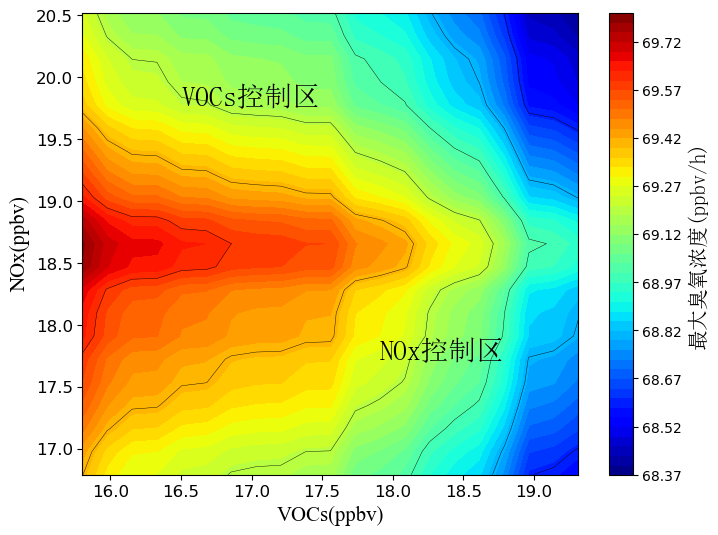

In [201]:
data = ekma1.copy()
data_2d = data.set_index(['NOx','VOCs'])
data_2d = data_2d.unstack()['MaxO3']
Z = np.array(data_2d)
# Z.shape

X = np.array(data['VOCs'])
X = np.reshape(X,(21,21))
# X

Y = np.array(data['NOx'])
Y = np.reshape(Y,(21,21))

levels = np.linspace(Z.min(), Z.max(), 10)

fig,ax = plt.subplots(figsize=(8,6))
cf = ax.contourf(X,Y,Z,cmap='jet',levels=50)
cr = ax.contour(X,Y,Z,colors='black',levels=8,linewidths=0.3)

ind_max = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
ind_min = np.unravel_index(np.argmin(Z, axis=None), Z.shape)


# ax.plot((VOCs_mean*0.1,X[ind_max]),(NOx_mean*0.1,Y[ind_max]),color='black')
# ax.plot((X[ind_min],X[ind_max]),(X[ind_min],Y[ind_max]),color='black')


# ax.scatter(VOCs_mean,NOx_mean,marker='o',c='black')
font_lg = fm.FontProperties(family='Times New Roman',size=15)
font_cb = fm.FontProperties(family='Simsun',size=15)
font_lb = fm.FontProperties(family='Simsun',size=20)

# font_cb = fm.FontProperties(family='Microsoft Yahei',size=13)

# ax.text(VOCs_mean,NOx_mean,'均值',fontproperties=font_lb)


ax.set_ylabel('NOx(ppbv)',fontproperties=font_lg)
ax.set_xlabel('VOCs(ppbv)',fontproperties=font_lg)
ax.tick_params(axis='both',labelsize=12)
cb = plt.colorbar(cf)
cb.set_label('最大臭氧浓度(ppbv/h)',fontproperties=font_cb)

trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
ax.text(0.2,0.8,'VOCs控制区',fontproperties=font_lb,transform=trans)
ax.text(0.6,0.25,'NOx控制区',fontproperties=font_lb,transform=trans)
# ax.set_title(case)
# plt.savefig(r'D:\Desktop\淄博\工作成果\VOCs案例库\OBM数据\EKMA\figure\MAXO3\%s.png'%case,dpi=400,bbox_inches='tight')
plt.show()

# 8 案例库典型案例分析

## 8.1 导入数据

In [ ]:
VOCs = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
VOCs

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,对乙基甲苯,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷
0,2019-01-01 00:00:00,东孙边界站,NaN,6.68,NaN,0.15,4.85,0.23,1.06,0.20,...,NaN,1.45,NaN,1.13,NaN,NaN,NaN,0.60,NaN,NaN
1,2019-01-01 01:00:00,东孙边界站,NaN,6.41,NaN,0.17,5.97,0.29,4.88,0.10,...,1.23,1.29,3.92,1.13,NaN,NaN,NaN,0.60,NaN,NaN
2,2019-01-01 02:00:00,东孙边界站,NaN,6.65,NaN,NaN,0.52,0.26,5.99,0.15,...,NaN,1.40,3.81,NaN,NaN,1.72,NaN,0.36,NaN,5.09
3,2019-01-01 03:00:00,东孙边界站,NaN,NaN,NaN,NaN,5.76,0.44,5.52,0.18,...,NaN,1.34,0.43,1.13,1.18,1.52,NaN,0.42,NaN,4.18
4,2019-01-01 04:00:00,东孙边界站,NaN,NaN,0.18,0.23,7.03,0.16,1.10,0.13,...,NaN,1.34,NaN,NaN,NaN,1.72,NaN,0.36,NaN,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578683,2021-12-31 19:00:00,鲁山,4.85,NaN,3.41,0.62,1.04,0.93,0.00,0.03,...,0.00,0.00,0.32,0.00,0.00,0.00,0.06,NaN,0.0,0.00
578684,2021-12-31 20:00:00,鲁山,3.26,2.79,2.17,0.34,0.86,0.47,0.00,0.03,...,0.00,0.00,0.27,0.00,0.00,0.00,0.06,NaN,0.0,0.00
578685,2021-12-31 21:00:00,鲁山,3.36,2.99,2.34,0.26,0.91,1.43,0.00,0.00,...,0.00,0.00,0.21,0.00,0.00,0.00,0.11,NaN,0.0,0.00
578686,2021-12-31 22:00:00,鲁山,3.21,2.61,2.28,0.24,0.23,1.32,0.93,0.00,...,0.00,0.00,0.05,0.00,0.00,0.00,0.06,0.11,0.0,0.00


## 8.2 选取站点

In [ ]:
data = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data = data['区县'].apply(lambda x:x)
data = data.loc[data['站点名称'].isin(site_sp.keys())]
data = data.set_index(['时间','站点名称'])
# data = cal_vconc(data)
data = data.reset_index()
# data = data.merge(aqData,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
# data = match_site(data,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data['站点名称'] = data['站点名称'].apply(lambda x:site_sp[x])
data

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,对乙基甲苯,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷
0,2019-01-01 00:00:00,周村区,NaN,11.66,NaN,NaN,NaN,NaN,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,周村区,NaN,12.01,NaN,NaN,NaN,NaN,NaN,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,周村区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236731,2021-12-31 19:00:00,背景站,4.85,NaN,3.41,0.62,1.04,0.93,0.00,0.03,...,0.0,0.0,0.32,0.0,0.0,0.0,0.06,NaN,0.0,0.0
236732,2021-12-31 20:00:00,背景站,3.26,2.79,2.17,0.34,0.86,0.47,0.00,0.03,...,0.0,0.0,0.27,0.0,0.0,0.0,0.06,NaN,0.0,0.0
236733,2021-12-31 21:00:00,背景站,3.36,2.99,2.34,0.26,0.91,1.43,0.00,0.00,...,0.0,0.0,0.21,0.0,0.0,0.0,0.11,NaN,0.0,0.0
236734,2021-12-31 22:00:00,背景站,3.21,2.61,2.28,0.24,0.23,1.32,0.93,0.00,...,0.0,0.0,0.05,0.0,0.0,0.0,0.06,0.11,0.0,0.0


## 7.3 提取典型案例数据

In [ ]:
dateperiod = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\VOCs案例库\臭氧污染案例日期0223.csv',encoding='utf_8_sig',parse_dates=['开始时间','结束时间'])
episodeDate = dateperiod.loc[dateperiod['命名'].isin(['2021-8','2020-1','2021-4'])]
episodes = pd.DataFrame()
data1 = data.set_index(['时间'])
# data1 = VOCs.set_index(['时间'])

for irow,row in episodeDate.iterrows():
    # print(row['开始时间'].strftime('%Y-%m-%d 00:00:00'))
    episode = data1.loc[row['开始时间'].strftime('%Y-%m-%d 00:00:00'):row['结束时间'].strftime('%Y-%m-%d 23:00:00')]
    episode['命名'] = row['命名']
    episodes = episodes.append(episode)
episodes = episodes.reset_index()
episodes

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,"1,3,5-三甲基苯","1,2,4-三甲基苯","1,2,3-三甲基苯",邻乙基甲苯,正癸烷,间二乙基苯,对二乙基苯,十一烷,十二烷,命名
0,2020-04-28 00:00:00,周村区,2.30,3.52,2.26,4.81,NaN,5.16,1.58,NaN,...,0.54,1.29,0.32,0.75,0.95,0.48,0.18,1.25,1.90,2020-1
1,2020-04-28 01:00:00,周村区,2.30,3.52,2.26,4.81,NaN,5.16,1.58,NaN,...,0.43,1.18,0.38,0.59,0.83,0.72,0.24,1.18,1.90,2020-1
2,2020-04-28 02:00:00,周村区,2.30,3.52,2.26,4.81,NaN,5.16,1.58,NaN,...,0.48,1.07,0.27,0.54,0.70,0.60,0.18,0.98,1.98,2020-1
3,2020-04-28 03:00:00,周村区,2.30,3.52,2.26,4.81,NaN,5.16,1.58,NaN,...,0.54,1.07,0.21,0.54,0.83,0.72,0.24,1.12,1.75,2020-1
4,2020-04-28 04:00:00,周村区,2.30,3.52,2.26,4.81,NaN,5.16,1.58,NaN,...,0.21,0.97,0.27,0.48,0.51,0.66,0.18,0.91,1.67,2020-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,2021-08-19 19:00:00,背景站,3.17,0.79,1.69,0.23,0.62,1.12,1.49,0.0,...,0.00,0.21,0.00,0.00,0.00,0.00,0.06,0.00,0.00,2021-8
4532,2021-08-19 20:00:00,背景站,3.24,0.84,2.09,0.23,0.83,1.56,1.20,0.0,...,0.00,0.21,0.00,0.00,0.00,0.17,0.06,0.00,0.00,2021-8
4533,2021-08-19 21:00:00,背景站,3.21,0.96,2.52,0.19,0.80,2.72,1.80,0.0,...,0.00,0.27,0.00,0.00,0.00,0.11,0.00,0.00,0.00,2021-8
4534,2021-08-19 22:00:00,背景站,3.54,1.14,3.29,0.24,1.01,3.42,1.91,0.0,...,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021-8


## 7.4 案例分析

### 7.4.1 案例间比较

OFP和浓度分析

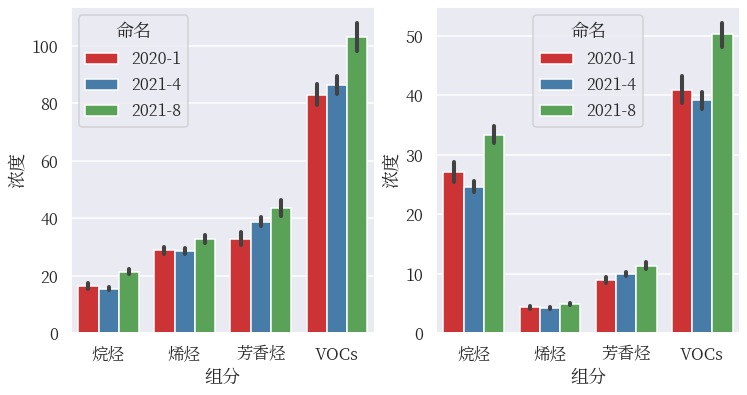

In [ ]:
# episode1 = episodes.loc[episodes['命名']=='2020-1']
episode1 = episodes.copy()
episode1 = episode1.groupby(['命名','时间']).mean()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')

episodeCONC = episode1.copy()
episodeCONC = cal_group(episodeCONC)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
sns.set(context='talk')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.barplot(data = episodeOFP,x='组分',y='浓度',hue='命名',ax=ax[0],palette='Set1')
sns.barplot(data = episodeCONC,x='组分',y='浓度',hue='命名',ax=ax[1],palette='Set1')
plt.show()

化学过程分析

No handles with labels found to put in legend.


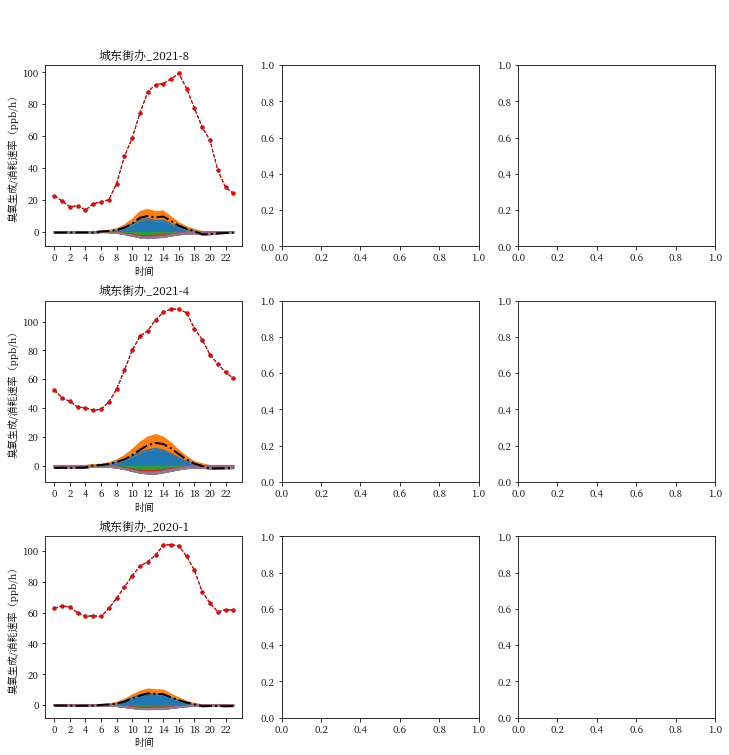

In [5]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfonts import use_font

dir = r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results'
sitenames = [
            '城东街办',
            #  '房镇镇',
            #  '田镇街办',
             ]
episodes = [
            '2021-8',
            '2021-4',
            '2020-1',
            ]

plt.rcParams.update({'mathtext.default':  'regular' })
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(3,3,figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
num = 0

for sitename in sitenames:
    for episode in episodes:
    
        episodePA = pd.read_csv('%s\PA_%s_%s.csv'%(dir,sitename,episode),encoding='GBK')
        episodePA = episodePA.set_index('HOUR')
        episodePA = episodePA.drop(['Alkenes+NO3---','Alkenes+O3---'],axis=1)
        rename = {
            'HO2 + NO = OH + NO2':'$HO_2 + NO$',
            'RO2+NO---':'$RO_2 + NO$',
            'OH + NO2 = HNO3':'$OH + NO_2$',
            'RO2+NO2':'$RO_2 + NO_2$',
            'O1D = OH + OH':'$O^1D + H_2O$',
            # 'Alkenes+O3---':'$Alkenes + O_3$',
            # 'Alkenes+NO3---':'$Alkenes + NO_3$',
            'Alkenes+O3/NO3---':'$Alkenes + O_3/NO_3$',
            'HO2 + O3 = OH':'$HO_2 + O_3$',
            'OH + O3 = HO2':'$OH + O_3$',
                }
        episodePA = episodePA.rename(columns=rename)
        # episodePA.iloc[:,-8:].plot(kind='area',ax=ax[num%3,num//3],legend=False)
        episodePA[rename.values()].plot(kind='area',ax=ax[num%3,num//3],legend=False)

        ax[num%3,num//3].plot(episodePA.index,episodePA['chem'],color='k',ls='-.',linewidth=2,label='臭氧净生成速率')
        ax[num%3,num//3].plot(episodePA.index,episodePA['obs_O3'],color='k',ls='--',marker='o',linewidth=1,markersize=3,label='obs')
        ax[num%3,num//3].plot(episodePA.index,episodePA['mod_O3'],color='red',ls='--',marker='o',linewidth=1,markersize=3,label='mod')
        ax[num%3,num//3].set_ylabel('臭氧生成/消耗速率（ppb/h）')
        # ax[num%3,num//3].set_ylim(-5,110)
        # ax[num%3,num//3].set_ylim(-5,25)
        ax[num%3,num//3].set_xticks(np.arange(0,24,2))
        ax[num%3,num//3].set_xlabel('时间')
        ax[num%3,num//3].set_title(episodePA.Var10[0])
        num = num + 1
ax[0,1].legend(loc='upper center',bbox_to_anchor=(0.5,1.35),ncol=5,frameon=False)
plt.savefig(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results\PA.png',dpi=300,bbox_inches='tight')

总过程分析

No handles with labels found to put in legend.


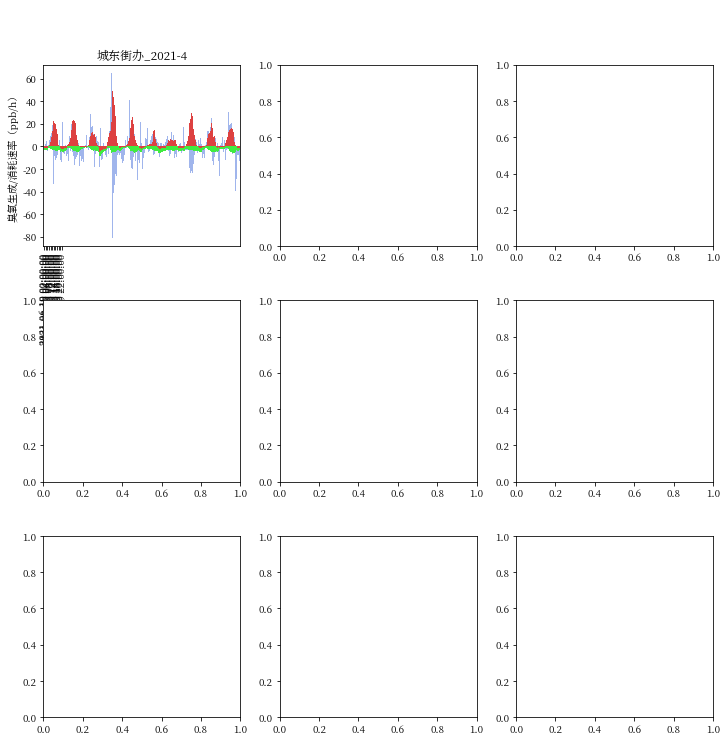

In [37]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfonts import use_font

dir = r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results'
sitenames = [
            '城东街办',
            #  '房镇镇',
            #  '田镇街办',
             ]
episodes = {
            # '2021-8':['2021-08-15 00:00:00','2021-08-19 23:00:00'],
            '2021-4':['2021-06-19 00:00:00','2021-06-28 23:00:00'],
            # '2020-1':['2020-04-28 00:00:00','2020-05-03 23:00:00'],
        }

plt.rcParams.update({'mathtext.default':  'regular' })
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(3,3,figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
num = 0

for sitename in sitenames:
    for episode in episodes.keys():
        if (episode == '2020-1')&(sitename == '城东街办'):
            episodes['2020-1']=['2020-04-29 00:00:00','2020-05-03 23:00:00']
        episodePA = pd.read_csv('%s\PA_%s_%s.csv'%(dir,sitename,episode),encoding='GBK')
        
        episodePA['datetime'] = pd.date_range(start=episodes[episode][0],end=episodes[episode][1],freq='H')
        episodePA = episodePA.set_index('datetime')
        
        # print(episodePA)
        episodePA = episodePA.rename(columns={'chem':'光化学','dep':'沉降'})
        episodePA['观测增量'] = episodePA['obs_O3'].diff()
        episodePA['传输'] = episodePA['观测增量'] - episodePA['光化学'] - episodePA['沉降']
        episodePA[['光化学','沉降','传输']].plot(kind='bar',stacked=True,width=1,ax=ax[num%3,num//3],color=['#dd4141','#40eb41','#a0b5ec'],legend=False)

        ax[num%3,num//3].step(episodePA.index+pd.Timedelta(0.5,'h'),episodePA['观测增量'],color='k',linewidth=2,label='观测增量')
        ax[num%3,num//3].set_ylabel('臭氧生成/消耗速率（ppb/h）')
        # ax[num%3,num//3].set_ylim(-5,110)
        # ax[num%3,num//3].set_ylim(-5,25)
        ax[num%3,num//3].set_xticks(np.arange(0,24,2))
        ax[num%3,num//3].set_xlabel('时间')
        ax[num%3,num//3].set_title(episodePA.Var10[0])
        num = num + 1
ax[0,1].legend(loc='upper center',bbox_to_anchor=(0.5,1.35),ncol=5,frameon=False)
# plt.savefig(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results\PA.png',dpi=300,bbox_inches='tight')

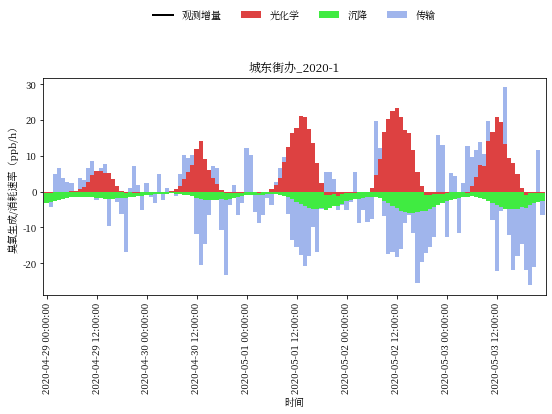

In [53]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplfonts import use_font

dir = r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results'
sitenames = [
            '城东街办',
            #  '房镇镇',
            #  '田镇街办',
             ]
episodes = {
            # '2021-8':['2021-08-15 00:00:00','2021-08-19 23:00:00'],
            '2021-4':['2021-06-19 00:00:00','2021-06-28 23:00:00'],
            '2020-1':['2020-04-28 00:00:00','2020-05-03 23:00:00'],
        }

plt.rcParams.update({'mathtext.default':  'regular' })
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
plt.subplots_adjust(hspace=0.3)
num = 0
sitename = '城东街办'
episode='2020-1'
# for sitename in sitenames:
#     for episode in episodes.keys():
if (episode == '2020-1')&(sitename == '城东街办'):
    episodes['2020-1']=['2020-04-29 00:00:00','2020-05-03 23:00:00']
episodePA = pd.read_csv('%s\PA_%s_%s.csv'%(dir,sitename,episode),encoding='GBK')

episodePA['datetime'] = pd.date_range(start=episodes[episode][0],end=episodes[episode][1],freq='H')
episodePA = episodePA.set_index('datetime')
# episodePA.index = episodePA.index.strftime('%Y/%m/d %H时')


# print(episodePA)
episodePA = episodePA.rename(columns={'chem':'光化学','dep':'沉降'})
episodePA['观测增量'] = episodePA['obs_O3'].diff()
episodePA['传输'] = episodePA['观测增量'] - episodePA['光化学'] - episodePA['沉降']
episodePA[['光化学','沉降','传输']].plot(kind='bar',stacked=True,width=1,ax=ax,color=['#dd4141','#40eb41','#a0b5ec'],legend=False)

ax.step(episodePA.index+pd.Timedelta(0.5,'h'),episodePA['观测增量'],color='k',zorder=1,linewidth=2,label='观测增量')
ax.set_ylabel('臭氧生成/消耗速率（ppb/h）')
# ax.set_ylim(-5,110)
# ax.set_ylim(-5,25)
ax.set_xticks(np.arange(0,len(episodePA),12))
ax.set_xlabel('时间')
ax.set_title(episodePA.Var10[0])
ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.35),ncol=5,frameon=False)
plt.show()
# plt.savefig(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\results\PA.png',dpi=300,bbox_inches='tight')

In [46]:
episodePA['观测增量'].describe()

count    239.000000
mean       0.021478
std       11.189762
min      -37.800000
25%       -6.066667
50%        0.000000
75%        5.600000
max       59.266667
Name: 观测增量, dtype: float64

### 7.4.2 单个案例分析

#### 7.4.2.1 污染案例类型I：“局地化学反应主导驱动”型(2021-8案例)

组分浓度变化

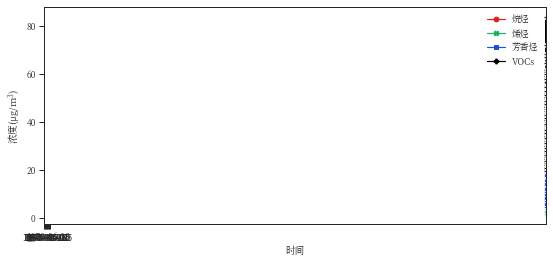

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs变化.png'%episodeName,dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分时间序列.xlsx')
# episode1

示踪物浓度变化

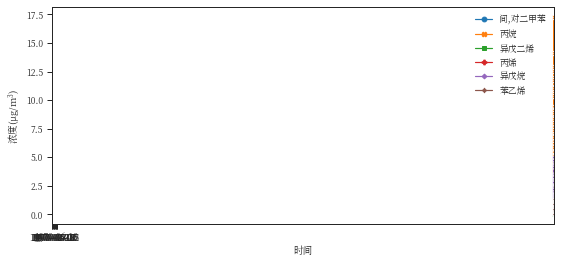

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='示踪物',style='示踪物',dashes=False,markers=True,ax=ax,palette=sns.color_palette('tab10',len(episode1['示踪物'].unique())))
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
# episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean()[['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯']].reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')
episode1.to_excel(r'D:/desktop/示踪剂时间序列.xlsx')
# episode1

VOCs日变化

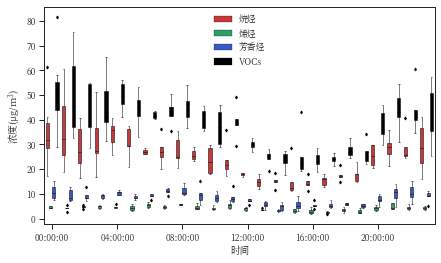

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1['时间'] = episode1['时间'].dt.strftime('%H:00:00')
# episode1['时间'] = episode1['时间'].dt.hour

sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,4))
# sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,ci='sd',err_style='bars',err_kws={'capsize':3.0,'lw':1.5},markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
sns.boxplot(data = episode1,x='时间',y='浓度',hue='组分',ax=ax,palette=['#df2020','#19b367','#204edf','black'], 
            fliersize=2,
            linewidth=0.5,           
            # showmeans=True,
            # meanprops={"marker":"o",
            # "markerfacecolor":"white", 
            # "markeredgecolor":"black",
            # "markersize":"3"},
            )
ax.set_xticks(np.arange(0,23,4))
ax.set_xlim(-0.5,23.5)
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s组分日变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]
episode1['小时'] = episode1['时间'].dt.hour
# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间','小时']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分日变化.xlsx')
# episode1

前十浓度和前十OFP

<ipython-input-93-af2a11acf40f>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: Dropping of nuisance colu

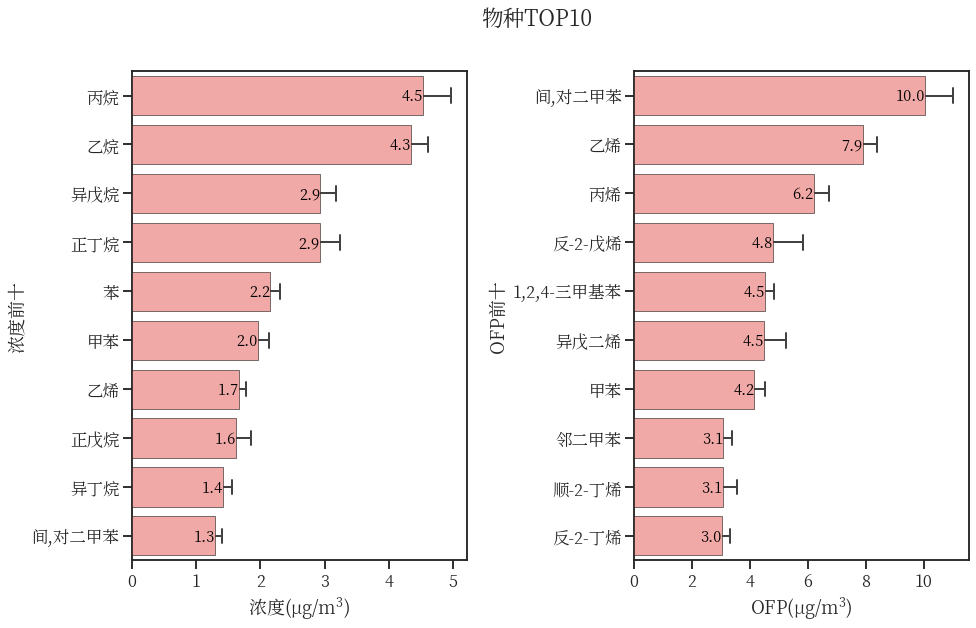

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()

episodeCONC = episode1.reset_index()
episodeCONC10 = episodeCONC.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')

episodeOFP = cal_ofp(episode1)
episodeOFP = episodeOFP.reset_index()
episodeOFP10 = episodeOFP.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')




fig,ax = plt.subplots(1,2,figsize=(15,9))
plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
# bar1 = ax[0].barh(episodeCONC10.index,episodeCONC10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
# bar2 = ax[1].barh(episodeOFP10.index,episodeOFP10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
bar1 = sns.barplot(data = episodeCONC10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[0],palette=['#fc9d9a'])
bar2 = sns.barplot(data = episodeOFP10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[1],palette=['#fc9d9a'])


ax[0] = barh_labels(ax[0],0.3,15,'center')
ax[1] = barh_labels(ax[1],0.3,15,'center')

# ax[0].set_xlim(0,max(episodeCONC10)*1.1)
# ax[1].set_xlim(0,max(episodeOFP10)*1.1)

ax[0].set_ylim(-0.5,9.5)
ax[1].set_ylim(-0.5,9.5)
ax[0].set_xlabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_xlabel('OFP(μg/$\mathregular{m^3}$)')
ax[0].set_ylabel('浓度前十')
ax[1].set_ylabel('OFP前十')
plt.suptitle('物种TOP10')
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sTOP10物种.png'%episodeName,dpi=300,bbox_inches='tight')

VOCs组分浓度与OFP

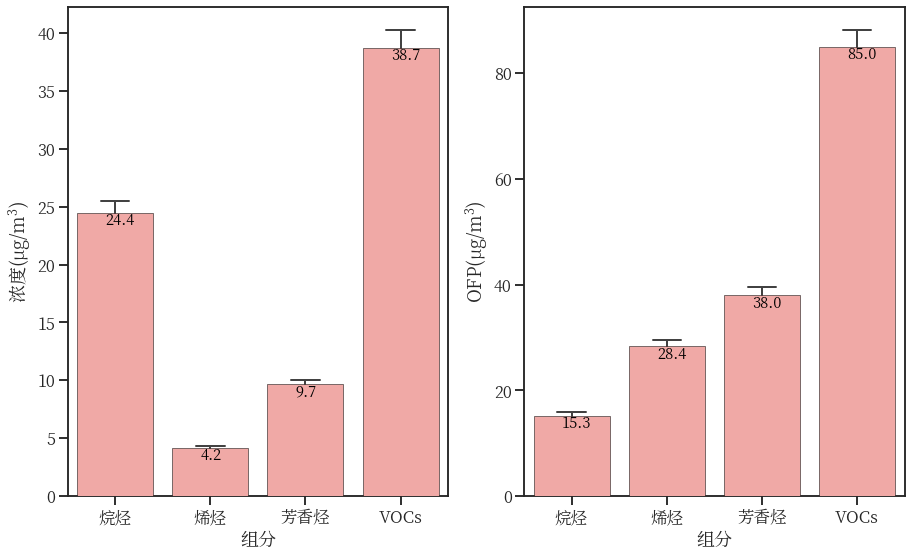

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
# episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
# episodeCONC = episodeCONC.groupby(['组分']).mean()

def bar_labels(ax,offset,fontsize,where,color='black'):
    if where=='top':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),zorder=10,fontsize=fontsize,color=color)
        return ax
    elif where=='bottom':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,0,s='{:.1f}'.format(y.get_height()),fontsize=fontsize,zorder=10,color=color)
        return ax
    elif where=='center':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),va='top',fontsize=fontsize,zorder=10,color=color)
        return ax

fig,ax = plt.subplots(1,2,figsize=(15,9))
# plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')

bars1 = sns.barplot(y='浓度',x='组分',data=episodeCONC,ec='black',lw=0.5,zorder=3,ax=ax[0],palette=['#fc9d9a'],errwidth=2,capsize=0.3)
bars2 = sns.barplot(y='浓度',x='组分',data=episodeOFP,ec='black',lw=0.5,zorder=3,ax=ax[1],palette=['#fc9d9a'],errwidth=2,capsize=0.3)

ax[0] = bar_labels(ax[0],0.3,15,'center',color='black')
ax[1] = bar_labels(ax[1],0.3,15,'center',color='black')

ax[0].set_ylabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_ylabel('OFP(μg/$\mathregular{m^3}$)')

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs组分浓度和OFP.png'%episodeName,dpi=300,bbox_inches='tight')
# episodeCONC

示踪物浓度

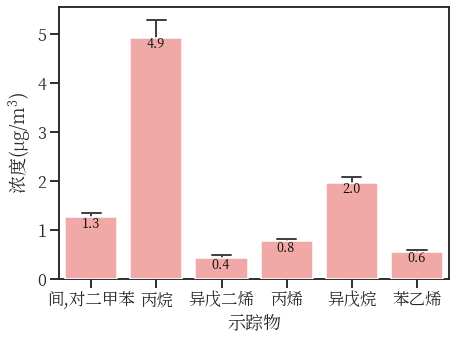

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,5))
bar = sns.barplot(data = episode1,x='示踪物',y='浓度',zorder=3,capsize=0.3,errwidth=2,ax=ax,palette=['#fc9d9a'])
ax = bar_labels(ax,0.25,13,'center',color='black')
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物浓度柱状图.png'%episodeName,dpi=300,bbox_inches='tight')

一些数值的计算

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
episodeCONC = episodeCONC.groupby(['组分']).mean()
# episodeCONC

episodeCONC10 = episode1.mean().sort_values(ascending=False).iloc[:10]
episodeOFP10 = cal_ofp(episode1)
episodeOFP10 = episodeOFP10.mean().sort_values(ascending=False).iloc[:10]
# episodeOFP10

间,对二甲苯        9.809155
乙烯            9.459157
1,2,4-三甲基苯    7.395885
丙烯            5.170083
反-2-丁烯        4.169459
甲苯            3.948302
邻二甲苯          3.626780
异戊二烯          3.398046
顺-2-丁烯        2.997397
反-2-戊烯        2.505763
dtype: float64

#### 7.4.2.2 污染案例类型II：“传输主导驱动”型(2020-1案例)

组分浓度变化

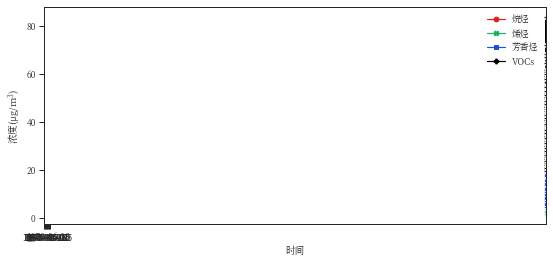

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs变化.png'%episodeName,dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分时间序列.xlsx')
# episode1

示踪物浓度变化

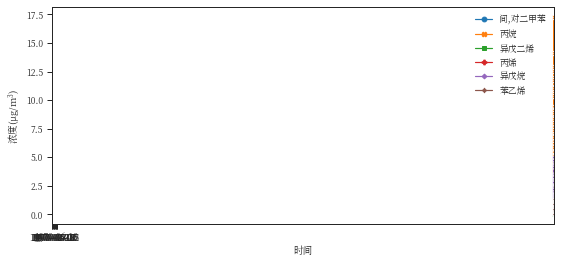

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='示踪物',style='示踪物',dashes=False,markers=True,ax=ax,palette=sns.color_palette('tab10',len(episode1['示踪物'].unique())))
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
# episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean()[['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯']].reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')
episode1.to_excel(r'D:/desktop/示踪剂时间序列.xlsx')
# episode1

VOCs日变化

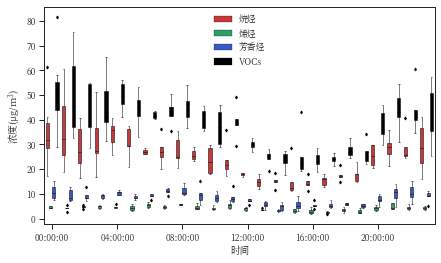

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1['时间'] = episode1['时间'].dt.strftime('%H:00:00')
# episode1['时间'] = episode1['时间'].dt.hour

sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,4))
# sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,ci='sd',err_style='bars',err_kws={'capsize':3.0,'lw':1.5},markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
sns.boxplot(data = episode1,x='时间',y='浓度',hue='组分',ax=ax,palette=['#df2020','#19b367','#204edf','black'], 
            fliersize=2,
            linewidth=0.5,           
            # showmeans=True,
            # meanprops={"marker":"o",
            # "markerfacecolor":"white", 
            # "markeredgecolor":"black",
            # "markersize":"3"},
            )
ax.set_xticks(np.arange(0,23,4))
ax.set_xlim(-0.5,23.5)
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s组分日变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]
episode1['小时'] = episode1['时间'].dt.hour
# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间','小时']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分日变化.xlsx')
# episode1

前十浓度和前十OFP

<ipython-input-93-af2a11acf40f>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: Dropping of nuisance colu

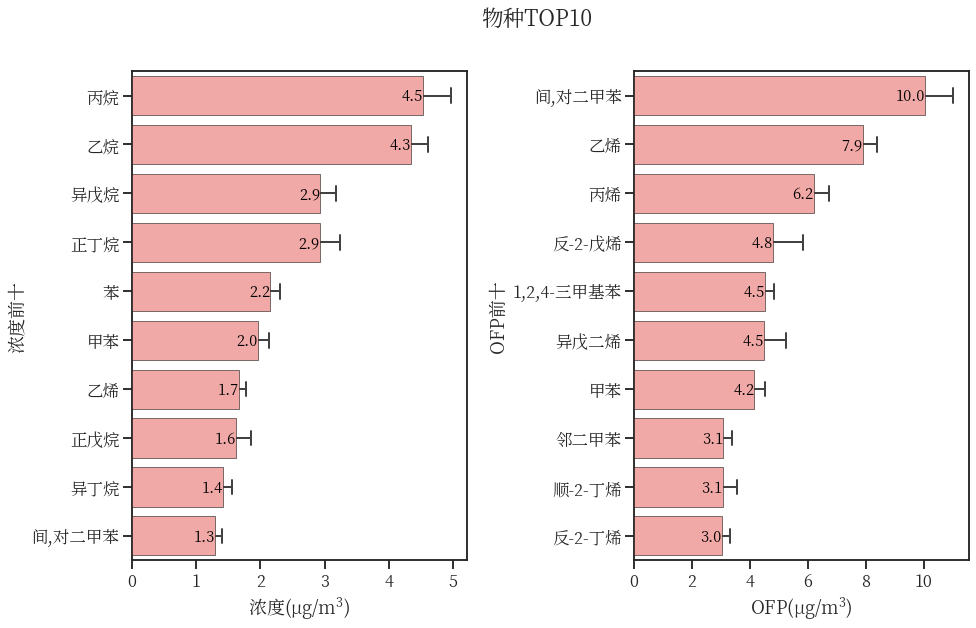

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()

episodeCONC = episode1.reset_index()
episodeCONC10 = episodeCONC.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')

episodeOFP = cal_ofp(episode1)
episodeOFP = episodeOFP.reset_index()
episodeOFP10 = episodeOFP.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')




fig,ax = plt.subplots(1,2,figsize=(15,9))
plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
# bar1 = ax[0].barh(episodeCONC10.index,episodeCONC10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
# bar2 = ax[1].barh(episodeOFP10.index,episodeOFP10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
bar1 = sns.barplot(data = episodeCONC10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[0],palette=['#fc9d9a'])
bar2 = sns.barplot(data = episodeOFP10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[1],palette=['#fc9d9a'])


ax[0] = barh_labels(ax[0],0.3,15,'center')
ax[1] = barh_labels(ax[1],0.3,15,'center')

# ax[0].set_xlim(0,max(episodeCONC10)*1.1)
# ax[1].set_xlim(0,max(episodeOFP10)*1.1)

ax[0].set_ylim(-0.5,9.5)
ax[1].set_ylim(-0.5,9.5)
ax[0].set_xlabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_xlabel('OFP(μg/$\mathregular{m^3}$)')
ax[0].set_ylabel('浓度前十')
ax[1].set_ylabel('OFP前十')
plt.suptitle('物种TOP10')
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sTOP10物种.png'%episodeName,dpi=300,bbox_inches='tight')

VOCs组分浓度与OFP

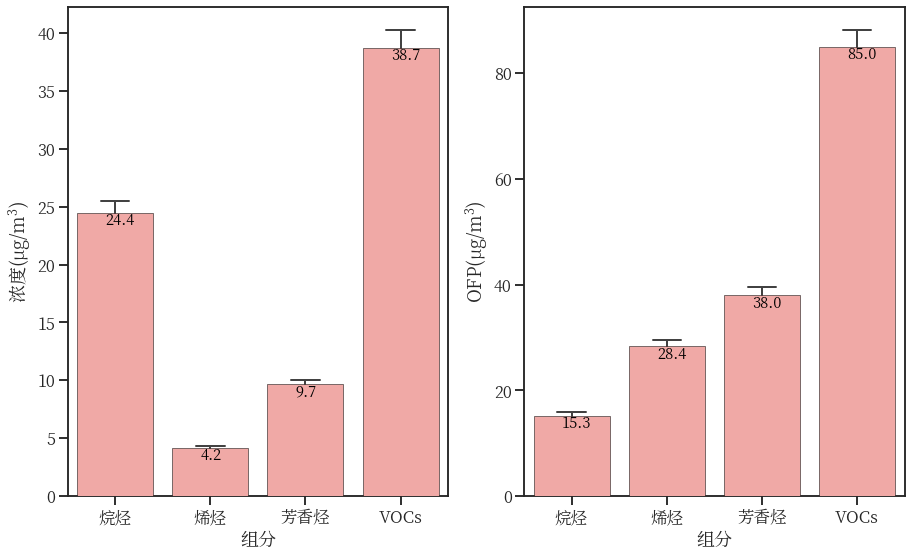

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
# episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
# episodeCONC = episodeCONC.groupby(['组分']).mean()

def bar_labels(ax,offset,fontsize,where,color='black'):
    if where=='top':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),zorder=10,fontsize=fontsize,color=color)
        return ax
    elif where=='bottom':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,0,s='{:.1f}'.format(y.get_height()),fontsize=fontsize,zorder=10,color=color)
        return ax
    elif where=='center':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),va='top',fontsize=fontsize,zorder=10,color=color)
        return ax

fig,ax = plt.subplots(1,2,figsize=(15,9))
# plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')

bars1 = sns.barplot(y='浓度',x='组分',data=episodeCONC,ec='black',lw=0.5,zorder=3,ax=ax[0],palette=['#fc9d9a'],errwidth=2,capsize=0.3)
bars2 = sns.barplot(y='浓度',x='组分',data=episodeOFP,ec='black',lw=0.5,zorder=3,ax=ax[1],palette=['#fc9d9a'],errwidth=2,capsize=0.3)

ax[0] = bar_labels(ax[0],0.3,15,'center',color='black')
ax[1] = bar_labels(ax[1],0.3,15,'center',color='black')

ax[0].set_ylabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_ylabel('OFP(μg/$\mathregular{m^3}$)')

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs组分浓度和OFP.png'%episodeName,dpi=300,bbox_inches='tight')
# episodeCONC

示踪物浓度

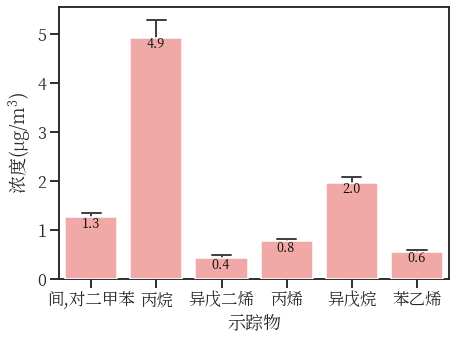

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,5))
bar = sns.barplot(data = episode1,x='示踪物',y='浓度',zorder=3,capsize=0.3,errwidth=2,ax=ax,palette=['#fc9d9a'])
ax = bar_labels(ax,0.25,13,'center',color='black')
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物浓度柱状图.png'%episodeName,dpi=300,bbox_inches='tight')

一些数值的计算

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
episodeCONC = episodeCONC.groupby(['组分']).mean()
# episodeCONC

episodeCONC10 = episode1.mean().sort_values(ascending=False).iloc[:10]
episodeOFP10 = cal_ofp(episode1)
episodeOFP10 = episodeOFP10.mean().sort_values(ascending=False).iloc[:10]
# episodeOFP10

间,对二甲苯        9.809155
乙烯            9.459157
1,2,4-三甲基苯    7.395885
丙烯            5.170083
反-2-丁烯        4.169459
甲苯            3.948302
邻二甲苯          3.626780
异戊二烯          3.398046
顺-2-丁烯        2.997397
反-2-戊烯        2.505763
dtype: float64

#### 7.4.2.3 污染案例类型III：“局地生成+传输驱动”型 (2021-4案例)

组分浓度变化

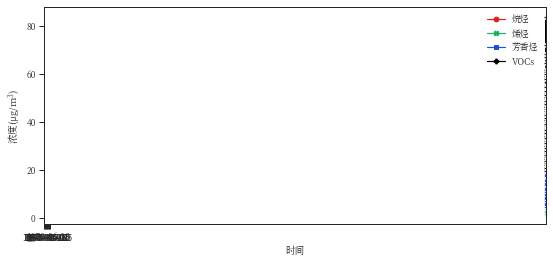

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs变化.png'%episodeName,dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分时间序列.xlsx')
# episode1

示踪物浓度变化

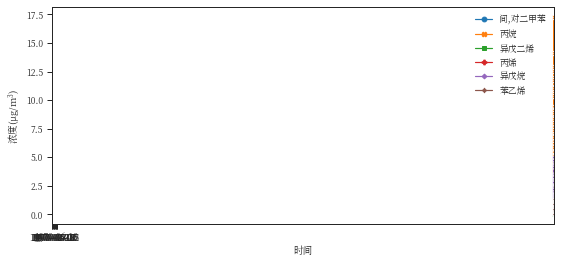

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


# episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(9,4))
sns.lineplot(data = episode1,x='时间',y='浓度',hue='示踪物',style='示踪物',dashes=False,markers=True,ax=ax,palette=sns.color_palette('tab10',len(episode1['示踪物'].unique())))
ax.set_xticks(np.arange(0,len(episode1['时间'].unique()),24))
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
plt.show()
# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
# episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean()[['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯']].reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')

# plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物变化.png'%episodeName,dpi=300,bbox_inches='tight')
episode1.to_excel(r'D:/desktop/示踪剂时间序列.xlsx')
# episode1

VOCs日变化

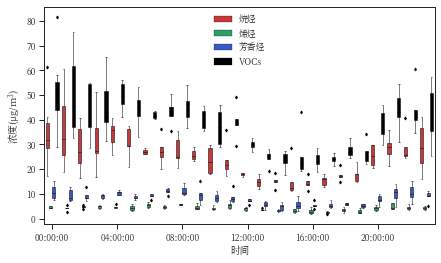

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1['时间'] = episode1['时间'].dt.strftime('%H:00:00')
# episode1['时间'] = episode1['时间'].dt.hour

sns.set(context='paper',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,4))
# sns.lineplot(data = episode1,x='时间',y='浓度',hue='组分',style='组分',dashes=False,ci='sd',err_style='bars',err_kws={'capsize':3.0,'lw':1.5},markers=True,ax=ax,palette=['#df2020','#19b367','#204edf','black'])
sns.boxplot(data = episode1,x='时间',y='浓度',hue='组分',ax=ax,palette=['#df2020','#19b367','#204edf','black'], 
            fliersize=2,
            linewidth=0.5,           
            # showmeans=True,
            # meanprops={"marker":"o",
            # "markerfacecolor":"white", 
            # "markeredgecolor":"black",
            # "markersize":"3"},
            )
ax.set_xticks(np.arange(0,23,4))
ax.set_xlim(-0.5,23.5)
ax.legend(frameon=False)
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s组分日变化.png'%episodeName,dpi=300,bbox_inches='tight')

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名'].isin(['2020-1','2021-8','2021-4'])]
episode1['小时'] = episode1['时间'].dt.hour
# episode1 = episodes.copy()
episode1 = cal_group(episode1.groupby(['命名','时间','小时']).mean())
episode1 = episode1.reset_index()
# episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episode1.to_excel(r'D:/desktop/组分日变化.xlsx')
# episode1

前十浓度和前十OFP

<ipython-input-93-af2a11acf40f>:22: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
<ipython-input-93-af2a11acf40f>:25: FutureWarning: Dropping of nuisance colu

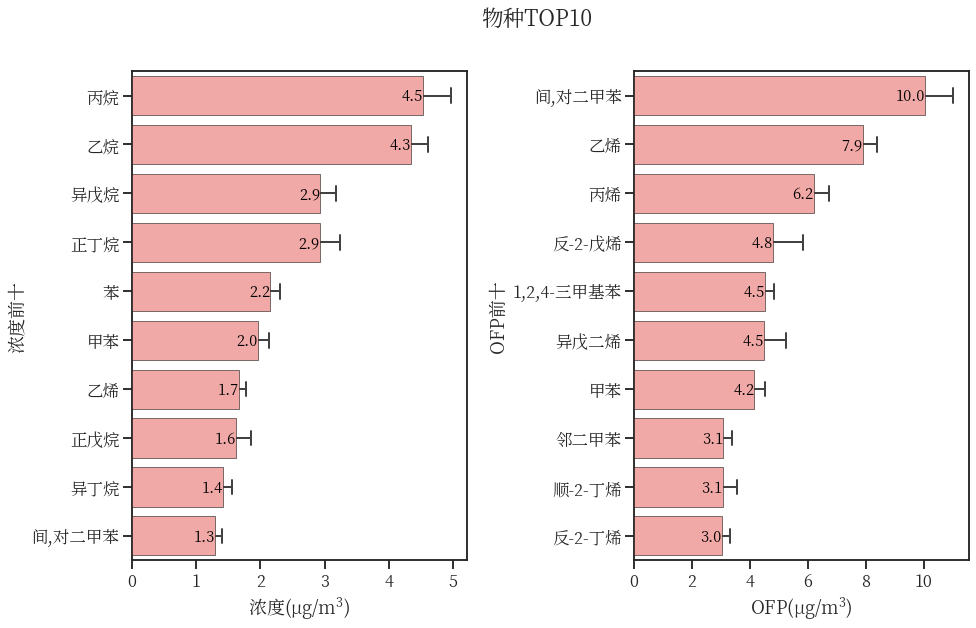

In [ ]:
episodeName = '2020-1'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()

episodeCONC = episode1.reset_index()
episodeCONC10 = episodeCONC.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')

episodeOFP = cal_ofp(episode1)
episodeOFP = episodeOFP.reset_index()
episodeOFP10 = episodeOFP.melt(id_vars=['命名','时间'],value_vars=episode1.columns,value_name='浓度',var_name='物种')




fig,ax = plt.subplots(1,2,figsize=(15,9))
plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
# bar1 = ax[0].barh(episodeCONC10.index,episodeCONC10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
# bar2 = ax[1].barh(episodeOFP10.index,episodeOFP10,color='#fc9d9a',edgecolor='black',linewidth=0.5)
bar1 = sns.barplot(data = episodeCONC10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeCONC.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[0],palette=['#fc9d9a'])
bar2 = sns.barplot(data = episodeOFP10,x='浓度',y='物种',lw=0.5,ec='black',
                    order=episodeOFP.mean().sort_values(ascending=True).iloc[-10:].index,zorder=3,capsize=0.3,errwidth=2,
                    ax=ax[1],palette=['#fc9d9a'])


ax[0] = barh_labels(ax[0],0.3,15,'center')
ax[1] = barh_labels(ax[1],0.3,15,'center')

# ax[0].set_xlim(0,max(episodeCONC10)*1.1)
# ax[1].set_xlim(0,max(episodeOFP10)*1.1)

ax[0].set_ylim(-0.5,9.5)
ax[1].set_ylim(-0.5,9.5)
ax[0].set_xlabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_xlabel('OFP(μg/$\mathregular{m^3}$)')
ax[0].set_ylabel('浓度前十')
ax[1].set_ylabel('OFP前十')
plt.suptitle('物种TOP10')
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sTOP10物种.png'%episodeName,dpi=300,bbox_inches='tight')

VOCs组分浓度与OFP

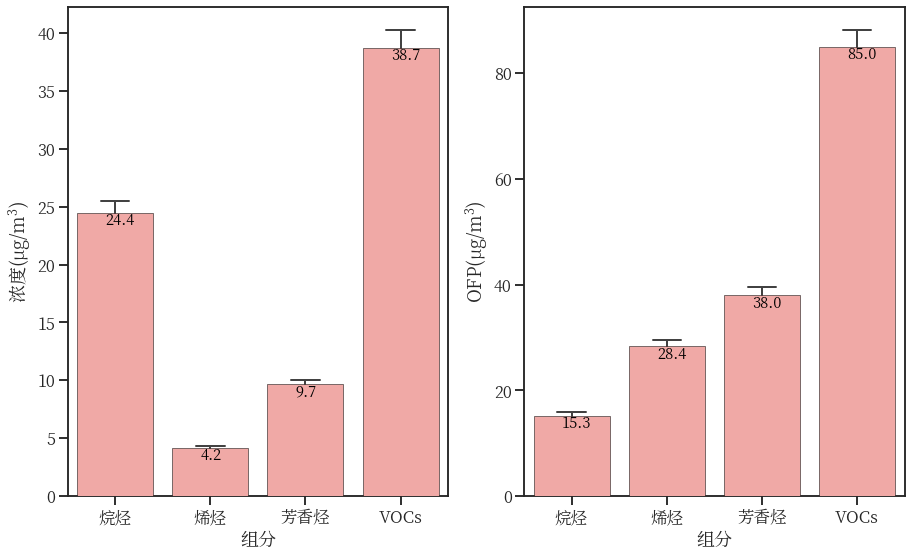

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
# episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
# episodeCONC = episodeCONC.groupby(['组分']).mean()

def bar_labels(ax,offset,fontsize,where,color='black'):
    if where=='top':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),zorder=10,fontsize=fontsize,color=color)
        return ax
    elif where=='bottom':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,0,s='{:.1f}'.format(y.get_height()),fontsize=fontsize,zorder=10,color=color)
        return ax
    elif where=='center':
        for x in ax.containers:
            for y in x.get_children():
                ax.text(y.xy[0]+offset,y.get_height(),s='{:.1f}'.format(y.get_height()),va='top',fontsize=fontsize,zorder=10,color=color)
        return ax

fig,ax = plt.subplots(1,2,figsize=(15,9))
# plt.subplots_adjust(wspace=0.5)
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')

bars1 = sns.barplot(y='浓度',x='组分',data=episodeCONC,ec='black',lw=0.5,zorder=3,ax=ax[0],palette=['#fc9d9a'],errwidth=2,capsize=0.3)
bars2 = sns.barplot(y='浓度',x='组分',data=episodeOFP,ec='black',lw=0.5,zorder=3,ax=ax[1],palette=['#fc9d9a'],errwidth=2,capsize=0.3)

ax[0] = bar_labels(ax[0],0.3,15,'center',color='black')
ax[1] = bar_labels(ax[1],0.3,15,'center',color='black')

ax[0].set_ylabel('浓度(μg/$\mathregular{m^3}$)')
ax[1].set_ylabel('OFP(μg/$\mathregular{m^3}$)')

plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%sVOCs组分浓度和OFP.png'%episodeName,dpi=300,bbox_inches='tight')
# episodeCONC

示踪物浓度

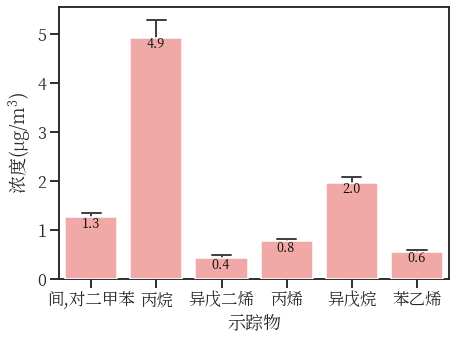

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]

# episode1 = episodes.copy()
# episode1 = cal_group(episode1.groupby(['命名','时间']).mean())
episode1 = episode1.reset_index()
# episode1['甲苯/苯'] = episode1['甲苯']/episode1['苯']
episode1 = episode1.groupby(['时间','命名']).mean().reset_index()
episode1 = episode1.melt(id_vars=['命名','时间'],value_vars=['间,对二甲苯','丙烷','异戊二烯','丙烯','异戊烷','苯乙烯'],value_name='浓度',var_name='示踪物')
# episode1 = episode1.pivot_table(index=['命名','时间'],columns='组分',values='浓度')


episode1['时间'] = episode1['时间'].dt.strftime('%m/%d %H时')
sns.set(context='talk',style='ticks')
use_font('Noto Serif CJK SC')
fig,ax = plt.subplots(figsize=(7,5))
bar = sns.barplot(data = episode1,x='示踪物',y='浓度',zorder=3,capsize=0.3,errwidth=2,ax=ax,palette=['#fc9d9a'])
ax = bar_labels(ax,0.25,13,'center',color='black')
ax.set_ylabel('浓度(μg/$\mathregular{m^3}$)')
# plt.show()
plt.savefig(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\2019-2021淄博市VOCs分析报告\图2\案例分析之%s示踪物浓度柱状图.png'%episodeName,dpi=300,bbox_inches='tight')

一些数值的计算

In [ ]:
episodeName = '2021-4'
episode1 = episodes.loc[episodes['命名']==episodeName]
episode1 = episode1.groupby(['命名','时间']).mean()
# episode1 = episodes.copy()
episodeOFP = cal_ofp(episode1)
episodeOFP = cal_group(episodeOFP)
episodeOFP = episodeOFP.reset_index()
episodeOFP = episodeOFP.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeOFP['时间'] = episodeOFP['时间'].dt.strftime('%m/%d %H时')
episodeOFP = episodeOFP.groupby(['组分']).mean()

# episodeCONC = cal_ofp(episode1)
episodeCONC = cal_group(episode1)
episodeCONC = episodeCONC.reset_index()
episodeCONC = episodeCONC.melt(id_vars=['命名','时间'],value_vars=['烷烃','烯烃','芳香烃','VOCs'],value_name='浓度',var_name='组分')
episodeCONC['时间'] = episodeCONC['时间'].dt.strftime('%m/%d %H时')
episodeCONC = episodeCONC.groupby(['组分']).mean()
# episodeCONC

episodeCONC10 = episode1.mean().sort_values(ascending=False).iloc[:10]
episodeOFP10 = cal_ofp(episode1)
episodeOFP10 = episodeOFP10.mean().sort_values(ascending=False).iloc[:10]
# episodeOFP10

间,对二甲苯        9.809155
乙烯            9.459157
1,2,4-三甲基苯    7.395885
丙烯            5.170083
反-2-丁烯        4.169459
甲苯            3.948302
邻二甲苯          3.626780
异戊二烯          3.398046
顺-2-丁烯        2.997397
反-2-戊烯        2.505763
dtype: float64

## 7.5 OBM分析

### 7.5.1 准备OBM数据

In [1]:
sys.path.append(r'D:\Desktop\codes\python codes\淄博')
from ZiboV2 import VOCzb as Zb
from Zibo import *
# norm = pd.read_csv(r'D:\Desktop\上海大学工作成果汇总\淄博项目工作成果\镇办空气质量数据\2018-2021镇办空气质量数据_清洗后.csv',parse_dates=['时间'])
norm = pd.read_excel(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\三镇办空气质量数据.xlsx',parse_dates=['时间'])

VOCs = pd.read_csv(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])

d:\Users\xuejin\anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
data_obm = VOCs.copy()
site_sp = {
            '房镇镇':'张店区',
            '城区街办':'桓台县',
            '田镇街办':'高青县',
            '北郊镇':'周村区',
            '松龄路街办':'淄川区',
            '闻韶街办':'临淄区',
            '历山街办':'沂源县',
            '城东街办':'博山区',
            '鲁山':'背景站',
            }
# data_obm = data_obm['区县'].apply(lambda x:x)
data_obm = data_obm.loc[data_obm['站点名称'].isin(site_sp.keys())]
data_obm = data_obm.set_index(['时间','站点名称'])
data_obm = cal_vconc(data_obm)
data_obm = data_obm.reset_index()
data_obm = data_obm.merge(norm,left_on=['站点名称','时间'],right_on=['站点名称','时间'])
data_obm = match_site(data_obm,columnname='站点名称',matchlist=['区县','经度','纬度'],paper=True)
data_obm

,时间,站点名称,乙烷,乙烯,丙烷,丙烯,异丁烷,正丁烷,乙炔,反-2-丁烯,...,氮氧化物,一氧化碳,O31,能见度,风速,气温,湿度,区县,经度,纬度
0,2019-01-01 00:00:00,城东街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,1.1,15.0,10.8,0.5,-5.6,54.0,博山区,117.896062,36.522327
1,2019-01-01 01:00:00,城东街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,1.1,9.0,9.2,0.4,-6.4,58.0,博山区,117.896062,36.522327
2,2019-01-01 02:00:00,城东街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.0,1.1,1.0,8.6,0.6,-7.0,62.0,博山区,117.896062,36.522327
3,2019-01-01 03:00:00,城东街办,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,108.0,1.2,1.0,8.4,0.6,-7.6,64.0,博山区,117.896062,36.522327
4,2019-01-01 04:00:00,城东街办,0.000000,0.167701,0.000000,0.010646,0.000000,0.000000,0.0,0.000000,...,132.0,1.3,1.0,7.4,0.4,-8.1,66.0,博山区,117.896062,36.522327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76960,2021-12-31 19:00:00,田镇街办,9.259461,NaN,6.400000,0.074525,0.019270,0.123331,0.0,0.091820,...,216.0,1.5,9.0,NaN,NaN,NaN,NaN,高青县,117.815426,37.170874
76961,2021-12-31 20:00:00,田镇街办,14.027004,NaN,10.910476,0.244867,3.750034,0.053957,0.0,NaN,...,195.0,1.6,9.0,NaN,NaN,NaN,NaN,高青县,117.815426,37.170874
76962,2021-12-31 21:00:00,田镇街办,19.159561,NaN,20.617143,0.149049,4.628768,0.701445,0.0,NaN,...,198.0,1.6,9.0,NaN,NaN,NaN,NaN,高青县,117.815426,37.170874
76963,2021-12-31 22:00:00,田镇街办,NaN,NaN,NaN,0.143726,0.158018,0.181142,0.0,0.135733,...,148.0,1.6,9.0,NaN,NaN,NaN,NaN,高青县,117.815426,37.170874


In [5]:
data_obm1 = data_obm.set_index('时间')
data_obm1.index.name = 'time'
data_obm1['month'] = data_obm1.index.month
data_obm1['year'] = data_obm1.index.year
data_obm1['HOUR'] = data_obm1.index.hour
# data_obm1 = data_obm1.loc[(data_obm1.index.month>4)&(data_obm1.index.month<10)]
data_obm2 = data_obm1.loc[data_obm1['站点名称']!='鲁山']
data_obm_bkg = data_obm1.loc[data_obm1['站点名称']=='鲁山']
data_obm_bkg['区县'] = '背景站'
data_obm3 = data_obm2.append(data_obm_bkg)
db = pd.read_csv(r'D:\Desktop\codes\python codes\淄博\basefile\镇办站物种转化信息库.csv',encoding='utf_8_sig')
db = db.set_index('species_name')
db = db[['OBMname']].to_dict('index')
db = {key:item['OBMname'] for key,item in db.items()}
data_obm3 = data_obm3.rename(columns=db)
data_obm3 = data_obm3.rename(columns={'O31':'O3','一氧化碳':'CO','湿度':'RH','气温':'T','经度':'LON','纬度':'LAT','区县':'sitename'})
data_obm3['O3'] = data_obm3['O3']/48*22.4
data_obm3['CO'] = data_obm3['CO']/28*22.4*1000
data_obm3['NO2'] = data_obm3['NO2']/46*22.4
data_obm3['NO'] = data_obm3['NO']/30*22.4
data_obm3 = data_obm3.loc[data_obm3['站点名称'].isin(['田镇街办','房镇镇','城东街办'])]

dateperiod = pd.read_csv(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\臭氧污染案例日期0223.csv',encoding='utf_8_sig',parse_dates=['开始时间','结束时间'])
episodeDate = dateperiod.loc[dateperiod['命名'].isin(['2021-8','2020-1','2021-4'])]

obm_fin = pd.DataFrame()
for irow,row in episodeDate.iterrows():
    episode = data_obm3.loc[row['开始时间'].strftime('%Y-%m-%d 00:00:00'):row['结束时间'].strftime('%Y-%m-%d 23:00:00')]
    episode['案例编号'] = row['命名']
    obm_fin = obm_fin.append(episode)

obm_fin = obm_fin.reset_index()
obm_fin = obm_fin.drop(columns=[ '能见度','sitename'],axis=1)
for key,group in obm_fin.groupby(['案例编号','站点名称']):
    group = group.set_index(['案例编号','站点名称','time'])
    # print(group.info().head())
    # print(group.info().tail())

    group = group.interpolate('linear')
    group = group.reset_index()
    # group = group.groupby(group['time'].dt.hour).mean().reset_index()
    group.to_excel(r'D:\Desktop\OneDrive - shu.edu.cn\工作资料\淄博项目工作成果\2019-2021淄博市VOCs分析报告\VOCs案例库\典型案例分析\PA\%s_%s.xlsx'%(key[1],key[0]))

C:\Users\xuejin\AppData\Local\Temp\ipykernel_21424\1716998653.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_obm3 = data_obm2.append(data_obm_bkg)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_21424\1716998653.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obm_fin = obm_fin.append(episode)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_21424\1716998653.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obm_fin = obm_fin.append(episode)
C:\Users\xuejin\AppData\Local\Temp\ipykernel_21424\1716998653.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  obm_fin = obm_fin.append(episode)


In [15]:
obm_fin.columns

Index([     'time',      '站点名称',      'C2H6',      'C2H4',      'C3H8',
            'C3H6',    'IC4H10',    'NC4H10',      'C2H2',  'TBUT2ENE',
         'BUT1ENE',  'CBUT2ENE',         nan,    'IC5H12',    'NC5H12',
       'TPENT2ENE',  'PENT1ENE', 'CPENT2ENE',     'M22C4',     'M23C4',
            'M2PE',      'M3PE',      'C5H8',    'NC6H14',   'HEX1ENE',
               nan,         nan,   'BENZENE',      'CHEX',     'M2HEX',
               nan,     'M3HEX',         nan,    'NC7H16',         nan,
               nan,   'TOLUENE',         nan,         nan,    'NC8H18',
           'EBENZ',      'MXYL',   'STYRENE',      'OXYL',    'NC9H20',
          'IPBENZ',     'PBENZ',   'METHTOL',   'PETHTOL',    'TM135B',
          'TM124B',    'TM123B',   'OETHTOL',   'NC10H22',         nan,
               nan,   'NC11H24',   'NC12H26',      'PM10',     'PM2.5',
            '二氧化硫',       'NO2',        'NO',      '氮氧化物',        'CO',
             'O31',       '能见度',        '风速',         'T',      

# 翻译相关

## 百度翻译

In [ ]:
import hashlib
import random
import openpyxl
from openpyxl import Workbook
import requests
import time
apiurl = 'http://api.fanyi.baidu.com/api/trans/vip/translate'
appid = '20220319001131139'
# appid = '25869061'

secretKey = 'fzbwY2loWnEqoRcBajAr'
# secretKey = 'RpuwRSNw4DOMs1LDFHF5lFOtBPusAla4'


def translateBaidu(content, fromLang='en', toLang='zh'):
    salt = str(random.randint(32768, 65536))
    sign = appid + content + salt + secretKey
    sign = hashlib.md5(sign.encode("utf-8")).hexdigest()

    try:
        paramas = {
            'appid': appid,
            'q': content,
            'from': fromLang,
            'to': toLang,
            'salt': salt,
            'sign': sign
        }
        response = requests.get(apiurl, paramas)
        jsonResponse = response.json()  
        dst = str(jsonResponse["trans_result"]
                  [0]["dst"]) 
        return dst
    except Exception as e:
        print(e)

## 彩云小译

In [ ]:
import json

import requests


def tranlateCY(source, direction):
    url = "http://api.interpreter.caiyunai.com/v1/translator"

    # WARNING, this token is a test token for new developers,
    # and it should be replaced by your token
    token = "3975l6lr5pcbvidl6jl2"

    payload = {
        "source": source,
        "trans_type": direction,
        "request_id": "demo",
        "detect": True,
    }

    headers = {
        "content-type": "application/json",
        "x-authorization": "token " + token,
    }

    response = requests.request("POST", url, data=json.dumps(payload), headers=headers)

    # return json.loads(response.text)["target"]
    return json.loads(response.text)["target"]



source = ["Lingocloud is the best translation service.", "彩云小译は最高の翻訳サービスです"]
target = tranlateCY(source, "auto2zh")

print(target)

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
def translate(word):
    # 有道词典 api
    url = 'http://fanyi.youdao.com/translate?smartresult=dict&smartresult=rule&smartresult=ugc&sessionFrom=null'
    # 传输的参数，其中 i 为需要翻译的内容
    key = {
        'type': "AUTO",
        'i': word,
        "doctype": "json",
        "version": "2.1",
        "keyfrom": "fanyi.web",
        "ue": "UTF-8",
        "action": "FY_BY_CLICKBUTTON",
        "typoResult": "true"
    }
    # key 这个字典为发送给有道词典服务器的内容
    response = requests.post(url, data=key)
    # 判断服务器是否相应成功
    if response.status_code == 200:
        # 然后相应的结果
        return response.text
    else:
        print("有道词典调用失败")
        # 相应失败就返回空
        return None
 
 
def transYouDao(word):
    list_trans = translate(word)
    result = json.loads(list_trans)
    result = result['translateResult'][0][0]['tgt']
    return result

#调用
transYouDao('The 21st century')

## 有道翻译

In [ ]:
import requests
import pandas as pd
import time
 
def translateYouDao(word):    
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
               AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36"}
    cook = {'Cookie':'_ntes_nnid=fc91af279e64c4dfad93715456874123,1607753043413; OUTFOX_SEARCH_USER_ID_NCOO=274578734.24994886; OUTFOX_SEARCH_USER_ID=-1272382651@10.108.160.138; JSESSIONID=aaa7jeUAizHRn6dAYcDVx; DICT_UGC=be3af0da19b5c5e6aa4e17bd8d90b28a|; JSESSIONID=abc9_IFOyKZPcdwtCZDVx; ___rl__test__cookies=1631514048976'}
    string = word
    data = {
        'doctype': 'json',
        'type': 'AUTO',
        'i':string
    }
     
    url = "http://fanyi.youdao.com/translate"
    r = requests.get(url, params=data,headers = headers)
    result = r.json()
    print(result['translateResult'][0][0]['tgt'])
    return result['translateResult'][0][0]['tgt']

translateYouDao('hello')

In [ ]:
# -*- coding: utf-8 -*-
import sys
import uuid
import requests
import hashlib
import time
from imp import reload

import time

reload(sys)

YOUDAO_URL = 'https://openapi.youdao.com/api'
APP_KEY = '620c61b5a694b2df'
APP_SECRET = '4niKUm83vDmd7z7yf8Kq8lDvKFV5I0ke'


def encrypt(signStr):
    hash_algorithm = hashlib.sha256()
    hash_algorithm.update(signStr.encode('utf-8'))
    return hash_algorithm.hexdigest()


def truncate(q):
    if q is None:
        return None
    size = len(q)
    return q if size <= 20 else q[0:10] + str(size) + q[size - 10:size]


def do_request(data):
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    return requests.post(YOUDAO_URL, data=data, headers=headers)


def connect(q):
    # q = "待输入的文字"

    data = {}
    data['from'] = 'en'
    data['to'] = 'zh-CHS'
    data['signType'] = 'v3'
    curtime = str(int(time.time()))
    data['curtime'] = curtime
    salt = str(uuid.uuid1())
    signStr = APP_KEY + truncate(q) + salt + curtime + APP_SECRET
    sign = encrypt(signStr)
    data['appKey'] = APP_KEY
    data['q'] = q
    data['salt'] = salt
    data['sign'] = sign
    data['vocabId'] = "您的用户词表ID"

    response = do_request(data)
    contentType = response.headers['Content-Type']
    if contentType == "audio/mp3":
        millis = int(round(time.time() * 1000))
        filePath = "合成的音频存储路径" + str(millis) + ".mp3"
        fo = open(filePath, 'wb')
        fo.write(response.content)
        fo.close()
    else:
        print(response.content)


# if __name__ == '__main__':
connect('hello')
            

In [ ]:
#coding:utf8
import random
import time
from hashlib import md5
import requests
class YoudaoSpider(object):
    def __init__(self):
        # url一定要写抓包时抓到的POST请求的提交地址，但是还需要去掉 url中的“_o”，
        # “_o”这是一种url反爬策略，做了页面跳转，若直接访问会返回{"errorCode":50}
        self.url='http://fanyi.youdao.com/translate?smartresult=dict&smartresult=rule'
        self.headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36",
        }
    # 获取lts时间戳,salt加密盐,sign加密签名
    def get_lts_salt_sign(self,word):
        #lts毫秒时间戳
        lts=str(int(time.time()*1000))
        #salt， lts+从0-9的随机数
        salt=lts+str(random.randint(0,9))
        #sign加密字符串
        #word为要翻译的单词等同于js代码中的"e"
        string = "fanyideskweb" + word + salt + "Tbh5E8=q6U3EXe+&L[4c@"
        s = md5()
        #md5的加密串必须为字节码
        s.update(string.encode())
        #16进制加密
        sign = s.hexdigest()
        # print(lts,salt,sign)
        return lts,salt,sign
    def attack_yd(self,word):
        lts,salt,sign=self.get_lts_salt_sign(word)
        #构建form表单数据
        data={
            "i": word,
            "from": "AUTO",
            "to": "AUTO",
            "smartresult": "dict",
            "client": "fanyideskweb",
            "salt": salt,
            "sign": sign,
            "lts": lts,
            "bv": "cda1e53e0c0eb8dd4002cefc117fa588",
            "doctype": "json",
            "version": "2.1",
            "keyfrom": "fanyi.web",
            "action": "FY_BY_REALTlME"
        }
        #使用 reqeusts.post()方法提交请求
        res = requests.post(
            url=self.url,
            data=data,
            headers=self.headers,
        )
        # res.json() 将json格式的字符串转为python数据类型
        # 客户端与服务器数据交互以json字符串传递，因此需要将它转换为python数据类型
        html=res.json()
        # print(html)
        # 查看响应结果response  html:{"translateResult":[[{"tgt":"hello","src":"你好"}]],"errorCode":0,"type":"zh-CHS2en"}
        result=html["translateResult"][0][0]["tgt"]
        # print('翻译结果:', result)
        return result
    def run(self):
        try:
            word=input('请输入要翻译的语句：')
            self.attack_yd(word)
        except Exception as e:
            print(e)
# if __name__ == '__main__':
spider=YoudaoSpider()
spider.attack_yd('HELLO')

## 腾讯翻译

In [ ]:
import json

from tencentcloud.common.exception.tencent_cloud_sdk_exception import TencentCloudSDKException
from tencentcloud.common.abstract_client import AbstractClient
from tencentcloud.tmt.v20180321 import models


class TmtClient(AbstractClient):
    _apiVersion = '2018-03-21'
    _endpoint = 'tmt.tencentcloudapi.com'
    _service = 'tmt'


    def ImageTranslate(self, request):
        """提供13种语言的图片翻译服务，可自动识别图片中的文本内容并翻译成目标语言，识别后的文本按行翻译，后续会提供可按段落翻译的版本。<br />
        提示：对于一般开发者，我们建议优先使用SDK接入简化开发。SDK使用介绍请直接查看 5. 开发者资源 部分。
        :param request: Request instance for ImageTranslate.
        :type request: :class:`tencentcloud.tmt.v20180321.models.ImageTranslateRequest`
        :rtype: :class:`tencentcloud.tmt.v20180321.models.ImageTranslateResponse`
        """
        try:
            params = request._serialize()
            body = self.call("ImageTranslate", params)
            response = json.loads(body)
            if "Error" not in response["Response"]:
                model = models.ImageTranslateResponse()
                model._deserialize(response["Response"])
                return model
            else:
                code = response["Response"]["Error"]["Code"]
                message = response["Response"]["Error"]["Message"]
                reqid = response["Response"]["RequestId"]
                raise TencentCloudSDKException(code, message, reqid)
        except Exception as e:
            if isinstance(e, TencentCloudSDKException):
                raise
            else:
                raise TencentCloudSDKException(e.message, e.message)


    def LanguageDetect(self, request):
        """可自动识别文本内容的语言种类，轻量高效，无需额外实现判断方式，使面向客户的服务体验更佳。 <br />
        提示：对于一般开发者，我们建议优先使用SDK接入简化开发。SDK使用介绍请直接查看 5. 开发者资源 部分。
        :param request: Request instance for LanguageDetect.
        :type request: :class:`tencentcloud.tmt.v20180321.models.LanguageDetectRequest`
        :rtype: :class:`tencentcloud.tmt.v20180321.models.LanguageDetectResponse`
        """
        try:
            params = request._serialize()
            body = self.call("LanguageDetect", params)
            response = json.loads(body)
            if "Error" not in response["Response"]:
                model = models.LanguageDetectResponse()
                model._deserialize(response["Response"])
                return model
            else:
                code = response["Response"]["Error"]["Code"]
                message = response["Response"]["Error"]["Message"]
                reqid = response["Response"]["RequestId"]
                raise TencentCloudSDKException(code, message, reqid)
        except Exception as e:
            if isinstance(e, TencentCloudSDKException):
                raise
            else:
                raise TencentCloudSDKException(e.message, e.message)


    def SpeechTranslate(self, request):
        """本接口提供上传音频，将音频进行语音识别并翻译成文本的服务，目前开放中英互译的语音翻译服务。
        待识别和翻译的音频文件可以是 pcm、mp3和speex 格式，pcm采样率要求16kHz、位深16bit、单声道，音频内语音清晰。<br/>
        如果采用流式传输的方式，要求每个分片时长200ms~500ms；如果采用非流式的传输方式，要求音频时长不超过8s。注意最后一个分片的IsEnd参数设置为1。<br />
        提示：对于一般开发者，我们建议优先使用SDK接入简化开发。SDK使用介绍请直接查看 5. 开发者资源部分。
        :param request: Request instance for SpeechTranslate.
        :type request: :class:`tencentcloud.tmt.v20180321.models.SpeechTranslateRequest`
        :rtype: :class:`tencentcloud.tmt.v20180321.models.SpeechTranslateResponse`
        """
        try:
            params = request._serialize()
            body = self.call("SpeechTranslate", params)
            response = json.loads(body)
            if "Error" not in response["Response"]:
                model = models.SpeechTranslateResponse()
                model._deserialize(response["Response"])
                return model
            else:
                code = response["Response"]["Error"]["Code"]
                message = response["Response"]["Error"]["Message"]
                reqid = response["Response"]["RequestId"]
                raise TencentCloudSDKException(code, message, reqid)
        except Exception as e:
            if isinstance(e, TencentCloudSDKException):
                raise
            else:
                raise TencentCloudSDKException(e.message, e.message)


    def TextTranslate(self, request):
        """提供中文到英文、英文到中文的等多种语言的文本内容翻译服务， 经过大数据语料库、多种解码算法、翻译引擎深度优化，在新闻文章、生活口语等不同语言场景中都有深厚积累，翻译结果专业评价处于行业领先水平。<br />
        提示：对于一般开发者，我们建议优先使用SDK接入简化开发。SDK使用介绍请直接查看 5. 开发者资源 部分。
        :param request: Request instance for TextTranslate.
        :type request: :class:`tencentcloud.tmt.v20180321.models.TextTranslateRequest`
        :rtype: :class:`tencentcloud.tmt.v20180321.models.TextTranslateResponse`
        """
        try:
            params = request._serialize()
            body = self.call("TextTranslate", params)
            response = json.loads(body)
            if "Error" not in response["Response"]:
                model = models.TextTranslateResponse()
                model._deserialize(response["Response"])
                return model
            else:
                code = response["Response"]["Error"]["Code"]
                message = response["Response"]["Error"]["Message"]
                reqid = response["Response"]["RequestId"]
                raise TencentCloudSDKException(code, message, reqid)
        except Exception as e:
            if isinstance(e, TencentCloudSDKException):
                raise
            else:
                raise TencentCloudSDKException(e.message, e.message)


    def TextTranslateBatch(self, request):
        """文本翻译的批量接口
        :param request: Request instance for TextTranslateBatch.
        :type request: :class:`tencentcloud.tmt.v20180321.models.TextTranslateBatchRequest`
        :rtype: :class:`tencentcloud.tmt.v20180321.models.TextTranslateBatchResponse`
        """
        try:
            params = request._serialize()
            body = self.call("TextTranslateBatch", params)
            response = json.loads(body)
            if "Error" not in response["Response"]:
                model = models.TextTranslateBatchResponse()
                model._deserialize(response["Response"])
                return model
            else:
                code = response["Response"]["Error"]["Code"]
                message = response["Response"]["Error"]["Message"]
                reqid = response["Response"]["RequestId"]
                raise TencentCloudSDKException(code, message, reqid)
        except Exception as e:
            if isinstance(e, TencentCloudSDKException):
                raise
            else:
                raise TencentCloudSDKException(e.message, e.message)

## 小牛翻译

In [5]:
__author__ = 'yang'
import json
from urllib import parse, request
import sys
def translate(sentence,src_lan='en',tgt_lan='zh',apikey='e6bc61094123576c9daf961192ffc61c'):
	url = 'https://api.niutrans.com/NiuTransServer/translation?'
	data = {"from":src_lan, "to":tgt_lan, "apikey":apikey, "src_text": sentence}
	data_en= parse.urlencode(data)
	req = url +"&"+ data_en
	res = request.urlopen(req)
	res = res.read()
	res_dict = json.loads(res)
	result=""
	if 'tgt_text' in res_dict:
		result = res_dict['tgt_text']
	else:
		result = res
	return result

# if __name__=="__main__":
#     insrc = open("en.txt","r", encoding='utf8')
#     outsrc = open("en.txt.big.test","w",encoding='utf8')
#     lines = insrc.readlines()
#     for line in lines:
#         line = line.strip('\n')
#         line = line.strip('\r')
#         trans = translate(line,'en','zh','e6bc61094123576c9daf961192ffc61c')
#         outsrc.write(trans)
translate('hello')

'你好'

# VOCs站点聚类分析

# 1 VOCs数据前处理

## 1.1 数据合并

### 1.1.1 合并2021年1月至9月小时数据

In [ ]:
paths = glob.glob(r'/data/home/xuejin/code/VOCs_zb/originalData/2021年1月至9月小时数据/*')
# print(paths)
data0 = pd.DataFrame()
for path in paths:
    temp = pd.read_html(path,header=1,parse_dates=['时间'])[0]
    # print(temp)
    sitename = path.split('_')[2]
    print(sitename)
    temp['站点名称'] = sitename
    data0 = data0.append(temp)

data0.columns = [column.split('(')[0].strip() for column in data0.columns]
data0 = data0.set_index(['时间','站点名称'])
data0 = data0.iloc[:,3:-28]
data0 = data0.copy()
data0 = data0.reset_index()
data0 = data0.loc[~data0['时间'].isin(['平均值','最大值','最小值'])]
# data0.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/淄博市2021年1月至9月小时数据镇办VOCs数据合并.csv',index=False)

### 1.1.2 合并2021年10月至12月小时数据

In [ ]:
paths = glob.glob(r'/data/home/xuejin/code/VOCs_zb/originalData/2021年10月至12月小时数据/*')
# print(paths)
data1 = pd.DataFrame()
for path in paths:
    temp = pd.read_excel(path,parse_dates=['时间'])
    data1 = data1.append(temp)
data1.columns = [column.split('(')[0] for column in data1.columns]
del data1['区县']
data1 = data1.set_index(['时间','站点名称'])
data1 = data1.iloc[:,3:-28]
data1 = data1.reset_index()
data1.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/淄博市2021年10月至12月小时数据镇办VOCs数据合并.csv',index=False)
# data0[Zb.species]

### 1.1.3 将2021年数据合并到2019-2020年

In [ ]:
data = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2020淄博两年镇办VOCs数据.csv',parse_dates=['时间'])
data = data.set_index(['站点名称','时间'])
data = data.iloc[:,3:59]
data = data.reset_index()
# data
data = data.append(data0)
data = data.append(data1)
# data.to_csv('/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据合并.csv',index=False)
data

## 1.2 导入数据

In [ ]:
data = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据合并.csv',parse_dates=['时间'])
data

## 1.3 数据清洗

In [ ]:
VOCs = data.copy()
VOCs = VOCs.set_index(['时间','站点名称'])
columnslist = list(VOCs.columns)
site_info = pd.read_csv('/data/home/xuejin/code/VOCs_zb/basefile/淄博市镇办VOCs监测网络.csv',encoding='utf_8_sig')
site_info = site_info.loc[site_info['站点类型'] == '镇办VOCs站']
site_dict = site_info.set_index('站点名称')
site_dict = site_dict.to_dict('index')
# site_dict

#去除负值
def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x
for column in columnslist:
    VOCs[column] = VOCs[column].apply(lambda x:removeNegative(x))

    
#剔除大量零值行和大量缺值行
VOCs = VOCs.drop(VOCs.loc[((VOCs == 0).astype(int).sum(axis=1) + VOCs.isna().sum(axis=1)>40)].index)

#剔除重复行
VOCs = VOCs.drop_duplicates(inplace=False)

# # VOCs1.to_csv(r'D:/desktop/清洗后.csv',encoding='utf_8_sig')
VOCs = VOCs.reset_index()

timeindex = pd.date_range(start='2019-01-01 00:00:00',end='2021-12-31 23:00:00',freq='H')
VOCs_groups = VOCs.groupby('站点名称')
VOCs = pd.DataFrame()
for key,group in VOCs_groups:
    group = group.set_index('时间')
    #对每个站点箱线剔除
    for column in columnslist:
        group[column] = boxplot_fill(group[column])
    group = group.reindex(timeindex)
    # print(group)
    group['站点名称'] = key
    VOCs = VOCs.append(group)

VOCs.index.name = '时间'
VOCs = VOCs.reset_index()
VOCs

**导出清洗数据**

In [ ]:
VOCs.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据_清洗后.csv',index=False)

## 1.4 聚类评估

In [ ]:
from sklearn.cluster import KMeans
from gap_statistic import OptimalK

VOCs_cf = VOCs.copy()
VOCs_cf = VOCs_cf.drop(columns=['时间'])
VOCs_cf = VOCs_cf.set_index('站点名称')

VOCs_cfg = cal_group(VOCs_cf)
VOCs_cfg['烯烃'] = VOCs_cfg['异戊二烯'] + VOCs_cfg['烯烃']
del VOCs_cfg['乙炔']
VOCs_cfg = VOCs_cfg.reset_index('站点名称')
VOCs_kmeans = VOCs_cfg.groupby('站点名称').mean()

VOCs_cfs = VOCs_cf.copy()
VOCs_cfs = VOCs_cfs[['间,对二甲苯','邻二甲苯','甲苯','乙烯','苯乙烯','异戊烷','苯','丙烷','丙烯']].groupby(VOCs_cfs.index).mean()
VOCs_kmeans = pd.concat([VOCs_cfs,VOCs_kmeans[['烷烃', '烯烃','芳香烃', '异戊二烯']]],axis=1)
# VOCs_kmeans = VOCs_cfs.copy()
print(VOCs_kmeans.columns)

optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(VOCs_kmeans.values, cluster_array=np.arange(1, 19))
print('Optimal clusters: ', n_clusters)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.ylim(0,2.5)
plt.title('Gap Values by Cluster Count')
plt.show()

In [ ]:
VOCs_cf = VOCs.copy()
VOCs_cf = VOCs_cf.drop(columns=['时间'])
VOCs_cf = VOCs_cf.set_index('站点名称')

VOCs_cfg = cal_group(VOCs_cf)
VOCs_cfg['烯烃'] = VOCs_cfg['异戊二烯'] + VOCs_cfg['烯烃']
del VOCs_cfg['乙炔']
VOCs_cfg = VOCs_cfg.reset_index('站点名称')
VOCs_kmeans = VOCs_cfg.groupby('站点名称').mean()

# VOCs_cfs = VOCs_cf.copy()
# VOCs_cfs = VOCs_cfs[['间,对二甲苯','邻二甲苯','甲苯','乙烯','苯乙烯','异戊烷','苯','丙烷','丙烯']].groupby(VOCs_cfs.index).mean()
# VOCs_kmeans = pd.concat([VOCs_cfs,VOCs_kmeans[['烷烃', '烯烃','芳香烃', '异戊二烯']]],axis=1)
# VOCs_kmeans = VOCs_cfs.copy()
print(VOCs_kmeans.columns)

k = 6 #聚类的类别

iteration = 300 #聚类最大循环次数
 
data = VOCs_kmeans.copy() #读取数据
data_zs = 1.0*(data - data.mean())/data.std() #数据标准化
 
model = KMeans(n_clusters = k, n_jobs = 4, max_iter = iteration) #分为k类, 并发数4
 
model.fit(data_zs) #开始聚类
 
#简单打印结果
 
r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
 
r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
 
r = pd.concat([r2, r1], axis = 1) #横向连接(0是纵向), 得到聚类中心对应的类别下的数目
 
r.columns = list(data.columns) + [u'类别数目'] #重命名表头
 
# print(r)
 
#详细输出原始数据及其类别
 
r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)  #详细
 
#输出每个样本对应的类别
 
r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
r = r.reset_index()
r = match_site(r,'站点名称',['经度','纬度'],paper=True)
print(r)
# r.to_excel(outputfile) #保存结果

# # matplotlib的系统字体
mpl.rcParams['font.sans-serif'] = ['Times New Roman']
# # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = True  # 用来正常显示负号
fig = plt.figure(figsize=(10, 10))
proj = ccrs.PlateCarree()  # 创建坐标系
ax = plt.axes(projection=proj)

# --设置地图属性
shp_path = r'/data/home/xuejin/code/VOCs_zb/basefile/shpfile/淄博行政区划new.shp'

provinces = cfeat.ShapelyFeature(
    Reader(shp_path).geometries(),
    proj, edgecolor='k',
    facecolor='None',
    alpha=1,
)
# 加载省界线
ax.add_feature(provinces, linewidth=2, zorder=1)
# 加载分辨率为10的河流
ax.add_feature(cfeat.RIVERS.with_scale('10m'), alpha=0.5, zorder=3)
# 加载分辨率为10的湖泊
ax.add_feature(cfeat.LAKES.with_scale('10m'), alpha=0.5, zorder=3)
# 加载分辨率为10的海洋
ax.add_feature(cfeat.OCEAN.with_scale('10m'), alpha=1, zorder=3)
# 设置显示范围
ax.set_extent([117.53, 118.53, 35.90, 37.31])
# 37.300745744531746, 117.78987325021794
# --设置网格点属性
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color='k',
    alpha=0.3,
    linestyle='--',
    zorder=8,
    )
cmap = plt.get_cmap('jet')
times = 10

font_title = {'family': 'Times New Roman','weight': 'normal','size': 15,}

site_text = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/basefile/淄博市镇办VOCs监测网络.csv',encoding='utf_8_sig')
site_text = site_text.loc[site_text['站点类型'].isin(['国控'])]
for x in np.arange(len(site_text)):
    txt = ax.text(site_text.经度.values[x], site_text.纬度.values[x] -0.035, site_text.站点名称.values[x],
        transform=ccrs.Geodetic(),
        fontsize = 10,
        style = "italic",
        weight = "light",
        # verticalalignment='bottom',
        horizontalalignment='center',
        color = "black",
        zorder = 9,
        )
    sc = ax.scatter(
        site_text.经度.values[x], site_text.纬度.values[x] ,
        marker='*',
        s=15,
        c='red',
        edgecolor='red',
        # cmap = cmap,
        # edgecolor='#791E94',
        # alpha=1,
        zorder=9,)
cmap = plt.get_cmap('Set1')
for index, row in r.iterrows():
    # print(row.聚类类别)
    sc1 = ax.scatter(
            row.经度, row.纬度,
            marker='*',
            s=120,
            c=row.聚类类别,
            # edgecolor=row.聚类类别,
            vmax = np.max(r.聚类类别),
            vmin = 0,
            cmap = cmap,
            # edgecolor='#791E94',
            # alpha=1,
            zorder=9,)

label = {'高青县':[117.7986858,37.17008475],
        '桓台县':[118.0266442,36.98191466],
        '临淄区':[118.3066227,36.82661084],
        '博山区':[117.9357048,36.42241176],
        '沂源县':[118.1803131,36.1287001],
        '淄川区':[118.0142032,36.60946471],
        '高新区':[118.1488971,36.8665626],
        '经开区':[118.0279947,36.74829388],
        '文昌湖':[117.8534203,36.6931278],
        '张店区':[118.0162942,36.82384268],
        '周村区':[117.8822093,36.81264352]
        }

        # 添加区县名
# for key,item in label.items():
#     ax.text(item[0],item[1],key,fontdict={'font':'FangSong','fontsize':15},weight='bold')

xticker = np.arange(-180, 180, 0.25)
yticker = np.arange(30, 40, 0.25)
gl.xlabels_top = True # 关闭顶端的经纬度标签
gl.ylabels_right = True  # 关闭右侧的经纬度标签
gl.xlabels_bottom = True  
gl.xformatter = LONGITUDE_FORMATTER  # x轴设为经度的格式
gl.yformatter = LATITUDE_FORMATTER  # y轴设为纬度的格式
gl.xlocator = mticker.FixedLocator(xticker)
gl.ylocator = mticker.FixedLocator(yticker)
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.show()

## 1.5 聚类赋值

In [ ]:
VOCs = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs数据_清洗后.csv',parse_dates=['时间'])
VOCs_clusters = VOCs.copy()
classification = {
                    '曦园':'中部城区','培训中心':'中部城区','市委':'中部城区','房镇镇':'中部城区','东孙边界站':'中部城区','周村开发区':'中部城区',
                    '常家镇':'北部工业区','田镇街办':'北部工业区',
                    '皇城镇':'东部工业区','稷下街办':'东部工业区','辛店街办':'东部工业区','胜利边界站':'东部工业区','闻韶街办':'东部工业区',
                    '钟楼街办':'中南工业区','松龄路街办':'中南工业区','城东街办':'中南工业区',
                    '鲁山':'南部植被区','历山街办':'南部植被区',    
                    '职业学院西校':'西部涂料区','永安边界站':'西部涂料区',
                    '北郊镇':np.nan,'城区街办':np.nan,'城东街办':np.nan,'高城镇':np.nan,        
                    }

VOCs_clusters['分区'] = VOCs_clusters['站点名称'].apply(lambda x:classification[x])
VOCs_clusters = VOCs_clusters.loc[VOCs_clusters['分区']!=np.nan]
VOCs_clusters

In [ ]:
VOCs['站点名称'].unique()

# 3 常规数据前处理

## 3.1 合并常规数据

In [ ]:
norm_ya = pd.read_html(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/空气历史数据_永安街办_2019-01-01+00至2021-12-31+23.xls',header=1)[0]
norm_ya = norm_ya.loc[~norm_ya['时间'].isin(['最大值','最小值','平均值'])]
norm_ya['时间'] = pd.to_datetime(norm_ya['时间'])
norm_ya = norm_ya.iloc[:,:9]
norm_ya['站点'] = '永安街办'
norm_ya.columns = [column.split('(')[0] for column in norm_ya.columns]
norm_ya

In [ ]:
paths_norm = glob.glob(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/2021年国省市控常规数据/*')
norm2021 = pd.DataFrame()
for path in paths_norm:
    temp = pd.read_excel(path,parse_dates=['时间'])
    norm2021 = norm2021.append(temp)
norm2021 = norm2021.iloc[:,1:11]
norm2021.columns = [column.split('(')[0] for column in norm2021.columns]
norm2021

In [44]:
norm_1820 = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/2018-2020国省控空气质量及ERA5气象.csv',parse_dates=['时间'])
norm_1820 = norm_1820.iloc[:,1:11]
norm_1820.columns = [column.split('(')[0] for column in norm_1820.columns]
norm_1820

FileNotFoundError: [Errno 2] No such file or directory: '/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/2018-2020国省控空气质量及ERA5气象.csv'

In [ ]:
norm_ls = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/201712-202012历山.csv',encoding='gbk',parse_dates=['时间'])
norm_gq = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021年常规污染物/201712-202012高青第三中学.csv',encoding='gbk',parse_dates=['时间'])
norm_ls = norm_ls.iloc[:,:9]
norm_ls['站点'] = '历山'

norm_gq = norm_gq.iloc[:,:9]
norm_gq['站点'] = '高青第三中学'

norm_lg = norm_ls.append(norm_gq)
norm_lg

In [ ]:
norm = norm_ya.append(norm2021)
norm = norm.append(norm_1820)
norm = norm.append(norm_lg)

norm = norm.set_index(['时间','站点'])
polTrans = {'PM10':'PM10','PM2.5':'PM2.5','二氧化硫':'SO2','二氧化氮':'NO2','一氧化氮':'NO','氮氧化物':'NOx','一氧化碳':'CO','臭氧':'O31'}
norm.columns = [polTrans[column.split('(')[0]] for column in norm.columns]
norm = norm.reset_index()

norm_clf = {
        '中部城区':'新区',
        '北部工业区':'高青第三中学',  #只有2021的数据
        '东部工业区':'莆田园',
        '中南工业区':'气象站',
        '南部植被区':'历山',         #只有2021的数据
        '西部涂料区':'永安街办',
        }

norm_clf = {value:key for key,value in norm_clf.items()}
norm = norm.loc[norm['站点'].isin(norm_clf.keys())]
norm['分区'] = norm['站点'].apply(lambda x:norm_clf[x])
del norm['站点']
norm

## 3.2 常规数据清洗

In [ ]:
data1 = norm.copy()
data1 = data1.set_index('时间')

def removeNegative(x):
    if x<0:
        return np.nan
    else:
        return x

for column in data1.columns[:-1]:
    print(column)
    data1[column] = data1[column].apply(lambda x:removeNegative(x))
    
data_new = pd.DataFrame()
for groupname,group in data1.groupby(['分区',pd.Grouper(freq = 'D')]):
    group_count = group.count()
    # 缺失值超过6个就剔除
    if (group_count['PM10']<18)|(group_count['PM2.5']<18)|(group_count['CO']<18)\
        |(group_count['NOx']<18)|(group_count['NO2']<18)|(group_count['O31']<18)\
            |(group_count['NO']<18):
        continue
    data_new = data_new.append(group)
data1 = data_new.reset_index()
data1

In [ ]:
data2 = cleanTsDataPro(data1)
data_line = data2.copy()
data_fnl1 = pd.DataFrame()
for groupname,group in data_line.groupby('分区'):
    # print(group)
    df_imputed = group.iloc[:,1:]
    # print(df_imputed)
    df_imputed = df_imputed.interpolate()
    df_imputed['分区'] = groupname
    df_imputed['时间'] = group['时间'].values
    data_fnl1 = data_fnl1.append(df_imputed)
data3 = data_fnl1.copy()

data_groups = data3.groupby('分区')
data3 = pd.DataFrame()
for key,group in data_groups:
    
    group = group.set_index('时间')
    group = group.sort_index()
    group_day_groups = group.groupby(pd.Grouper(freq='D'))
    group_day = pd.DataFrame()
    # 重新计算O38
    for day,group_day_group in group_day_groups:
        group_day_group['O38'] = group_day_group['O31'].rolling(min_periods=6,window='8h').mean()
        group_day_group.O38[group_day_group.index.hour<7]=np.nan
        data3 = data3.append(group_day_group)
data3.index.name = '时间'
data3 = data3.reset_index()
data3 = data3[['时间','分区','PM2.5','PM10','SO2','NO2','NO','NOx','CO','O31','O38']]
data3

In [ ]:
data3.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市9站点常规污染物数据_清洗后.csv',index=False)

## 3.3 VOCs和常规数据合并

In [ ]:
aqData = pd.read_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市9站点常规污染物数据_清洗后.csv',parse_dates=['时间'])
data = VOCs_clusters.merge(aqData,left_on=['分区','时间'],right_on=['分区','时间'])
data.to_csv(r'/data/home/xuejin/code/VOCs_zb/originalData/2019-2021淄博市镇办VOCs及常规污染物数据合并_清洗后.csv',index=False)